# Install and import dependencies

In [51]:
!pip install tensorflow opencv-python mediapipe sklearn matplotlib pydot PyLaTeX latex pandas

In [1]:
import cv2 # OpenCV
import numpy as np
import os # For manipulating directory
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential # Sequential model
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Flatten # Layers name
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, accuracy_score, classification_report, hamming_loss
import seaborn as sns # Matrics visualization
import itertools
import pandas as pd

# Visualize dataset distribution

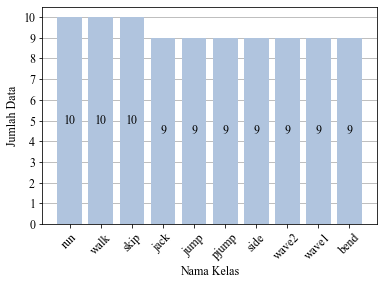

In [728]:
#Visualize data distribution per class
action_class = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
nvideo = [10, 10, 10, 9, 9, 9, 9, 9, 9, 9]
#font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams.update({'font.size': 12})
#plot
fig, ax = plt.subplots(figsize=(6, 4))
_ = plt.xticks(rotation=45)
_ = plt.grid(which="major", axis="y", zorder=0)
_ = plt.xlabel("Nama Kelas")
_ = plt.ylabel("Jumlah Data")
_ = ax.set(title="", yticks=[0,1,2,3,4,5,6,7,8,9,10])
barplot = ax.bar(action_class, nvideo, zorder=3, color="lightsteelblue")
_ = ax.bar_label(barplot, label_type="center")
#save plot
#plt.savefig("graphdatasetoriginal.png", dpi=300, orientation="landscape", format="png", transparent=True)

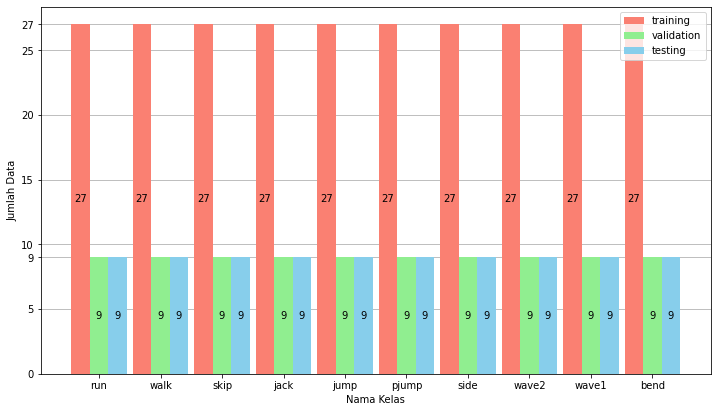

In [3]:
#Visualize data split after augmentation
action_class = np.arange(10)
nvideo_train = [27, 27, 27, 27, 27, 27, 27, 27, 27, 27]
nvideo_valid = [9, 9, 9, 9, 9, 9, 9, 9, 9, 9] 
nvideo_test = [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
width = 0.3
#plot
fig, ax = plt.subplots(figsize=(12, 6.75))
_ = plt.xticks(action_class,
               ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"],
               rotation=0)
_ = plt.grid(which="major", axis="y", zorder=0)
_ = plt.xlabel("Nama Kelas")
_ = plt.ylabel("Jumlah Data")
_ = ax.set(title="", yticks=[0,5,9,10,15,20,25,27,30])
barplot1 = ax.bar(action_class-width, nvideo_train, width, zorder=3, color="salmon")
barplot2 = ax.bar(action_class, nvideo_valid, width, zorder=3, color="lightgreen")
barplot3 = ax.bar(action_class+width, nvideo_test, width, zorder=3, color="skyblue")
_ = ax.bar_label(barplot1, label_type="center")
_ = ax.bar_label(barplot2, label_type="center")
_ = ax.bar_label(barplot3, label_type="center")
_ = ax.legend(["training", "validation", "testing"])
#save plot
#plt.savefig("graphdatasetaug.png", dpi=300, orientation="landscape", format="png", transparent=True)

# Function initialisation

In [2]:
mp_pose = mp.solutions.pose # Pose model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities
mp_connections = mp.solutions.pose_connections # Pose Connections

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
    image.flags.writeable = False # Image is unwritable
    results = model.process(image) # Prediction
    image.flags.writeable = True # Image is writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # Convert RGB to BGR
    return image, results

def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image,
                              results.pose_landmarks,
                              mp_pose.POSE_CONNECTIONS)
    
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image,
                              results.pose_landmarks,
                              mp_pose.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,110,10),
                                                     thickness=1,
                                                     circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80,255,121),
                                                     thickness=1,
                                                     circle_radius=1))
    
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(4*33)
    return pose

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title="Confusion Matrix",
                          cmap=plt.cm.Blues):
    """
    Prints & plots confusion matrix.
    Normalization can be applied by setting "normalize=True".
    """
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
        
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

# Base variables

In [6]:
# Path for exporting data in numpy array format
DATA_PATH_MP_LSTM = os.path.join("dataset_weizmann450_trainvalidtest_mp_lstm")

# Action to detect
actions = np.array(["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"])

# Data role
roles = np.array(["train", "valid", "test"])

# 27 videos per action for training
no_sequences_train = 27

# 9 videos per action for validation
no_sequences_valid = 9

# 9 videos per action for testing
no_sequences_test = 9

# frame length
sequence_length = 25

In [305]:
actions.shape[0]

10

# Collecting MediaPipe:Pose keypoints

In [8]:
# Make folder for saving landmarks/keypoints data

for role in roles:
    if role == "train":
        for action in actions:
            for sequence_train in range(no_sequences_train):
                try:
                    os.makedirs(os.path.join(DATA_PATH_MP_LSTM, role, action, str(sequence_train)))
                except:
                    pass
    elif role == "valid":
        for action in actions:
            for sequence_valid in range(no_sequences_valid):
                try:
                    os.makedirs(os.path.join(DATA_PATH_MP_LSTM, role, action, str(sequence_valid)))
                except:
                    pass
    else:
        for action in actions:
            for sequence_test in range(no_sequences_test):
                try:
                    os.makedirs(os.path.join(DATA_PATH_MP_LSTM, role, action, str(sequence_test)))
                except:
                    pass

In [9]:
# Play video input simultaneously & try to collect keypoints values
# for train, valid, & test folder

with mp_pose.Pose(static_image_mode=False,
                  model_complexity=1,
                  smooth_landmarks=True,
                  enable_segmentation=False,
                  smooth_segmentation=True,
                  min_detection_confidence=0.5,
                  min_tracking_confidence=0.5) as pose:
    
    for role in roles:
        if role == "train":
            for action in actions:
                for sequence_train in range(no_sequences_train):
                    cap = cv2.VideoCapture("dataset_weizmann450_trainvalidtest_encode/{}/{}/{}.avi".format(role,
                                                                                                           action, 
                                                                                                           sequence_train))
                    for frame_num in range(sequence_length):
                        # Read feed
                        ret, frame = cap.read()
                        # Make detections
                        image, results = mediapipe_detection(frame, pose)
                        print(results)
                        # Draw landmarks
                        draw_styled_landmarks(image, results)
                        # Export keypoints
                        keypoints = extract_keypoints(results)
                        npy_path = os.path.join(DATA_PATH_MP_LSTM, role, action, str(sequence_train), str(frame_num))
                        np.save(npy_path, keypoints)
                        # Show to screen
                        cv2.imshow("OpenCV Feed", image)
                        # Break while loop
                        if cv2.waitKey(10) & 0xFF == ord("q"):
                            break
                    cap.release()
                cv2.destroyAllWindows()
                
        elif role == "valid":
            for action in actions:
                for sequence_valid in range(no_sequences_valid):
                    cap = cv2.VideoCapture("dataset_weizmann450_trainvalidtest_encode/{}/{}/{}.avi".format(role,
                                                                                                           action,
                                                                                                           sequence_valid))
                    for frame_num in range(sequence_length):
                        # Read feed
                        ret, frame = cap.read()
                        # Make detections
                        image, results = mediapipe_detection(frame, pose)
                        print(results)
                        # Draw landmarks
                        draw_styled_landmarks(image, results)
                        # Export keypoints
                        keypoints = extract_keypoints(results)
                        npy_path = os.path.join(DATA_PATH_MP_LSTM, role, action, str(sequence_valid), str(frame_num))
                        np.save(npy_path, keypoints)
                        # Show to screen
                        cv2.imshow("OpenCV Feed", image)
                        # Break while loop
                        if cv2.waitKey(10) & 0xFF == ord("q"):
                            break
                    cap.release()
                cv2.destroyAllWindows()
                
        else:
            for action in actions:
                for sequence_test in range(no_sequences_test):
                    cap = cv2.VideoCapture("dataset_weizmann450_trainvalidtest_encode/{}/{}/{}.avi".format(role,
                                                                                                           action,
                                                                                                           sequence_test))
                    for frame_num in range(sequence_length):
                        # Read feed
                        ret, frame = cap.read()
                        # Make detections
                        image, results = mediapipe_detection(frame, pose)
                        print(results)
                        # Draw landmarks
                        draw_styled_landmarks(image, results)
                        # Export keypoints
                        keypoints = extract_keypoints(results)
                        npy_path = os.path.join(DATA_PATH_MP_LSTM, role, action, str(sequence_test), str(frame_num))
                        np.save(npy_path, keypoints)
                        # Show to screen
                        cv2.imshow("OpenCV Feed", image)
                        # Break while loop
                        if cv2.waitKey(10) & 0xFF == ord("q"):
                            break
                    cap.release()
                cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [48]:
# Check the numpy file
check_landmarks = np.load("C:/Users/Ichsan/tugasakhir-revisi/dataset_weizmann450_trainvalidtest_mp_lstm/train/run/0/6.npy")
print(check_landmarks)
# total 132 landmarks

[ 0.96752113  0.37125763 -0.08685564  0.98211157  0.97669184  0.36058575
 -0.10717104  0.98351371  0.98110485  0.36097261 -0.10728175  0.98047042
  0.98385805  0.36166689 -0.10741623  0.98541033  0.97158217  0.35927564
 -0.07332394  0.98306328  0.97149503  0.3588444  -0.07332949  0.9792341
  0.9712109   0.35851777 -0.07345095  0.98551536  0.99557781  0.36640793
 -0.13747612  0.98533696  0.98307502  0.36348617  0.0115742   0.9810704
  0.97577178  0.38537055 -0.09416386  0.96467364  0.96937102  0.38459277
 -0.05144553  0.95939243  0.98941082  0.45091778 -0.19212149  0.95326
  0.97267032  0.44342297  0.0979117   0.98511142  0.96695852  0.52403688
 -0.16036852  0.82849944  0.95825583  0.52518427  0.02035616  0.18993852
  0.94803363  0.50324225  0.03321738  0.40410668  0.94891959  0.52401203
 -0.18517229  0.27824381  0.93905133  0.49254689  0.03321592  0.33359584
  0.94403785  0.52596104 -0.19922838  0.26725727  0.94336486  0.4829891
  0.04453977  0.32013533  0.94645053  0.51664954 -0.21340

# Labeling data

In [47]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'run': 0,
 'walk': 1,
 'skip': 2,
 'jack': 3,
 'jump': 4,
 'pjump': 5,
 'side': 6,
 'wave2': 7,
 'wave1': 8,
 'bend': 9}

In [49]:
# Labelling each sequence/class
sequences_train, labels_train = [], []
sequences_valid, labels_valid = [], []
sequences_test, labels_test = [], []

for role in roles:
    if role == "train":
        for action in actions:
            for sequence_train in range(no_sequences_train):
                window = []
                for frame_num in range(sequence_length):
                    res = np.load(os.path.join(DATA_PATH_MP_LSTM, role, action, str(sequence_train), "{}.npy".format(frame_num)))
                    window.append(res)
                sequences_train.append(window)
                labels_train.append(label_map[action])
    elif role == "valid":
        for action in actions:
            for sequence_valid in range(no_sequences_valid):
                window = []
                for frame_num in range(sequence_length):
                    res = np.load(os.path.join(DATA_PATH_MP_LSTM, role, action, str(sequence_valid), "{}.npy".format(frame_num)))
                    window.append(res)
                sequences_valid.append(window)
                labels_valid.append(label_map[action])
    else:
        for action in actions:
            for sequence_test in range(no_sequences_test):
                window = []
                for frame_num in range(sequence_length):
                    res = np.load(os.path.join(DATA_PATH_MP_LSTM, role, action, str(sequence_test), "{}.npy".format(frame_num)))
                    window.append(res)
                sequences_test.append(window)
                labels_test.append(label_map[action])

In [50]:
X_train = np.array(sequences_train)
X_valid = np.array(sequences_valid)
X_test = np.array(sequences_test)

y_train = to_categorical(labels_train).astype(int)
y_valid = to_categorical(labels_valid).astype(int)
y_test = to_categorical(labels_test).astype(int)

print("X_train shape : "+str(X_train.shape))
print("X_valid shape : "+str(X_valid.shape))
print("X_test shape : "+str(X_test.shape))
print("y_train shape : "+str(y_train.shape))
print("y_valid shape : "+str(y_valid.shape))
print("y_test shape : "+str(y_test.shape))

# X shape = (data, frame, keypoint)
# keypoint = 33 keypoints * 4 values (3 axis[x,y,z] + visibility) = 132

# y shape = (data, label)

X_train shape : (270, 25, 132)
X_valid shape : (90, 25, 132)
X_test shape : (90, 25, 132)
y_train shape : (270, 10)
y_valid shape : (90, 10)
y_test shape : (90, 10)


# Illustrate extracting keypoints process
for report only

In [ ]:
# Visualize extracting keypoints process

cap = cv2.VideoCapture("dataset_weizmann450\jack\denis_jack_3.avi") # Video File

# Set mediapipe model
with mp_pose.Pose(static_image_mode=False,
                  model_complexity=1,
                  smooth_landmarks=True,
                  enable_segmentation=False,
                  smooth_segmentation=True,
                  min_detection_confidence=0.5,
                  min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        
        # Read feed
        ret, frame = cap.read()
        
        # Make detections
        image, results = mediapipe_detection(frame, pose)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Show to screen
        cv2.imshow("OpenCV Feed", image)
        
        # Break while loop
        if cv2.waitKey(10) & 0xFF == ord("q"):
            break
    
    cap.release()
    cv2.destroyAllWindows()


In [ ]:
plt.figure()
plt.imshow(image)

# lstm2_dense2_d_relu_mc_1
lstm3 (128,64) + dense2 (32,10) + activation=relu + nadam + ModelCheckpoint -> 1st trial, train:11min 2s, test:81,11%

#### Model 1 1st

In [649]:
# Define a sequential model
lstm2_dense2_d_relu_mc_1 = Sequential([
    LSTM(128, return_sequences=True, activation="relu", input_shape=(25,132)),
    Dropout(0.2),
    LSTM(64, return_sequences=False, activation="relu"),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [650]:
# Compile model with learning rate
lstm2_dense2_d_relu_mc_1.compile(Nadam(learning_rate=0.0001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [651]:
# Model Checkpoint Callback

checkpoint_filepath1 = os.path.join("tmp/lstm2_dense2_d_relu_mc_1_e{epoch:04d}_val{val_categorical_accuracy:.3f}.h5")

mc_val_acc = ModelCheckpoint(filepath = checkpoint_filepath1,
                             monitor="val_categorical_accuracy",
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode="max",
                             save_freq="epoch")

In [652]:
%%time
# Training model with validation
history1 = lstm2_dense2_d_relu_mc_1.fit(X_train, y_train, batch_size=4, epochs=200, shuffle=True, verbose=2,
                                      validation_data=(X_valid, y_valid), callbacks=[mc_val_acc])

Epoch 1/200

Epoch 00001: val_categorical_accuracy improved from -inf to 0.21111, saving model to tmp\lstm2_dense2_d_relu_mc_1_e0001_val0.211.h5
68/68 - 9s - loss: 2.3059 - categorical_accuracy: 0.1481 - val_loss: 2.2932 - val_categorical_accuracy: 0.2111 - 9s/epoch - 130ms/step
Epoch 2/200

Epoch 00002: val_categorical_accuracy improved from 0.21111 to 0.23333, saving model to tmp\lstm2_dense2_d_relu_mc_1_e0002_val0.233.h5
68/68 - 3s - loss: 2.2703 - categorical_accuracy: 0.2037 - val_loss: 2.2378 - val_categorical_accuracy: 0.2333 - 3s/epoch - 48ms/step
Epoch 3/200

Epoch 00003: val_categorical_accuracy improved from 0.23333 to 0.26667, saving model to tmp\lstm2_dense2_d_relu_mc_1_e0003_val0.267.h5
68/68 - 3s - loss: 2.1937 - categorical_accuracy: 0.2333 - val_loss: 1.9651 - val_categorical_accuracy: 0.2667 - 3s/epoch - 48ms/step
Epoch 4/200

Epoch 00004: val_categorical_accuracy improved from 0.26667 to 0.33333, saving model to tmp\lstm2_dense2_d_relu_mc_1_e0004_val0.333.h5
68/68 - 

Epoch 35/200

Epoch 00035: val_categorical_accuracy did not improve from 0.73333
68/68 - 3s - loss: 0.5206 - categorical_accuracy: 0.8074 - val_loss: 0.8399 - val_categorical_accuracy: 0.6556 - 3s/epoch - 48ms/step
Epoch 36/200

Epoch 00036: val_categorical_accuracy improved from 0.73333 to 0.75556, saving model to tmp\lstm2_dense2_d_relu_mc_1_e0036_val0.756.h5
68/68 - 3s - loss: 0.5099 - categorical_accuracy: 0.8111 - val_loss: 0.6373 - val_categorical_accuracy: 0.7556 - 3s/epoch - 47ms/step
Epoch 37/200

Epoch 00037: val_categorical_accuracy improved from 0.75556 to 0.76667, saving model to tmp\lstm2_dense2_d_relu_mc_1_e0037_val0.767.h5
68/68 - 3s - loss: 0.4859 - categorical_accuracy: 0.8296 - val_loss: 0.5718 - val_categorical_accuracy: 0.7667 - 3s/epoch - 47ms/step
Epoch 38/200

Epoch 00038: val_categorical_accuracy did not improve from 0.76667
68/68 - 3s - loss: 0.4909 - categorical_accuracy: 0.8407 - val_loss: 0.6693 - val_categorical_accuracy: 0.7000 - 3s/epoch - 47ms/step
Epoc

Epoch 72/200

Epoch 00072: val_categorical_accuracy did not improve from 0.82222
68/68 - 3s - loss: 0.5651 - categorical_accuracy: 0.8000 - val_loss: 0.7613 - val_categorical_accuracy: 0.7556 - 3s/epoch - 48ms/step
Epoch 73/200

Epoch 00073: val_categorical_accuracy did not improve from 0.82222
68/68 - 3s - loss: 0.3579 - categorical_accuracy: 0.8815 - val_loss: 0.8616 - val_categorical_accuracy: 0.7222 - 3s/epoch - 47ms/step
Epoch 74/200

Epoch 00074: val_categorical_accuracy did not improve from 0.82222
68/68 - 3s - loss: 0.3746 - categorical_accuracy: 0.8704 - val_loss: 0.6815 - val_categorical_accuracy: 0.7778 - 3s/epoch - 47ms/step
Epoch 75/200

Epoch 00075: val_categorical_accuracy did not improve from 0.82222
68/68 - 3s - loss: 0.2671 - categorical_accuracy: 0.8815 - val_loss: 0.6583 - val_categorical_accuracy: 0.7556 - 3s/epoch - 47ms/step
Epoch 76/200

Epoch 00076: val_categorical_accuracy did not improve from 0.82222
68/68 - 3s - loss: 0.3238 - categorical_accuracy: 0.8704 - 


Epoch 00110: val_categorical_accuracy did not improve from 0.82222
68/68 - 3s - loss: 0.2107 - categorical_accuracy: 0.9296 - val_loss: 0.6314 - val_categorical_accuracy: 0.7667 - 3s/epoch - 47ms/step
Epoch 111/200

Epoch 00111: val_categorical_accuracy did not improve from 0.82222
68/68 - 3s - loss: 0.1668 - categorical_accuracy: 0.9370 - val_loss: 0.7695 - val_categorical_accuracy: 0.7667 - 3s/epoch - 47ms/step
Epoch 112/200

Epoch 00112: val_categorical_accuracy did not improve from 0.82222
68/68 - 3s - loss: 0.1767 - categorical_accuracy: 0.9370 - val_loss: 1.5480 - val_categorical_accuracy: 0.7333 - 3s/epoch - 47ms/step
Epoch 113/200

Epoch 00113: val_categorical_accuracy did not improve from 0.82222
68/68 - 3s - loss: 0.3178 - categorical_accuracy: 0.9037 - val_loss: 0.8829 - val_categorical_accuracy: 0.7667 - 3s/epoch - 47ms/step
Epoch 114/200

Epoch 00114: val_categorical_accuracy did not improve from 0.82222
68/68 - 3s - loss: 0.2069 - categorical_accuracy: 0.9407 - val_loss:

Epoch 148/200

Epoch 00148: val_categorical_accuracy did not improve from 0.83333
68/68 - 3s - loss: 0.0885 - categorical_accuracy: 0.9741 - val_loss: 0.7817 - val_categorical_accuracy: 0.8000 - 3s/epoch - 47ms/step
Epoch 149/200

Epoch 00149: val_categorical_accuracy did not improve from 0.83333
68/68 - 3s - loss: 0.5021 - categorical_accuracy: 0.8926 - val_loss: 0.6817 - val_categorical_accuracy: 0.7444 - 3s/epoch - 51ms/step
Epoch 150/200

Epoch 00150: val_categorical_accuracy did not improve from 0.83333
68/68 - 4s - loss: 0.1202 - categorical_accuracy: 0.9481 - val_loss: 0.5028 - val_categorical_accuracy: 0.7778 - 4s/epoch - 52ms/step
Epoch 151/200

Epoch 00151: val_categorical_accuracy did not improve from 0.83333
68/68 - 3s - loss: 0.0639 - categorical_accuracy: 0.9852 - val_loss: 0.4984 - val_categorical_accuracy: 0.8111 - 3s/epoch - 49ms/step
Epoch 152/200

Epoch 00152: val_categorical_accuracy did not improve from 0.83333
68/68 - 3s - loss: 0.0634 - categorical_accuracy: 0.97

Epoch 186/200

Epoch 00186: val_categorical_accuracy did not improve from 0.83333
68/68 - 3s - loss: 0.0701 - categorical_accuracy: 0.9778 - val_loss: 1.2936 - val_categorical_accuracy: 0.7333 - 3s/epoch - 47ms/step
Epoch 187/200

Epoch 00187: val_categorical_accuracy did not improve from 0.83333
68/68 - 3s - loss: 0.0901 - categorical_accuracy: 0.9556 - val_loss: 1.0339 - val_categorical_accuracy: 0.7556 - 3s/epoch - 47ms/step
Epoch 188/200

Epoch 00188: val_categorical_accuracy did not improve from 0.83333
68/68 - 3s - loss: 0.0790 - categorical_accuracy: 0.9889 - val_loss: 1.0604 - val_categorical_accuracy: 0.7778 - 3s/epoch - 47ms/step
Epoch 189/200

Epoch 00189: val_categorical_accuracy did not improve from 0.83333
68/68 - 3s - loss: 0.0988 - categorical_accuracy: 0.9593 - val_loss: 1.1577 - val_categorical_accuracy: 0.7333 - 3s/epoch - 47ms/step
Epoch 190/200

Epoch 00190: val_categorical_accuracy did not improve from 0.83333
68/68 - 3s - loss: 0.0610 - categorical_accuracy: 0.98

In [653]:
# Save history to json and csv

# convert the history1.history dict to a pandas DataFrame:     
hist_df_1 = pd.DataFrame(history1.history) 

# save to json:  
hist_json_file_1 = 'history/mine/json/lstm2_dense2_d_relu_mc_1.json' 
with open(hist_json_file_1, mode='w') as f:
    hist_df_1.to_json(f)

# or save to csv: 
hist_csv_file_1 = 'history/mine/csv/lstm2_dense2_d_relu_mc_1.csv'
with open(hist_csv_file_1, mode='w') as f:
    hist_df_1.to_csv(f)

In [ ]:
lstm2_dense2_d_relu_mc_1.summary()

In [654]:
# Load Model
lstm2_dense2_d_relu_mc_1.load_weights("tmp\lstm2_dense2_d_relu_mc_1_e0130_val0.833.h5")

In [ ]:
# Save Model
lstm2_dense2_d_relu_mc_1.save("model2\lstm2_dense2_d_relu_mc_1_e0149_val0.844.h5")

In [ ]:
# Visualize weight
plot_model(lstm2_dense2_d_relu_mc_1,
           to_file = "arc_lstm2_dense2_d_relu_mc_1_e0190_val0.844.png",
           show_shapes = True,
           show_dtype=True,
           expand_nested=True,
           show_layer_activations=True)

In [ ]:
# Visualize
plot_model(lstm2_dense2_d_relu_mc_1, to_file = "arc_lstm2_dense2_d_relu_mc_1_0310_23032022.png", show_shapes = True)

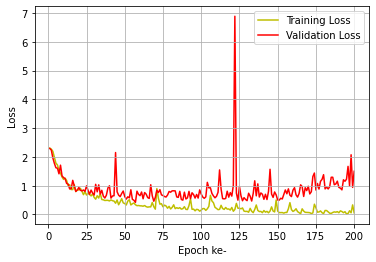

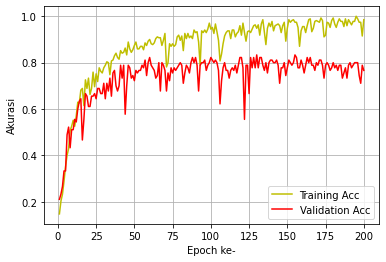

In [655]:
# Plot training and validation

loss1 = history1.history["loss"]
val_loss1 = history1.history["val_loss"]
epochs1 = range(1, len(loss1) + 1)
plt.plot(epochs1, loss1, "y", zorder=0, label="Training Loss")
plt.plot(epochs1, val_loss1, "r", zorder=0, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-") 
plt.ylabel("Loss")
plt.legend()
plt.show()

acc1 = history1.history["categorical_accuracy"]
val_acc1 = history1.history["val_categorical_accuracy"]
plt.plot(epochs1, acc1, "y", zorder=3, label="Training Acc")
plt.plot(epochs1, val_acc1, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Akurasi")
plt.legend()
plt.show()

In [656]:
res1 = lstm2_dense2_d_relu_mc_1.predict(X_test)

In [657]:
yhat1 = lstm2_dense2_d_relu_mc_1.predict(X_test)
ytrue1 = np.argmax(y_test, axis=1).tolist()
yhat1 = np.argmax(yhat1, axis=1).tolist()

In [658]:
cm1 = confusion_matrix(y_true = ytrue1, y_pred = yhat1)

Confusion matrix, without normalization
[[2 2 4 0 1 0 0 0 0 0]
 [2 6 0 0 1 0 0 0 0 0]
 [1 1 6 0 1 0 0 0 0 0]
 [0 0 0 9 0 0 0 0 0 0]
 [1 0 1 0 6 0 0 0 0 1]
 [0 0 0 0 0 8 1 0 0 0]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 0 9 0]
 [0 0 0 0 0 0 0 0 0 9]]


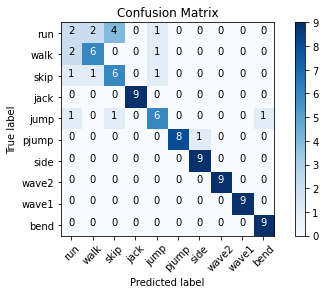

In [659]:
cm_plot_labels1 = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm1, classes = cm_plot_labels1, title = "Confusion Matrix")

In [660]:
fp1 = cm1.sum(axis=0) - np.diag(cm1)  
fn1 = cm1.sum(axis=1) - np.diag(cm1)
tp1 = np.diag(cm1)
tn1 = cm1.sum() - (fp1 + fn1 + tp1)

print(fp1,fn1,tp1,tn1)

[4 3 5 0 3 0 1 0 0 1] [7 3 3 0 3 1 0 0 0 0] [2 6 6 9 6 8 9 9 9 9] [77 78 76 81 78 81 80 81 81 80]


In [661]:
print(tp1)
print(fp1)
print(tn1)
print(fn1)

[2 6 6 9 6 8 9 9 9 9]
[4 3 5 0 3 0 1 0 0 1]
[77 78 76 81 78 81 80 81 81 80]
[7 3 3 0 3 1 0 0 0 0]


In [662]:
y_pred1 = lstm2_dense2_d_relu_mc_1.predict(X_test)
y_pred1 = (y_pred1 > 0.5)

In [663]:
_, acc1 = lstm2_dense2_d_relu_mc_1.evaluate(X_test, y_test)
print("Accuracy = ", (acc1*100), " %")

3/3 [==============================] - 0s 29ms/step - loss: 0.8816 - categorical_accuracy: 0.8111
Accuracy =  81.11110925674438  %


In [664]:
loss1_2, acc1_2 = lstm2_dense2_d_relu_mc_1.evaluate(X_train, y_train)
loss1_3, acc1_3 = lstm2_dense2_d_relu_mc_1.evaluate(X_valid, y_valid)

print("Accuracy2 = ", (acc1_2*100), " %")
print("Accuracy3 = ", (acc1_3*100), " %")

3/3 [==============================] - 0s 31ms/step - loss: 0.4804 - categorical_accuracy: 0.8333
Accuracy2 =  96.66666388511658  %
Accuracy3 =  83.33333134651184  %


In [665]:
acc1 = accuracy_score(ytrue1, yhat1)
acc1

0.8111111111111111

In [666]:
# Error rate
error_rate1 = 1 - acc1
error_rate1

0.18888888888888888

In [667]:
print(classification_report(
    ytrue1,
    yhat1,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.33      0.22      0.27         9
        walk       0.67      0.67      0.67         9
        skip       0.55      0.67      0.60         9
        jack       1.00      1.00      1.00         9
        jump       0.67      0.67      0.67         9
       pjump       1.00      0.89      0.94         9
        side       0.90      1.00      0.95         9
       wave2       1.00      1.00      1.00         9
       wave1       1.00      1.00      1.00         9
        bend       0.90      1.00      0.95         9

    accuracy                           0.81        90
   macro avg       0.80      0.81      0.80        90
weighted avg       0.80      0.81      0.80        90



# lstm2_dense2_d_relu_mc_2
lstm3 (128,64) + dense2 (32,10) + activation=relu + nadam + ModelCheckpoint -> 2nd trial, train:10min 59s, test:78,88%

#### Model 1 2nd

In [608]:
# Define a sequential model
lstm2_dense2_d_relu_mc_2 = Sequential([
    LSTM(128, return_sequences=True, activation="relu", input_shape=(25,132)),
    Dropout(0.2),
    LSTM(64, return_sequences=False, activation="relu"),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [609]:
# Compile model with learning rate
lstm2_dense2_d_relu_mc_2.compile(Nadam(learning_rate=0.0001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [610]:
# Model Checkpoint Callback

checkpoint_filepath2 = os.path.join("tmp/lstm2_dense2_d_relu_mc_2_e{epoch:04d}_val{val_categorical_accuracy:.3f}.h5")

mc_val_acc = ModelCheckpoint(filepath = checkpoint_filepath2,
                             monitor="val_categorical_accuracy",
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode="max",
                             save_freq="epoch")

In [611]:
%%time
# Training model with validation
history2 = lstm2_dense2_d_relu_mc_2.fit(X_train, y_train, batch_size=4, epochs=200, shuffle=True, verbose=2,
                                      validation_data=(X_valid, y_valid), callbacks=[mc_val_acc])

Epoch 1/200

Epoch 00001: val_categorical_accuracy improved from -inf to 0.20000, saving model to tmp\lstm2_dense2_d_relu_mc_2_e0001_val0.200.h5
68/68 - 9s - loss: 2.3061 - categorical_accuracy: 0.0889 - val_loss: 2.2578 - val_categorical_accuracy: 0.2000 - 9s/epoch - 127ms/step
Epoch 2/200

Epoch 00002: val_categorical_accuracy did not improve from 0.20000
68/68 - 3s - loss: 2.2220 - categorical_accuracy: 0.1667 - val_loss: 2.0567 - val_categorical_accuracy: 0.2000 - 3s/epoch - 44ms/step
Epoch 3/200

Epoch 00003: val_categorical_accuracy improved from 0.20000 to 0.26667, saving model to tmp\lstm2_dense2_d_relu_mc_2_e0003_val0.267.h5
68/68 - 3s - loss: 2.0076 - categorical_accuracy: 0.2259 - val_loss: 1.8118 - val_categorical_accuracy: 0.2667 - 3s/epoch - 49ms/step
Epoch 4/200

Epoch 00004: val_categorical_accuracy improved from 0.26667 to 0.34444, saving model to tmp\lstm2_dense2_d_relu_mc_2_e0004_val0.344.h5
68/68 - 3s - loss: 1.8093 - categorical_accuracy: 0.3037 - val_loss: 1.6839 

Epoch 36/200

Epoch 00036: val_categorical_accuracy improved from 0.72222 to 0.75556, saving model to tmp\lstm2_dense2_d_relu_mc_2_e0036_val0.756.h5
68/68 - 3s - loss: 0.5479 - categorical_accuracy: 0.8000 - val_loss: 0.6268 - val_categorical_accuracy: 0.7556 - 3s/epoch - 48ms/step
Epoch 37/200

Epoch 00037: val_categorical_accuracy did not improve from 0.75556
68/68 - 3s - loss: 0.4304 - categorical_accuracy: 0.8481 - val_loss: 0.6801 - val_categorical_accuracy: 0.7556 - 3s/epoch - 48ms/step
Epoch 38/200

Epoch 00038: val_categorical_accuracy did not improve from 0.75556
68/68 - 3s - loss: 0.5237 - categorical_accuracy: 0.7926 - val_loss: 0.7761 - val_categorical_accuracy: 0.7111 - 3s/epoch - 47ms/step
Epoch 39/200

Epoch 00039: val_categorical_accuracy did not improve from 0.75556
68/68 - 3s - loss: 0.4674 - categorical_accuracy: 0.8111 - val_loss: 0.8251 - val_categorical_accuracy: 0.7111 - 3s/epoch - 47ms/step
Epoch 40/200

Epoch 00040: val_categorical_accuracy did not improve from

Epoch 74/200

Epoch 00074: val_categorical_accuracy did not improve from 0.78889
68/68 - 3s - loss: 0.2415 - categorical_accuracy: 0.9037 - val_loss: 0.8159 - val_categorical_accuracy: 0.7333 - 3s/epoch - 47ms/step
Epoch 75/200

Epoch 00075: val_categorical_accuracy did not improve from 0.78889
68/68 - 3s - loss: 0.2567 - categorical_accuracy: 0.9148 - val_loss: 1.0422 - val_categorical_accuracy: 0.7333 - 3s/epoch - 47ms/step
Epoch 76/200

Epoch 00076: val_categorical_accuracy did not improve from 0.78889
68/68 - 4s - loss: 0.2858 - categorical_accuracy: 0.8852 - val_loss: 1.0499 - val_categorical_accuracy: 0.7111 - 4s/epoch - 53ms/step
Epoch 77/200

Epoch 00077: val_categorical_accuracy did not improve from 0.78889
68/68 - 4s - loss: 0.2258 - categorical_accuracy: 0.9296 - val_loss: 0.9638 - val_categorical_accuracy: 0.7222 - 4s/epoch - 58ms/step
Epoch 78/200

Epoch 00078: val_categorical_accuracy did not improve from 0.78889
68/68 - 4s - loss: 0.3480 - categorical_accuracy: 0.8481 - 

Epoch 112/200

Epoch 00112: val_categorical_accuracy did not improve from 0.81111
68/68 - 3s - loss: 0.2233 - categorical_accuracy: 0.9222 - val_loss: 0.7972 - val_categorical_accuracy: 0.8000 - 3s/epoch - 49ms/step
Epoch 113/200

Epoch 00113: val_categorical_accuracy did not improve from 0.81111
68/68 - 3s - loss: 0.0936 - categorical_accuracy: 0.9741 - val_loss: 1.0869 - val_categorical_accuracy: 0.7778 - 3s/epoch - 47ms/step
Epoch 114/200

Epoch 00114: val_categorical_accuracy did not improve from 0.81111
68/68 - 4s - loss: 0.1220 - categorical_accuracy: 0.9519 - val_loss: 1.0536 - val_categorical_accuracy: 0.7889 - 4s/epoch - 52ms/step
Epoch 115/200

Epoch 00115: val_categorical_accuracy did not improve from 0.81111
68/68 - 3s - loss: 0.2114 - categorical_accuracy: 0.9111 - val_loss: 1.0555 - val_categorical_accuracy: 0.7667 - 3s/epoch - 48ms/step
Epoch 116/200

Epoch 00116: val_categorical_accuracy did not improve from 0.81111
68/68 - 3s - loss: 0.1429 - categorical_accuracy: 0.95

Epoch 150/200

Epoch 00150: val_categorical_accuracy did not improve from 0.84444
68/68 - 3s - loss: 0.3153 - categorical_accuracy: 0.9296 - val_loss: 0.4568 - val_categorical_accuracy: 0.8111 - 3s/epoch - 47ms/step
Epoch 151/200

Epoch 00151: val_categorical_accuracy did not improve from 0.84444
68/68 - 3s - loss: 0.1138 - categorical_accuracy: 0.9667 - val_loss: 0.5016 - val_categorical_accuracy: 0.8333 - 3s/epoch - 47ms/step
Epoch 152/200

Epoch 00152: val_categorical_accuracy did not improve from 0.84444
68/68 - 3s - loss: 0.0643 - categorical_accuracy: 0.9778 - val_loss: 0.7188 - val_categorical_accuracy: 0.8333 - 3s/epoch - 47ms/step
Epoch 153/200

Epoch 00153: val_categorical_accuracy did not improve from 0.84444
68/68 - 3s - loss: 0.0367 - categorical_accuracy: 0.9889 - val_loss: 0.7370 - val_categorical_accuracy: 0.8333 - 3s/epoch - 47ms/step
Epoch 154/200

Epoch 00154: val_categorical_accuracy did not improve from 0.84444
68/68 - 3s - loss: 0.1894 - categorical_accuracy: 0.93

Epoch 188/200

Epoch 00188: val_categorical_accuracy did not improve from 0.84444
68/68 - 3s - loss: 0.2466 - categorical_accuracy: 0.9259 - val_loss: 0.7385 - val_categorical_accuracy: 0.8222 - 3s/epoch - 47ms/step
Epoch 189/200

Epoch 00189: val_categorical_accuracy did not improve from 0.84444
68/68 - 3s - loss: 0.0586 - categorical_accuracy: 0.9815 - val_loss: 1.0562 - val_categorical_accuracy: 0.8000 - 3s/epoch - 48ms/step
Epoch 190/200

Epoch 00190: val_categorical_accuracy did not improve from 0.84444
68/68 - 3s - loss: 0.0333 - categorical_accuracy: 0.9926 - val_loss: 1.1444 - val_categorical_accuracy: 0.8000 - 3s/epoch - 47ms/step
Epoch 191/200

Epoch 00191: val_categorical_accuracy did not improve from 0.84444
68/68 - 3s - loss: 0.0273 - categorical_accuracy: 0.9889 - val_loss: 1.2823 - val_categorical_accuracy: 0.8222 - 3s/epoch - 48ms/step
Epoch 192/200

Epoch 00192: val_categorical_accuracy did not improve from 0.84444
68/68 - 3s - loss: 0.2796 - categorical_accuracy: 0.93

In [613]:
# Save history to json and csv

# convert the history1.history dict to a pandas DataFrame:     
hist_df_2 = pd.DataFrame(history2.history) 

# save to json:  
hist_json_file_2 = 'history/mine/json/lstm2_dense2_d_relu_mc_2.json' 
with open(hist_json_file_2, mode='w') as f:
    hist_df_2.to_json(f)

# or save to csv: 
hist_csv_file_2 = 'history/mine/csv/lstm2_dense2_d_relu_mc_2.csv'
with open(hist_csv_file_2, mode='w') as f:
    hist_df_2.to_csv(f)

In [ ]:
lstm2_dense2_d_relu_mc_2.summary()

In [612]:
# Load Model
lstm2_dense2_d_relu_mc_2.load_weights("tmp\lstm2_dense2_d_relu_mc_2_e0144_val0.844.h5")

In [ ]:
# Save Model
lstm2_dense2_d_relu_mc_2.save("model2\lstm2_dense2_d_relu_mc_2_e0149_val0.844.h5")

In [ ]:
# Visualize weight
plot_model(lstm2_dense2_d_relu_mc_2,
           to_file = "arc_lstm2_dense2_d_relu_mc_2_e0190_val0.844.png",
           show_shapes = True,
           show_dtype=True,
           expand_nested=True,
           show_layer_activations=True)

In [ ]:
# Visualize
plot_model(lstm2_dense2_d_relu_mc_2, to_file = "arc_lstm2_dense2_d_relu_mc_2_0310_23032022.png", show_shapes = True)

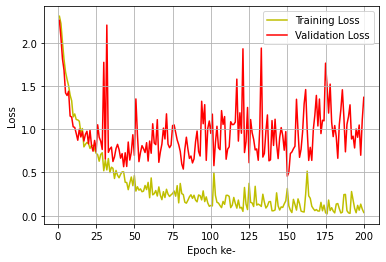

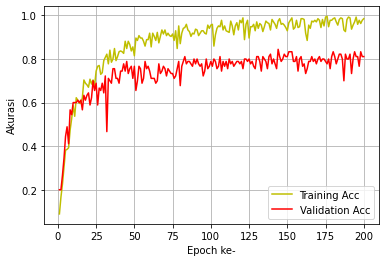

In [614]:
# Plot training and validation

loss2 = history2.history["loss"]
val_loss2 = history2.history["val_loss"]
epochs2 = range(1, len(loss2) + 1)
plt.plot(epochs2, loss2, "y", zorder=0, label="Training Loss")
plt.plot(epochs2, val_loss2, "r", zorder=0, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-") 
plt.ylabel("Loss")
plt.legend()
plt.show()

acc2 = history2.history["categorical_accuracy"]
val_acc2 = history2.history["val_categorical_accuracy"]
plt.plot(epochs2, acc2, "y", zorder=3, label="Training Acc")
plt.plot(epochs2, val_acc2, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Akurasi")
plt.legend()
plt.show()

In [615]:
res2 = lstm2_dense2_d_relu_mc_2.predict(X_test)

In [616]:
yhat2 = lstm2_dense2_d_relu_mc_2.predict(X_test)
ytrue2 = np.argmax(y_test, axis=1).tolist()
yhat2 = np.argmax(yhat2, axis=1).tolist()

In [617]:
cm2 = confusion_matrix(y_true = ytrue2, y_pred = yhat2)

Confusion matrix, without normalization
[[2 2 5 0 0 0 0 0 0 0]
 [2 7 0 0 0 0 0 0 0 0]
 [5 1 3 0 0 0 0 0 0 0]
 [0 0 0 9 0 0 0 0 0 0]
 [1 0 1 0 7 0 0 0 0 0]
 [0 0 0 0 0 8 1 0 0 0]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 1 0 0 0 0 8 0]
 [0 0 0 0 0 0 0 0 0 9]]


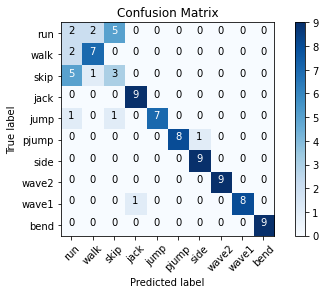

In [618]:
cm_plot_labels2 = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm2, classes = cm_plot_labels2, title = "Confusion Matrix")

In [619]:
fp2 = cm2.sum(axis=0) - np.diag(cm2)  
fn2 = cm2.sum(axis=1) - np.diag(cm2)
tp2 = np.diag(cm2)
tn2 = cm2.sum() - (fp2 + fn2 + tp2)

print(fp2,fn2,tp2,tn2)

[8 3 6 1 0 0 1 0 0 0] [7 2 6 0 2 1 0 0 1 0] [2 7 3 9 7 8 9 9 8 9] [73 78 75 80 81 81 80 81 81 81]


In [620]:
print(tp2)
print(fp2)
print(tn2)
print(fn2)

[2 7 3 9 7 8 9 9 8 9]
[8 3 6 1 0 0 1 0 0 0]
[73 78 75 80 81 81 80 81 81 81]
[7 2 6 0 2 1 0 0 1 0]


In [621]:
y_pred2 = lstm2_dense2_d_relu_mc_2.predict(X_test)
y_pred2 = (y_pred2 > 0.5)

In [622]:
_, acc2 = lstm2_dense2_d_relu_mc_2.evaluate(X_test, y_test)
print("Accuracy = ", (acc2*100), " %")

3/3 [==============================] - 0s 31ms/step - loss: 0.8581 - categorical_accuracy: 0.7889
Accuracy =  78.88888716697693  %


In [623]:
loss2_2, acc2_2 = lstm2_dense2_d_relu_mc_2.evaluate(X_train, y_train)
loss2_3, acc2_3 = lstm2_dense2_d_relu_mc_2.evaluate(X_valid, y_valid)

print("Accuracy2 = ", (acc1_2*100), " %")
print("Accuracy3 = ", (acc1_3*100), " %")

3/3 [==============================] - 0s 31ms/step - loss: 0.6604 - categorical_accuracy: 0.8444
Accuracy2 =  99.62962865829468  %
Accuracy3 =  75.55555701255798  %


In [624]:
acc2 = accuracy_score(ytrue2, yhat2)
acc2

0.7888888888888889

In [625]:
# Error rate
error_rate2 = 1 - acc2
error_rate2

0.21111111111111114

In [626]:
print(classification_report(
    ytrue2,
    yhat2,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.20      0.22      0.21         9
        walk       0.70      0.78      0.74         9
        skip       0.33      0.33      0.33         9
        jack       0.90      1.00      0.95         9
        jump       1.00      0.78      0.88         9
       pjump       1.00      0.89      0.94         9
        side       0.90      1.00      0.95         9
       wave2       1.00      1.00      1.00         9
       wave1       1.00      0.89      0.94         9
        bend       1.00      1.00      1.00         9

    accuracy                           0.79        90
   macro avg       0.80      0.79      0.79        90
weighted avg       0.80      0.79      0.79        90



# lstm2_dense2_d_relu_mc_3
lstm3 (128,64) + dense2 (32,10) + activation=relu + nadam + ModelCheckpoint -> 3rd trial, train:10min 50s, test:82,22%

#### Model 1 3rd (Chosen)

In [627]:
# Define a sequential model
lstm2_dense2_d_relu_mc_3 = Sequential([
    LSTM(128, return_sequences=True, activation="relu", input_shape=(25,132)),
    Dropout(0.2),
    LSTM(64, return_sequences=False, activation="relu"),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [628]:
# Compile model with learning rate
lstm2_dense2_d_relu_mc_3.compile(Nadam(learning_rate=0.0001),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [629]:
# Model Checkpoint Callback

checkpoint_filepath3 = os.path.join("tmp/lstm2_dense2_d_relu_mc_3_e{epoch:04d}_val{val_categorical_accuracy:.3f}.h5")

mc_val_acc = ModelCheckpoint(filepath = checkpoint_filepath3,
                             monitor="val_categorical_accuracy",
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode="max",
                             save_freq="epoch")

In [630]:
%%time
# Training model with validation
history3 = lstm2_dense2_d_relu_mc_3.fit(X_train, y_train, batch_size=4, epochs=200, shuffle=True, verbose=2,
                                      validation_data=(X_valid, y_valid), callbacks=[mc_val_acc])

Epoch 1/200

Epoch 00001: val_categorical_accuracy improved from -inf to 0.21111, saving model to tmp\lstm2_dense2_d_relu_mc_3_e0001_val0.211.h5
68/68 - 9s - loss: 2.3020 - categorical_accuracy: 0.1333 - val_loss: 2.2401 - val_categorical_accuracy: 0.2111 - 9s/epoch - 131ms/step
Epoch 2/200

Epoch 00002: val_categorical_accuracy improved from 0.21111 to 0.26667, saving model to tmp\lstm2_dense2_d_relu_mc_3_e0002_val0.267.h5
68/68 - 3s - loss: 2.1448 - categorical_accuracy: 0.1630 - val_loss: 1.9768 - val_categorical_accuracy: 0.2667 - 3s/epoch - 48ms/step
Epoch 3/200

Epoch 00003: val_categorical_accuracy improved from 0.26667 to 0.28889, saving model to tmp\lstm2_dense2_d_relu_mc_3_e0003_val0.289.h5
68/68 - 3s - loss: 1.9781 - categorical_accuracy: 0.2333 - val_loss: 1.9058 - val_categorical_accuracy: 0.2889 - 3s/epoch - 50ms/step
Epoch 4/200

Epoch 00004: val_categorical_accuracy improved from 0.28889 to 0.41111, saving model to tmp\lstm2_dense2_d_relu_mc_3_e0004_val0.411.h5
68/68 - 

Epoch 36/200

Epoch 00036: val_categorical_accuracy did not improve from 0.74444
68/68 - 3s - loss: 0.4969 - categorical_accuracy: 0.8333 - val_loss: 1.0689 - val_categorical_accuracy: 0.6111 - 3s/epoch - 46ms/step
Epoch 37/200

Epoch 00037: val_categorical_accuracy did not improve from 0.74444
68/68 - 3s - loss: 0.5123 - categorical_accuracy: 0.8148 - val_loss: 0.9615 - val_categorical_accuracy: 0.7000 - 3s/epoch - 46ms/step
Epoch 38/200

Epoch 00038: val_categorical_accuracy did not improve from 0.74444
68/68 - 3s - loss: 0.4997 - categorical_accuracy: 0.8148 - val_loss: 0.9447 - val_categorical_accuracy: 0.7222 - 3s/epoch - 47ms/step
Epoch 39/200

Epoch 00039: val_categorical_accuracy did not improve from 0.74444
68/68 - 3s - loss: 0.4626 - categorical_accuracy: 0.8444 - val_loss: 0.8108 - val_categorical_accuracy: 0.7333 - 3s/epoch - 47ms/step
Epoch 40/200

Epoch 00040: val_categorical_accuracy did not improve from 0.74444
68/68 - 3s - loss: 0.4061 - categorical_accuracy: 0.8667 - 

Epoch 74/200

Epoch 00074: val_categorical_accuracy did not improve from 0.77778
68/68 - 4s - loss: 0.1786 - categorical_accuracy: 0.9370 - val_loss: 1.0765 - val_categorical_accuracy: 0.7444 - 4s/epoch - 57ms/step
Epoch 75/200

Epoch 00075: val_categorical_accuracy did not improve from 0.77778
68/68 - 4s - loss: 0.2140 - categorical_accuracy: 0.9333 - val_loss: 1.0033 - val_categorical_accuracy: 0.7444 - 4s/epoch - 56ms/step
Epoch 76/200

Epoch 00076: val_categorical_accuracy did not improve from 0.77778
68/68 - 4s - loss: 0.1232 - categorical_accuracy: 0.9370 - val_loss: 1.1729 - val_categorical_accuracy: 0.7222 - 4s/epoch - 57ms/step
Epoch 77/200

Epoch 00077: val_categorical_accuracy did not improve from 0.77778
68/68 - 3s - loss: 0.2251 - categorical_accuracy: 0.9111 - val_loss: 0.8784 - val_categorical_accuracy: 0.7333 - 3s/epoch - 50ms/step
Epoch 78/200

Epoch 00078: val_categorical_accuracy did not improve from 0.77778
68/68 - 3s - loss: 0.1848 - categorical_accuracy: 0.9444 - 

Epoch 112/200

Epoch 00112: val_categorical_accuracy did not improve from 0.81111
68/68 - 3s - loss: 0.1073 - categorical_accuracy: 0.9630 - val_loss: 1.4618 - val_categorical_accuracy: 0.7222 - 3s/epoch - 46ms/step
Epoch 113/200

Epoch 00113: val_categorical_accuracy did not improve from 0.81111
68/68 - 3s - loss: 0.1879 - categorical_accuracy: 0.9333 - val_loss: 0.9599 - val_categorical_accuracy: 0.7333 - 3s/epoch - 47ms/step
Epoch 114/200

Epoch 00114: val_categorical_accuracy did not improve from 0.81111
68/68 - 3s - loss: 0.1492 - categorical_accuracy: 0.9444 - val_loss: 1.3953 - val_categorical_accuracy: 0.7667 - 3s/epoch - 47ms/step
Epoch 115/200

Epoch 00115: val_categorical_accuracy did not improve from 0.81111
68/68 - 3s - loss: 0.2340 - categorical_accuracy: 0.9407 - val_loss: 0.8346 - val_categorical_accuracy: 0.7444 - 3s/epoch - 46ms/step
Epoch 116/200

Epoch 00116: val_categorical_accuracy did not improve from 0.81111
68/68 - 3s - loss: 0.1071 - categorical_accuracy: 0.97

Epoch 150/200

Epoch 00150: val_categorical_accuracy did not improve from 0.81111
68/68 - 3s - loss: 0.5047 - categorical_accuracy: 0.8889 - val_loss: 0.6952 - val_categorical_accuracy: 0.8111 - 3s/epoch - 46ms/step
Epoch 151/200

Epoch 00151: val_categorical_accuracy did not improve from 0.81111
68/68 - 3s - loss: 0.1362 - categorical_accuracy: 0.9778 - val_loss: 1.1556 - val_categorical_accuracy: 0.8000 - 3s/epoch - 48ms/step
Epoch 152/200

Epoch 00152: val_categorical_accuracy did not improve from 0.81111
68/68 - 3s - loss: 0.0708 - categorical_accuracy: 0.9778 - val_loss: 1.3741 - val_categorical_accuracy: 0.7778 - 3s/epoch - 47ms/step
Epoch 153/200

Epoch 00153: val_categorical_accuracy improved from 0.81111 to 0.84444, saving model to tmp\lstm2_dense2_d_relu_mc_3_e0153_val0.844.h5
68/68 - 3s - loss: 0.1287 - categorical_accuracy: 0.9519 - val_loss: 0.8884 - val_categorical_accuracy: 0.8444 - 3s/epoch - 46ms/step
Epoch 154/200

Epoch 00154: val_categorical_accuracy did not improve

Epoch 188/200

Epoch 00188: val_categorical_accuracy did not improve from 0.84444
68/68 - 3s - loss: 0.0108 - categorical_accuracy: 0.9963 - val_loss: 1.9702 - val_categorical_accuracy: 0.7889 - 3s/epoch - 46ms/step
Epoch 189/200

Epoch 00189: val_categorical_accuracy did not improve from 0.84444
68/68 - 3s - loss: 0.0994 - categorical_accuracy: 0.9741 - val_loss: 3.0113 - val_categorical_accuracy: 0.7444 - 3s/epoch - 46ms/step
Epoch 190/200

Epoch 00190: val_categorical_accuracy did not improve from 0.84444
68/68 - 3s - loss: 0.1908 - categorical_accuracy: 0.9667 - val_loss: 1.3539 - val_categorical_accuracy: 0.7667 - 3s/epoch - 47ms/step
Epoch 191/200

Epoch 00191: val_categorical_accuracy did not improve from 0.84444
68/68 - 3s - loss: 0.0946 - categorical_accuracy: 0.9667 - val_loss: 1.1520 - val_categorical_accuracy: 0.7778 - 3s/epoch - 46ms/step
Epoch 192/200

Epoch 00192: val_categorical_accuracy did not improve from 0.84444
68/68 - 3s - loss: 0.0630 - categorical_accuracy: 0.98

In [631]:
# Save history to json and csv. In case, the history variable become unaccessible.

# convert the history1.history dict to a pandas DataFrame:     
hist_df_3 = pd.DataFrame(history3.history) 

# save to json:  
hist_json_file_3 = 'history/mine/json/lstm2_dense2_d_relu_mc_3.json' 
with open(hist_json_file_3, mode='w') as f:
    hist_df_3.to_json(f)

# or save to csv: 
hist_csv_file_3 = 'history/mine/csv/lstm2_dense2_d_relu_mc_3.csv'
with open(hist_csv_file_3, mode='w') as f:
    hist_df_3.to_csv(f)

In [ ]:
lstm2_dense2_d_relu_mc_3.summary()

In [632]:
# Load Model
lstm2_dense2_d_relu_mc_3.load_weights("tmp\lstm2_dense2_d_relu_mc_3_e0153_val0.844.h5")

In [752]:
# Save Model
lstm2_dense2_d_relu_mc_3.save("model/mine/lstm2_dense2_d_relu_mc_3_e0153_val0.844.h5")

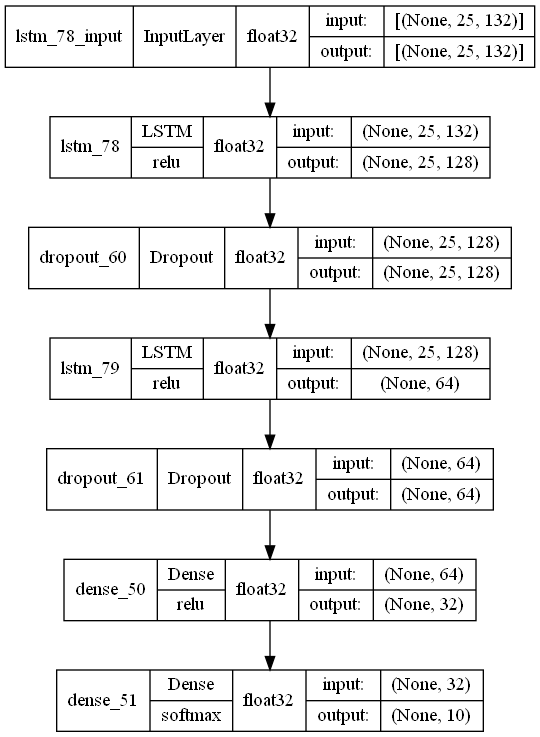

In [633]:
# Visualize weight
plot_model(lstm2_dense2_d_relu_mc_3,
           to_file = "arc_lstm2_dense2_d_relu_mc_3_e0190_val0.844.png",
           show_shapes = True,
           show_dtype=True,
           expand_nested=True,
           show_layer_activations=True)

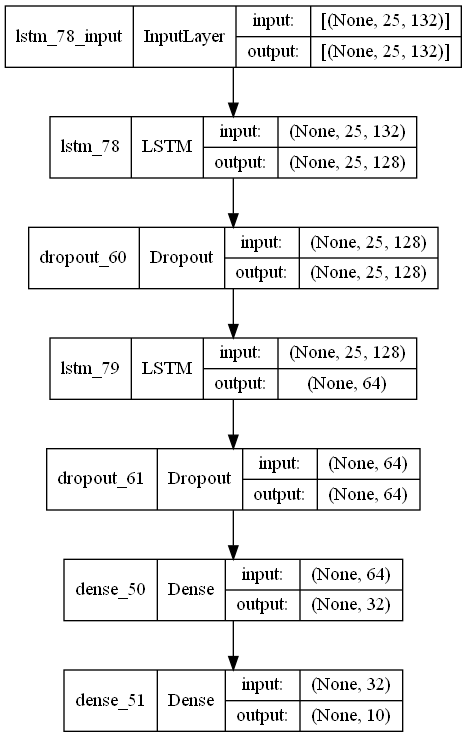

In [634]:
# Visualize
plot_model(lstm2_dense2_d_relu_mc_3, to_file = "arc_lstm2_dense2_d_relu_mc_3_0310_23032022.png", show_shapes = True)

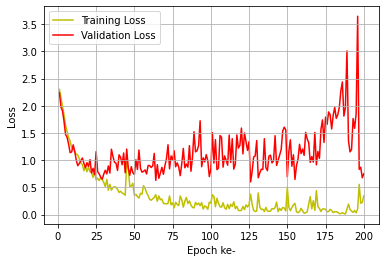

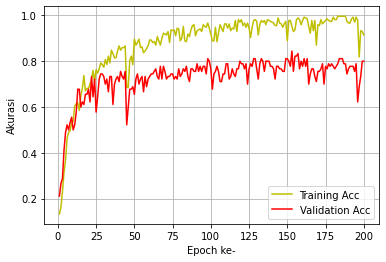

In [635]:
# Plot training and validation

loss3 = history3.history["loss"]
val_loss3 = history3.history["val_loss"]
epochs3 = range(1, len(loss3) + 1)
plt.plot(epochs3, loss3, "y", zorder=0, label="Training Loss")
plt.plot(epochs3, val_loss3, "r", zorder=0, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-") 
plt.ylabel("Loss")
plt.legend()
plt.show()

acc3 = history3.history["categorical_accuracy"]
val_acc3 = history3.history["val_categorical_accuracy"]
plt.plot(epochs3, acc3, "y", zorder=3, label="Training Acc")
plt.plot(epochs3, val_acc3, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Akurasi")
plt.legend()
plt.show()

In [6]:
df_3 = pd.read_csv("history/mine/csv/lstm2_dense2_d_relu_mc_3.csv")
df_3.head()

Unnamed: 0      loss  categorical_accuracy  val_loss  \
0           0  2.301985              0.133333  2.240108   
1           1  2.144784              0.162963  1.976807   
2           2  1.978111              0.233333  1.905830   
3           3  1.836389              0.314815  1.716833   
4           4  1.644028              0.366667  1.473277   

   val_categorical_accuracy  
0                  0.211111  
1                  0.266667  
2                  0.288889  
3                  0.411111  
4                  0.488889

In [8]:
df_3_processed = df_3.copy(deep=True)

df_3_processed["categorical_accuracy"] = df_3_processed["categorical_accuracy"]*100
df_3_processed["val_categorical_accuracy"] = df_3_processed["val_categorical_accuracy"]*100

df_3_processed

Unnamed: 0      loss  categorical_accuracy  val_loss  \
0             0  2.301985             13.333334  2.240108   
1             1  2.144784             16.296296  1.976807   
2             2  1.978111             23.333333  1.905830   
3             3  1.836389             31.481481  1.716833   
4             4  1.644028             36.666667  1.473277   
..          ...       ...                   ...       ...   
195         195  0.105185             97.777778  3.648510   
196         196  0.554970             81.851852  0.831191   
197         197  0.207982             93.333334  0.870040   
198         198  0.222981             92.962962  0.676607   
199         199  0.343644             91.481483  0.749621   

     val_categorical_accuracy  
0                   21.111111  
1                   26.666668  
2                   28.888890  
3                   41.111112  
4                   48.888889  
..                        ...  
195                 62.222224  
196                 68.888891  
197                 73.333335  
198                 80.000001  
199                 80.000001  

[200 rows x 5 columns]

In [10]:
df_3_processed = df_3_processed.rename(columns={"Unnamed: 0":"epoch"})
df_3_processed

epoch      loss  categorical_accuracy  val_loss  val_categorical_accuracy
0        0  2.301985             13.333334  2.240108                 21.111111
1        1  2.144784             16.296296  1.976807                 26.666668
2        2  1.978111             23.333333  1.905830                 28.888890
3        3  1.836389             31.481481  1.716833                 41.111112
4        4  1.644028             36.666667  1.473277                 48.888889
..     ...       ...                   ...       ...                       ...
195    195  0.105185             97.777778  3.648510                 62.222224
196    196  0.554970             81.851852  0.831191                 68.888891
197    197  0.207982             93.333334  0.870040                 73.333335
198    198  0.222981             92.962962  0.676607                 80.000001
199    199  0.343644             91.481483  0.749621                 80.000001

[200 rows x 5 columns]

In [23]:
epoch_old_3 = []
for l in range(200):
    epoch_old_3.append(l)
    
epoch_new_3 = []
for l in range(1, 201):
    epoch_new_3.append(l)
    
print(epoch_old_3)
print("")
print(epoch_new_3)

# unused

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 

In [25]:
df_3_processed["epoch"] = df_3_processed["epoch"].replace(epoch_old_3, epoch_new_3)
df_3_processed

# unused

epoch      loss  categorical_accuracy  val_loss  val_categorical_accuracy
0        1  2.301985             13.333334  2.240108                 21.111111
1        2  2.144784             16.296296  1.976807                 26.666668
2        3  1.978111             23.333333  1.905830                 28.888890
3        4  1.836389             31.481481  1.716833                 41.111112
4        5  1.644028             36.666667  1.473277                 48.888889
..     ...       ...                   ...       ...                       ...
195    196  0.105185             97.777778  3.648510                 62.222224
196    197  0.554970             81.851852  0.831191                 68.888891
197    198  0.207982             93.333334  0.870040                 73.333335
198    199  0.222981             92.962962  0.676607                 80.000001
199    200  0.343644             91.481483  0.749621                 80.000001

[200 rows x 5 columns]

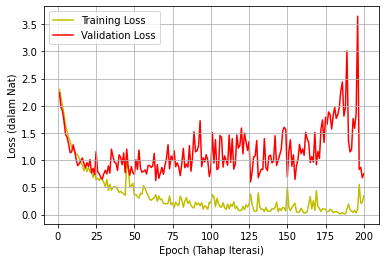

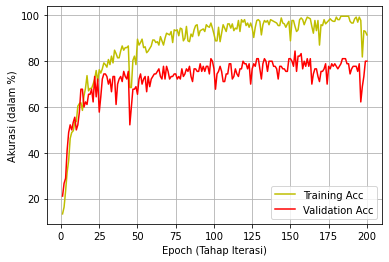

In [28]:
# Plot training and validation from csv file

loss3_2 = df_3_processed["loss"]
val_loss3_2 = df_3_processed["val_loss"]
epochs3_2 = range(1, len(loss3_2) + 1)
plt.plot(epochs3_2, loss3_2, "y", zorder=0, label="Training Loss")
plt.plot(epochs3_2, val_loss3_2, "r", zorder=0, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch (Tahap Iterasi)") 
plt.ylabel("Loss (dalam Nat)")
plt.legend()
plt.show()

acc3_2 = df_3_processed["categorical_accuracy"]
val_acc3_2 = df_3_processed["val_categorical_accuracy"]
plt.plot(epochs3_2, acc3_2, "y", zorder=3, label="Training Acc")
plt.plot(epochs3_2, val_acc3_2, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch (Tahap Iterasi)")
plt.ylabel("Akurasi (dalam %)")
plt.legend()
plt.show()

In [636]:
res3 = lstm2_dense2_d_relu_mc_3.predict(X_test)

In [637]:
yhat3 = lstm2_dense2_d_relu_mc_3.predict(X_test)
ytrue3 = np.argmax(y_test, axis=1).tolist()
yhat3 = np.argmax(yhat3, axis=1).tolist()

In [638]:
cm3 = confusion_matrix(y_true = ytrue3, y_pred = yhat3)

Confusion matrix, without normalization
[[7 1 1 0 0 0 0 0 0 0]
 [2 7 0 0 0 0 0 0 0 0]
 [6 0 3 0 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 1 0]
 [1 1 1 0 6 0 0 0 0 0]
 [0 0 0 0 0 9 0 0 0 0]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 2 0 0 0 0 7 0]
 [0 0 0 0 0 0 0 0 0 9]]


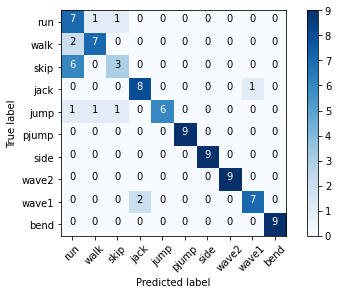

In [668]:
cm_plot_labels3 = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm3, classes = cm_plot_labels3, title = "")

In [640]:
fp3 = cm3.sum(axis=0) - np.diag(cm3)  
fn3 = cm3.sum(axis=1) - np.diag(cm3)
tp3 = np.diag(cm3)
tn3 = cm3.sum() - (fp3 + fn3 + tp3)

print(fp2,fn2,tp2,tn2)

[8 3 6 1 0 0 1 0 0 0] [7 2 6 0 2 1 0 0 1 0] [2 7 3 9 7 8 9 9 8 9] [73 78 75 80 81 81 80 81 81 81]


In [641]:
print(tp3)
print(fp3)
print(tn3)
print(fn3)

[7 7 3 8 6 9 9 9 7 9]
[9 2 2 2 0 0 0 0 1 0]
[72 79 79 79 81 81 81 81 80 81]
[2 2 6 1 3 0 0 0 2 0]


In [642]:
y_pred3 = lstm2_dense2_d_relu_mc_3.predict(X_test)
y_pred3 = (y_pred3 > 0.5)

In [648]:
_, acc3 = lstm2_dense2_d_relu_mc_3.evaluate(X_test, y_test)
print("Accuracy = ", (acc3*100), " %")

3/3 [==============================] - 0s 30ms/step - loss: 0.7209 - categorical_accuracy: 0.8222
Accuracy =  82.22222328186035  %


In [644]:
loss3_2, acc3_2 = lstm2_dense2_d_relu_mc_3.evaluate(X_train, y_train)
loss3_3, acc3_3 = lstm2_dense2_d_relu_mc_3.evaluate(X_valid, y_valid)

print("Accuracy2 = ", (acc1_2*100), " %")
print("Accuracy3 = ", (acc1_3*100), " %")

3/3 [==============================] - 0s 31ms/step - loss: 0.8884 - categorical_accuracy: 0.8444
Accuracy2 =  99.62962865829468  %
Accuracy3 =  75.55555701255798  %


In [645]:
acc3 = accuracy_score(ytrue3, yhat3)
acc3

0.8222222222222222

In [646]:
# Error rate
error_rate3 = 1 - acc3
error_rate3

0.1777777777777778

In [776]:
# Hamming loss
error_rate3 = hamming_loss(ytrue3, yhat3)
error_rate3

0.17777777777777778

In [647]:
print(classification_report(
    ytrue3,
    yhat3,
    output_dict=False,
    target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.44      0.78      0.56         9
        walk       0.78      0.78      0.78         9
        skip       0.60      0.33      0.43         9
        jack       0.80      0.89      0.84         9
        jump       1.00      0.67      0.80         9
       pjump       1.00      1.00      1.00         9
        side       1.00      1.00      1.00         9
       wave2       1.00      1.00      1.00         9
       wave1       0.88      0.78      0.82         9
        bend       1.00      1.00      1.00         9

    accuracy                           0.82        90
   macro avg       0.85      0.82      0.82        90
weighted avg       0.85      0.82      0.82        90



# lstm2_dense2_rd_lr5_75_b2_relu_mc_1
lstm2 (128,64) + dense2 (32,10) + activation=relu + nadam + epochs=200 + recurrent_dropout + lr=0.000075 + batch=2 + ModelCheckpoint -> train:26min 7s, test:77,77%
#### Model 2 1st

In [127]:
# Define a sequential model
lstm2_dense2_rd_lr5_75_b2_relu_mc_1 = Sequential([
    LSTM(128, recurrent_dropout=0.25, return_sequences=True, activation="relu", input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.25, return_sequences=False, activation="relu"),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [128]:
# Compile model with learning rate
lstm2_dense2_rd_lr5_75_b2_relu_mc_1.compile(Nadam(learning_rate=0.000075),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [129]:
# Model Checkpoint Callback - reconfig

checkpoint_filepath4 = os.path.join("tmp/mc_lstm2_dense2_rd_lr5_75_b2_relu_mc_1_e{epoch:04d}_val{val_categorical_accuracy:.3f}.h5")

mc_val_acc = ModelCheckpoint(filepath = checkpoint_filepath4,
                             monitor="val_categorical_accuracy",
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode="max",
                             save_freq="epoch")

In [130]:
%%time
# Training model with validation
history4 = lstm2_dense2_rd_lr5_75_b2_relu_mc_1.fit(X_train, y_train, batch_size=2, epochs=200, shuffle=True, verbose=2,
                                          validation_data=(X_valid, y_valid), callbacks=[mc_val_acc])

Epoch 1/200

Epoch 00001: val_categorical_accuracy improved from -inf to 0.12222, saving model to tmp\mc_lstm2_dense2_rd_lr5_75_b2_relu_mc_1_e0001_val0.122.h5
135/135 - 15s - loss: 2.2963 - categorical_accuracy: 0.1519 - val_loss: 2.2231 - val_categorical_accuracy: 0.1222 - 15s/epoch - 109ms/step
Epoch 2/200

Epoch 00002: val_categorical_accuracy improved from 0.12222 to 0.34444, saving model to tmp\mc_lstm2_dense2_rd_lr5_75_b2_relu_mc_1_e0002_val0.344.h5
135/135 - 8s - loss: 2.0416 - categorical_accuracy: 0.1741 - val_loss: 1.7885 - val_categorical_accuracy: 0.3444 - 8s/epoch - 62ms/step
Epoch 3/200

Epoch 00003: val_categorical_accuracy did not improve from 0.34444
135/135 - 7s - loss: 1.7540 - categorical_accuracy: 0.3296 - val_loss: 1.6371 - val_categorical_accuracy: 0.3222 - 7s/epoch - 55ms/step
Epoch 4/200

Epoch 00004: val_categorical_accuracy did not improve from 0.34444
135/135 - 10s - loss: 1.6149 - categorical_accuracy: 0.3778 - val_loss: 1.5114 - val_categorical_accuracy: 0

Epoch 36/200

Epoch 00036: val_categorical_accuracy did not improve from 0.76667
135/135 - 7s - loss: 0.5424 - categorical_accuracy: 0.8037 - val_loss: 0.7628 - val_categorical_accuracy: 0.7111 - 7s/epoch - 55ms/step
Epoch 37/200

Epoch 00037: val_categorical_accuracy did not improve from 0.76667
135/135 - 8s - loss: 0.4650 - categorical_accuracy: 0.8407 - val_loss: 0.6657 - val_categorical_accuracy: 0.7333 - 8s/epoch - 58ms/step
Epoch 38/200

Epoch 00038: val_categorical_accuracy did not improve from 0.76667
135/135 - 8s - loss: 0.3897 - categorical_accuracy: 0.8481 - val_loss: 0.7478 - val_categorical_accuracy: 0.6889 - 8s/epoch - 59ms/step
Epoch 39/200

Epoch 00039: val_categorical_accuracy did not improve from 0.76667
135/135 - 8s - loss: 0.3952 - categorical_accuracy: 0.8556 - val_loss: 0.6607 - val_categorical_accuracy: 0.7000 - 8s/epoch - 60ms/step
Epoch 40/200

Epoch 00040: val_categorical_accuracy did not improve from 0.76667
135/135 - 8s - loss: 0.4202 - categorical_accuracy:

Epoch 73/200

Epoch 00073: val_categorical_accuracy did not improve from 0.82222
135/135 - 7s - loss: 0.2241 - categorical_accuracy: 0.9148 - val_loss: 0.7923 - val_categorical_accuracy: 0.7444 - 7s/epoch - 54ms/step
Epoch 74/200

Epoch 00074: val_categorical_accuracy did not improve from 0.82222
135/135 - 8s - loss: 0.2187 - categorical_accuracy: 0.9185 - val_loss: 0.7883 - val_categorical_accuracy: 0.7778 - 8s/epoch - 60ms/step
Epoch 75/200

Epoch 00075: val_categorical_accuracy did not improve from 0.82222
135/135 - 8s - loss: 0.2563 - categorical_accuracy: 0.9074 - val_loss: 0.8653 - val_categorical_accuracy: 0.7889 - 8s/epoch - 57ms/step
Epoch 76/200

Epoch 00076: val_categorical_accuracy did not improve from 0.82222
135/135 - 8s - loss: 0.1785 - categorical_accuracy: 0.9185 - val_loss: 0.9699 - val_categorical_accuracy: 0.7111 - 8s/epoch - 62ms/step
Epoch 77/200

Epoch 00077: val_categorical_accuracy did not improve from 0.82222
135/135 - 8s - loss: 0.2327 - categorical_accuracy:

Epoch 111/200

Epoch 00111: val_categorical_accuracy did not improve from 0.82222
135/135 - 7s - loss: 0.1601 - categorical_accuracy: 0.9444 - val_loss: 0.7707 - val_categorical_accuracy: 0.7556 - 7s/epoch - 55ms/step
Epoch 112/200

Epoch 00112: val_categorical_accuracy did not improve from 0.82222
135/135 - 8s - loss: 0.1145 - categorical_accuracy: 0.9630 - val_loss: 0.7080 - val_categorical_accuracy: 0.7778 - 8s/epoch - 57ms/step
Epoch 113/200

Epoch 00113: val_categorical_accuracy did not improve from 0.82222
135/135 - 8s - loss: 0.2270 - categorical_accuracy: 0.9222 - val_loss: 0.8665 - val_categorical_accuracy: 0.7778 - 8s/epoch - 58ms/step
Epoch 114/200

Epoch 00114: val_categorical_accuracy did not improve from 0.82222
135/135 - 8s - loss: 0.1177 - categorical_accuracy: 0.9593 - val_loss: 0.8323 - val_categorical_accuracy: 0.7444 - 8s/epoch - 59ms/step
Epoch 115/200

Epoch 00115: val_categorical_accuracy did not improve from 0.82222
135/135 - 8s - loss: 0.1906 - categorical_accu

Epoch 149/200

Epoch 00149: val_categorical_accuracy did not improve from 0.83333
135/135 - 7s - loss: 0.0589 - categorical_accuracy: 0.9852 - val_loss: 0.9250 - val_categorical_accuracy: 0.7889 - 7s/epoch - 52ms/step
Epoch 150/200

Epoch 00150: val_categorical_accuracy did not improve from 0.83333
135/135 - 7s - loss: 0.0367 - categorical_accuracy: 0.9963 - val_loss: 1.0495 - val_categorical_accuracy: 0.8000 - 7s/epoch - 52ms/step
Epoch 151/200

Epoch 00151: val_categorical_accuracy did not improve from 0.83333
135/135 - 7s - loss: 0.4034 - categorical_accuracy: 0.8963 - val_loss: 0.9144 - val_categorical_accuracy: 0.7556 - 7s/epoch - 51ms/step
Epoch 152/200

Epoch 00152: val_categorical_accuracy did not improve from 0.83333
135/135 - 7s - loss: 0.1612 - categorical_accuracy: 0.9593 - val_loss: 1.2819 - val_categorical_accuracy: 0.7444 - 7s/epoch - 51ms/step
Epoch 153/200

Epoch 00153: val_categorical_accuracy did not improve from 0.83333
135/135 - 7s - loss: 0.1870 - categorical_accu

Epoch 187/200

Epoch 00187: val_categorical_accuracy did not improve from 0.83333
135/135 - 7s - loss: 0.1021 - categorical_accuracy: 0.9667 - val_loss: 0.9157 - val_categorical_accuracy: 0.7556 - 7s/epoch - 51ms/step
Epoch 188/200

Epoch 00188: val_categorical_accuracy did not improve from 0.83333
135/135 - 7s - loss: 0.1263 - categorical_accuracy: 0.9593 - val_loss: 1.1406 - val_categorical_accuracy: 0.8000 - 7s/epoch - 51ms/step
Epoch 189/200

Epoch 00189: val_categorical_accuracy did not improve from 0.83333
135/135 - 7s - loss: 0.0753 - categorical_accuracy: 0.9704 - val_loss: 0.9857 - val_categorical_accuracy: 0.7889 - 7s/epoch - 51ms/step
Epoch 190/200

Epoch 00190: val_categorical_accuracy did not improve from 0.83333
135/135 - 7s - loss: 0.0471 - categorical_accuracy: 0.9815 - val_loss: 0.9515 - val_categorical_accuracy: 0.7889 - 7s/epoch - 51ms/step
Epoch 191/200

Epoch 00191: val_categorical_accuracy did not improve from 0.83333
135/135 - 7s - loss: 0.1623 - categorical_accu

In [131]:
# Save history to json and csv

# convert the history1.history dict to a pandas DataFrame:     
hist_df_4 = pd.DataFrame(history4.history) 

# save to json:  
hist_json_file_4 = 'history/mine/json/lstm2_dense2_rd_lr5_75_b2_relu_mc_1.json' 
with open(hist_json_file_4, mode='w') as f:
    hist_df_4.to_json(f)

# or save to csv: 
hist_csv_file_4 = 'history/mine/csv/lstm2_dense2_rd_lr5_75_b2_relu_mc_1.csv'
with open(hist_csv_file_4, mode='w') as f:
    hist_df_4.to_csv(f)

In [ ]:
lstm2_dense2_rd_lr5_75_b2_relu_mc_1.summary()

In [132]:
# Load Model
lstm2_dense2_rd_lr5_75_b2_relu_mc_1.load_weights("tmp\mc_lstm2_dense2_rd_lr5_75_b2_relu_mc_1_e0124_val0.833.h5")

In [40]:
# Save Model
lstm2_dense2_rd_lr5_75_b2_relu_mc_1.save("model2\lstm2_dense2_rd_lr5_75_b2_relu_mc_2_e0112_val0.844.h5")

In [ ]:
# Visualize
plot_model(lstm2_dense2_rd_lr5_75_b2_relu_mc_1, to_file = "arc_lstm2_dense2_rd_lr5_75_b2_relu_mc_2_2036_23032022.png", show_shapes = True)

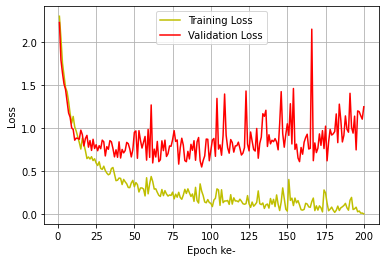

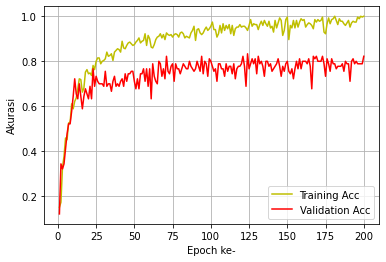

In [134]:
# Plot training and validation

loss4 = history4.history["loss"]
val_loss4 = history4.history["val_loss"]
epochs4 = range(1, len(loss4) + 1)
plt.plot(epochs4, loss4, "y", zorder=3, label="Training Loss")
plt.plot(epochs4, val_loss4, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc4 = history4.history["categorical_accuracy"]
val_acc4 = history4.history["val_categorical_accuracy"]
plt.plot(epochs4, acc4, "y", zorder=3, label="Training Acc")
plt.plot(epochs4, val_acc4, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Akurasi")
plt.legend()
plt.show()

In [135]:
res4 = lstm2_dense2_rd_lr5_75_b2_relu_mc_1.predict(X_test)

In [137]:
yhat4 = lstm2_dense2_rd_lr5_75_b2_relu_mc_1.predict(X_test)
ytrue4 = np.argmax(y_test, axis=1).tolist()
yhat4 = np.argmax(yhat4, axis=1).tolist()

Confusion matrix, without normalization
[[3 2 4 0 0 0 0 0 0 0]
 [3 5 0 0 1 0 0 0 0 0]
 [5 1 3 0 0 0 0 0 0 0]
 [0 0 0 9 0 0 0 0 0 0]
 [1 0 1 0 7 0 0 0 0 0]
 [0 0 0 0 0 8 1 0 0 0]
 [0 1 0 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 0 9 0]
 [0 0 0 0 0 0 0 0 0 9]]


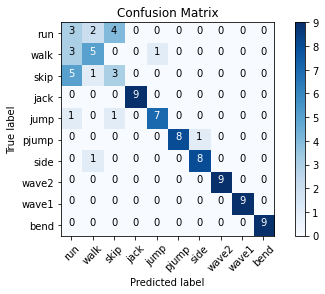

In [138]:
cm4 = confusion_matrix(y_true = ytrue4, y_pred = yhat4)
cm_plot_labels4 = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm4, classes = cm_plot_labels4, title = "Confusion Matrix")

In [139]:
fp4 = cm4.sum(axis=0) - np.diag(cm4)  
fn4 = cm4.sum(axis=1) - np.diag(cm4)
tp4 = np.diag(cm4)
tn4 = cm4.sum() - (fp4 + fn4 + tp4)

print(tp4)
print(fp4)
print(tn4)
print(fn4)

[3 5 3 9 7 8 8 9 9 9]
[9 4 5 0 1 0 1 0 0 0]
[72 77 76 81 80 81 80 81 81 81]
[6 4 6 0 2 1 1 0 0 0]


In [140]:
y_pred4 = lstm2_dense2_rd_lr5_75_b2_relu_mc_1.predict(X_test)
y_pred4 = (y_pred4 > 0.5)

In [141]:
_, acc4 = lstm2_dense2_rd_lr5_75_b2_relu_mc_1.evaluate(X_test, y_test)
print("Accuracy = ", (acc4*100), " %")

3/3 [==============================] - 1s 18ms/step - loss: 1.0084 - categorical_accuracy: 0.7778
Accuracy =  77.77777910232544  %


In [142]:
loss4_2, acc4_2 = lstm2_dense2_rd_lr5_75_b2_relu_mc_1.evaluate(X_train, y_train)
loss4_3, acc4_3 = lstm2_dense2_rd_lr5_75_b2_relu_mc_1.evaluate(X_valid, y_valid)

print("Accuracy2 = ", (acc4_2*100), " %")
print("Accuracy3 = ", (acc4_3*100), " %")

3/3 [==============================] - 0s 16ms/step - loss: 0.8145 - categorical_accuracy: 0.8333
Accuracy2 =  99.62962865829468  %
Accuracy3 =  83.33333134651184  %


In [143]:
accuracy_score(ytrue4, yhat4)

0.7777777777777778

In [144]:
acc4 = accuracy_score(ytrue4, yhat4)
acc4

0.7777777777777778

In [145]:
# Error rate
error_rate4 = 1 - acc4
error_rate4

0.2222222222222222

In [146]:
print(classification_report(
      ytrue4,
      yhat4,
      output_dict=False,
      target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.25      0.33      0.29         9
        walk       0.56      0.56      0.56         9
        skip       0.38      0.33      0.35         9
        jack       1.00      1.00      1.00         9
        jump       0.88      0.78      0.82         9
       pjump       1.00      0.89      0.94         9
        side       0.89      0.89      0.89         9
       wave2       1.00      1.00      1.00         9
       wave1       1.00      1.00      1.00         9
        bend       1.00      1.00      1.00         9

    accuracy                           0.78        90
   macro avg       0.79      0.78      0.78        90
weighted avg       0.79      0.78      0.78        90



# lstm2_dense2_rd_lr5_75_b2_relu_mc_2
lstm2 (128,64) + dense2 (32,10) + activation=relu + nadam + epochs=200 + recurrent_dropout + lr=0.000075 + batch=2 + ModelCheckpoint -> train:54min 13s, 80%
#### Model 2 2nd (Chosen)

In [706]:
# Define a sequential model
lstm2_dense2_rd_lr5_75_b2_relu_mc_2 = Sequential([
    LSTM(128, recurrent_dropout=0.25, return_sequences=True, activation="relu", input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.25, return_sequences=False, activation="relu"),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [707]:
# Compile model with learning rate
lstm2_dense2_rd_lr5_75_b2_relu_mc_2.compile(Nadam(learning_rate=0.000075),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [708]:
# Model Checkpoint Callback - reconfig

checkpoint_filepath5 = os.path.join("tmp/mc_lstm2_dense2_rd_lr5_75_b2_relu_mc_2_e{epoch:04d}_val{val_categorical_accuracy:.3f}.h5")

mc_val_acc = ModelCheckpoint(filepath = checkpoint_filepath5,
                             monitor="val_categorical_accuracy",
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode="max",
                             save_freq="epoch")

In [709]:
%%time
# Training model with validation
history5 = lstm2_dense2_rd_lr5_75_b2_relu_mc_2.fit(X_train, y_train, batch_size=2, epochs=200, shuffle=True, verbose=2,
                                          validation_data=(X_valid, y_valid), callbacks=[mc_val_acc])

Epoch 1/200

Epoch 00001: val_categorical_accuracy improved from -inf to 0.14444, saving model to tmp\mc_lstm2_dense2_rd_lr5_75_b2_relu_mc_2_e0001_val0.144.h5
135/135 - 64s - loss: 2.2563 - categorical_accuracy: 0.1296 - val_loss: 2.1455 - val_categorical_accuracy: 0.1444 - 64s/epoch - 473ms/step
Epoch 2/200

Epoch 00002: val_categorical_accuracy improved from 0.14444 to 0.24444, saving model to tmp\mc_lstm2_dense2_rd_lr5_75_b2_relu_mc_2_e0002_val0.244.h5
135/135 - 16s - loss: 2.0303 - categorical_accuracy: 0.2370 - val_loss: 1.8808 - val_categorical_accuracy: 0.2444 - 16s/epoch - 119ms/step
Epoch 3/200

Epoch 00003: val_categorical_accuracy improved from 0.24444 to 0.41111, saving model to tmp\mc_lstm2_dense2_rd_lr5_75_b2_relu_mc_2_e0003_val0.411.h5
135/135 - 16s - loss: 1.8318 - categorical_accuracy: 0.3630 - val_loss: 1.6878 - val_categorical_accuracy: 0.4111 - 16s/epoch - 118ms/step
Epoch 4/200

Epoch 00004: val_categorical_accuracy improved from 0.41111 to 0.46667, saving model to

Epoch 35/200

Epoch 00035: val_categorical_accuracy did not improve from 0.74444
135/135 - 16s - loss: 0.4694 - categorical_accuracy: 0.8407 - val_loss: 0.6829 - val_categorical_accuracy: 0.6889 - 16s/epoch - 117ms/step
Epoch 36/200

Epoch 00036: val_categorical_accuracy did not improve from 0.74444
135/135 - 16s - loss: 0.4946 - categorical_accuracy: 0.8259 - val_loss: 0.7154 - val_categorical_accuracy: 0.7333 - 16s/epoch - 116ms/step
Epoch 37/200

Epoch 00037: val_categorical_accuracy did not improve from 0.74444
135/135 - 16s - loss: 0.4166 - categorical_accuracy: 0.8333 - val_loss: 0.6485 - val_categorical_accuracy: 0.6889 - 16s/epoch - 120ms/step
Epoch 38/200

Epoch 00038: val_categorical_accuracy did not improve from 0.74444
135/135 - 16s - loss: 0.3804 - categorical_accuracy: 0.8333 - val_loss: 0.6386 - val_categorical_accuracy: 0.6778 - 16s/epoch - 117ms/step
Epoch 39/200

Epoch 00039: val_categorical_accuracy improved from 0.74444 to 0.75556, saving model to tmp\mc_lstm2_dense

Epoch 72/200

Epoch 00072: val_categorical_accuracy did not improve from 0.80000
135/135 - 16s - loss: 0.3118 - categorical_accuracy: 0.8741 - val_loss: 0.6348 - val_categorical_accuracy: 0.7889 - 16s/epoch - 116ms/step
Epoch 73/200

Epoch 00073: val_categorical_accuracy did not improve from 0.80000
135/135 - 16s - loss: 0.2046 - categorical_accuracy: 0.9296 - val_loss: 0.5770 - val_categorical_accuracy: 0.7778 - 16s/epoch - 116ms/step
Epoch 74/200

Epoch 00074: val_categorical_accuracy did not improve from 0.80000
135/135 - 16s - loss: 0.2231 - categorical_accuracy: 0.9037 - val_loss: 0.5401 - val_categorical_accuracy: 0.8000 - 16s/epoch - 116ms/step
Epoch 75/200

Epoch 00075: val_categorical_accuracy did not improve from 0.80000
135/135 - 16s - loss: 0.2367 - categorical_accuracy: 0.9111 - val_loss: 0.5531 - val_categorical_accuracy: 0.7778 - 16s/epoch - 117ms/step
Epoch 76/200

Epoch 00076: val_categorical_accuracy did not improve from 0.80000
135/135 - 16s - loss: 0.2442 - categori

Epoch 109/200

Epoch 00109: val_categorical_accuracy did not improve from 0.81111
135/135 - 16s - loss: 0.0831 - categorical_accuracy: 0.9741 - val_loss: 1.5940 - val_categorical_accuracy: 0.7889 - 16s/epoch - 120ms/step
Epoch 110/200

Epoch 00110: val_categorical_accuracy did not improve from 0.81111
135/135 - 18s - loss: 0.2310 - categorical_accuracy: 0.9407 - val_loss: 0.7309 - val_categorical_accuracy: 0.8000 - 18s/epoch - 133ms/step
Epoch 111/200

Epoch 00111: val_categorical_accuracy did not improve from 0.81111
135/135 - 16s - loss: 0.2015 - categorical_accuracy: 0.9296 - val_loss: 0.8009 - val_categorical_accuracy: 0.7333 - 16s/epoch - 116ms/step
Epoch 112/200

Epoch 00112: val_categorical_accuracy did not improve from 0.81111
135/135 - 16s - loss: 0.1612 - categorical_accuracy: 0.9593 - val_loss: 0.7313 - val_categorical_accuracy: 0.7778 - 16s/epoch - 117ms/step
Epoch 113/200

Epoch 00113: val_categorical_accuracy improved from 0.81111 to 0.83333, saving model to tmp\mc_lstm2_

Epoch 146/200

Epoch 00146: val_categorical_accuracy did not improve from 0.83333
135/135 - 16s - loss: 0.1105 - categorical_accuracy: 0.9704 - val_loss: 0.6519 - val_categorical_accuracy: 0.7778 - 16s/epoch - 118ms/step
Epoch 147/200

Epoch 00147: val_categorical_accuracy did not improve from 0.83333
135/135 - 16s - loss: 0.1141 - categorical_accuracy: 0.9556 - val_loss: 0.8440 - val_categorical_accuracy: 0.7667 - 16s/epoch - 118ms/step
Epoch 148/200

Epoch 00148: val_categorical_accuracy did not improve from 0.83333
135/135 - 16s - loss: 0.1329 - categorical_accuracy: 0.9556 - val_loss: 1.0092 - val_categorical_accuracy: 0.7444 - 16s/epoch - 119ms/step
Epoch 149/200

Epoch 00149: val_categorical_accuracy did not improve from 0.83333
135/135 - 19s - loss: 0.1237 - categorical_accuracy: 0.9704 - val_loss: 0.7978 - val_categorical_accuracy: 0.7667 - 19s/epoch - 138ms/step
Epoch 150/200

Epoch 00150: val_categorical_accuracy did not improve from 0.83333
135/135 - 16s - loss: 0.0653 - cat

Epoch 184/200

Epoch 00184: val_categorical_accuracy did not improve from 0.83333
135/135 - 16s - loss: 0.1049 - categorical_accuracy: 0.9704 - val_loss: 0.7034 - val_categorical_accuracy: 0.8000 - 16s/epoch - 116ms/step
Epoch 185/200

Epoch 00185: val_categorical_accuracy did not improve from 0.83333
135/135 - 16s - loss: 0.0243 - categorical_accuracy: 0.9963 - val_loss: 1.0345 - val_categorical_accuracy: 0.7889 - 16s/epoch - 117ms/step
Epoch 186/200

Epoch 00186: val_categorical_accuracy did not improve from 0.83333
135/135 - 16s - loss: 0.1135 - categorical_accuracy: 0.9630 - val_loss: 1.0513 - val_categorical_accuracy: 0.7222 - 16s/epoch - 116ms/step
Epoch 187/200

Epoch 00187: val_categorical_accuracy did not improve from 0.83333
135/135 - 16s - loss: 0.1537 - categorical_accuracy: 0.9556 - val_loss: 0.6620 - val_categorical_accuracy: 0.8111 - 16s/epoch - 116ms/step
Epoch 188/200

Epoch 00188: val_categorical_accuracy did not improve from 0.83333
135/135 - 16s - loss: 0.0467 - cat

In [710]:
# Save history to json and csv

# convert the history1.history dict to a pandas DataFrame:     
hist_df_5 = pd.DataFrame(history5.history) 

# save to json:  
hist_json_file_5 = 'history/mine/json/lstm2_dense2_rd_lr5_75_b2_relu_mc_2.json' 
with open(hist_json_file_5, mode='w') as f:
    hist_df_5.to_json(f)

# or save to csv: 
hist_csv_file_5 = 'history/mine/csv/lstm2_dense2_rd_lr5_75_b2_relu_mc_2.csv'
with open(hist_csv_file_5, mode='w') as f:
    hist_df_5.to_csv(f)

In [ ]:
lstm2_dense2_rd_lr5_75_b2_relu_mc_2.summary()

In [711]:
# Load Model
lstm2_dense2_rd_lr5_75_b2_relu_mc_2.load_weights("tmp\mc_lstm2_dense2_rd_lr5_75_b2_relu_mc_2_e0194_val0.856.h5")

In [753]:
# Save Model
lstm2_dense2_rd_lr5_75_b2_relu_mc_2.save("model/mine/lstm2_dense2_rd_lr5_75_b2_relu_mc_2_e0194_val0.856.h5")

In [ ]:
# Visualize
plot_model(lstm2_dense2_rd_lr5_75_b2_relu_mc_2, to_file = "arc_lstm2_dense2_rd_lr5_75_b2_relu_mc_2_2036_23032022.png", show_shapes = True)

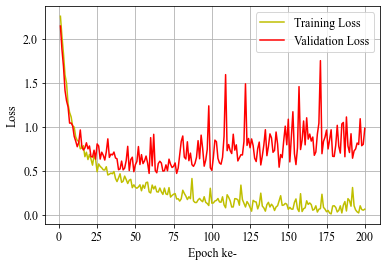

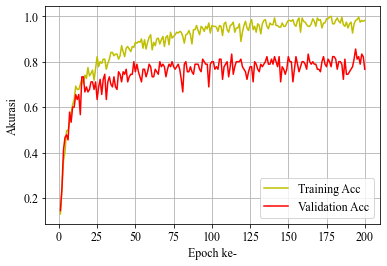

In [760]:
# Plot training and validation

loss5 = history5.history["loss"]
val_loss5 = history5.history["val_loss"]
epochs5 = range(1, len(loss5) + 1)
plt.plot(epochs5, loss5, "y", zorder=3, label="Training Loss")
plt.plot(epochs5, val_loss5, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc5 = history5.history["categorical_accuracy"]
val_acc5 = history5.history["val_categorical_accuracy"]
plt.plot(epochs5, acc5, "y", zorder=3, label="Training Acc")
plt.plot(epochs5, val_acc5, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Akurasi")
plt.legend()
plt.show()

In [29]:
df_5 = pd.read_csv("history/mine/csv/lstm2_dense2_rd_lr5_75_b2_relu_mc_2.csv")
df_5.head()

Unnamed: 0      loss  categorical_accuracy  val_loss  \
0           0  2.256287              0.129630  2.145486   
1           1  2.030267              0.237037  1.880836   
2           2  1.831796              0.362963  1.687818   
3           3  1.590551              0.403704  1.414484   
4           4  1.497192              0.496296  1.297004   

   val_categorical_accuracy  
0                  0.144444  
1                  0.244444  
2                  0.411111  
3                  0.466667  
4                  0.477778

In [30]:
df_5_processed = df_5.copy(deep=True)

df_5_processed["categorical_accuracy"] = df_5_processed["categorical_accuracy"]*100
df_5_processed["val_categorical_accuracy"] = df_5_processed["val_categorical_accuracy"]*100

df_5_processed

Unnamed: 0      loss  categorical_accuracy  val_loss  \
0             0  2.256287             12.962963  2.145486   
1             1  2.030267             23.703703  1.880836   
2             2  1.831796             36.296296  1.687818   
3             3  1.590551             40.370369  1.414484   
4             4  1.497192             49.629629  1.297004   
..          ...       ...                   ...       ...   
195         195  0.024583             99.629629  0.801329   
196         196  0.105437             97.407407  1.093622   
197         197  0.063192             98.148149  0.787484   
198         198  0.055438             97.777778  0.803256   
199         199  0.067435             98.148149  0.985609   

     val_categorical_accuracy  
0                   14.444445  
1                   24.444444  
2                   41.111112  
3                   46.666667  
4                   47.777778  
..                        ...  
195                 82.222223  
196                 78.888887  
197                 83.333331  
198                 82.222223  
199                 76.666665  

[200 rows x 5 columns]

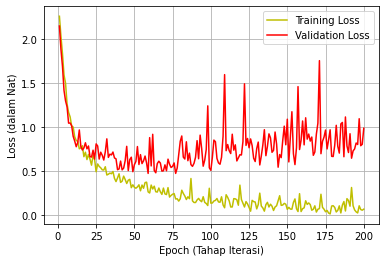

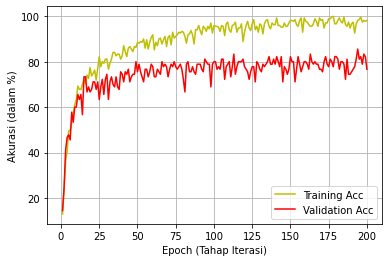

In [31]:
# Plot training and validation

loss5_2 = df_5_processed["loss"]
val_loss5_2 = df_5_processed["val_loss"]
epochs5_2 = range(1, len(loss5_2) + 1)
plt.plot(epochs5_2, loss5_2, "y", zorder=3, label="Training Loss")
plt.plot(epochs5_2, val_loss5_2, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch (Tahap Iterasi)")
plt.ylabel("Loss (dalam Nat)")
plt.legend()
plt.show()

acc5_2 = df_5_processed["categorical_accuracy"]
val_acc5_2 = df_5_processed["val_categorical_accuracy"]
plt.plot(epochs5_2, acc5_2, "y", zorder=3, label="Training Acc")
plt.plot(epochs5_2, val_acc5_2, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch (Tahap Iterasi)")
plt.ylabel("Akurasi (dalam %)")
plt.legend()
plt.show()

In [713]:
res5 = lstm2_dense2_rd_lr5_75_b2_relu_mc_2.predict(X_test)

In [714]:
yhat5 = lstm2_dense2_rd_lr5_75_b2_relu_mc_2.predict(X_test)
ytrue5 = np.argmax(y_test, axis=1).tolist()
yhat5 = np.argmax(yhat5, axis=1).tolist()

Confusion matrix, without normalization
[[3 1 5 0 0 0 0 0 0 0]
 [1 6 1 0 1 0 0 0 0 0]
 [3 1 5 0 0 0 0 0 0 0]
 [0 0 0 9 0 0 0 0 0 0]
 [0 0 2 0 6 0 0 0 0 1]
 [0 0 0 0 0 9 0 0 0 0]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 2 0 0 0 0 7 0]
 [0 0 0 0 0 0 0 0 0 9]]


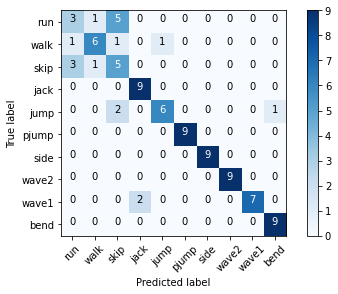

In [715]:
cm5 = confusion_matrix(y_true = ytrue5, y_pred = yhat5)
cm_plot_labels5 = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm5, classes = cm_plot_labels5, title = "")

In [716]:
fp5 = cm5.sum(axis=0) - np.diag(cm5)  
fn5 = cm5.sum(axis=1) - np.diag(cm5)
tp5 = np.diag(cm5)
tn5 = cm5.sum() - (fp5 + fn5 + tp5)

print(tp5)
print(fp5)
print(tn5)
print(fn5)

[3 6 5 9 6 9 9 9 7 9]
[4 2 8 2 1 0 0 0 0 1]
[77 79 73 79 80 81 81 81 81 80]
[6 3 4 0 3 0 0 0 2 0]


In [717]:
y_pred5 = lstm2_dense2_rd_lr5_75_b2_relu_mc_2.predict(X_test)
y_pred5 = (y_pred5 > 0.5)

In [718]:
_, acc5 = lstm2_dense2_rd_lr5_75_b2_relu_mc_2.evaluate(X_test, y_test)
print("Accuracy = ", (acc5*100), " %")

3/3 [==============================] - 1s 75ms/step - loss: 0.8730 - categorical_accuracy: 0.8000
Accuracy =  80.0000011920929  %


In [719]:
loss5_2, acc5_2 = lstm2_dense2_rd_lr5_75_b2_relu_mc_2.evaluate(X_train, y_train)
loss5_3, acc5_3 = lstm2_dense2_rd_lr5_75_b2_relu_mc_2.evaluate(X_valid, y_valid)

print("Accuracy2 = ", (acc5_2*100), " %")
print("Accuracy3 = ", (acc5_3*100), " %")

3/3 [==============================] - 0s 73ms/step - loss: 0.7505 - categorical_accuracy: 0.8556
Accuracy2 =  99.25925731658936  %
Accuracy3 =  85.5555534362793  %


In [720]:
accuracy_score(ytrue5, yhat5)

0.8

In [721]:
acc5 = accuracy_score(ytrue5, yhat5)
acc5

0.8

In [722]:
# Error rate
error_rate5 = 1 - acc5
error_rate5

0.19999999999999996

In [723]:
print(classification_report(
      ytrue5,
      yhat5,
      output_dict=False,
      target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.43      0.33      0.38         9
        walk       0.75      0.67      0.71         9
        skip       0.38      0.56      0.45         9
        jack       0.82      1.00      0.90         9
        jump       0.86      0.67      0.75         9
       pjump       1.00      1.00      1.00         9
        side       1.00      1.00      1.00         9
       wave2       1.00      1.00      1.00         9
       wave1       1.00      0.78      0.88         9
        bend       0.90      1.00      0.95         9

    accuracy                           0.80        90
   macro avg       0.81      0.80      0.80        90
weighted avg       0.81      0.80      0.80        90



# lstm2_dense2_rd_lr5_75_b2_relu_mc_3
lstm2 (128,64) + dense2 (32,10) + activation=relu + nadam + epochs=200 + recurrent_dropout + lr=0.000075 + batch=2 + ModelCheckpoint -> train:1h 4min 38s, test:77,77%
#### Model 2 3rd

In [730]:
# Define a sequential model
lstm2_dense2_rd_lr5_75_b2_relu_mc_3 = Sequential([
    LSTM(128, recurrent_dropout=0.25, return_sequences=True, activation="relu", input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.25, return_sequences=False, activation="relu"),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [731]:
# Compile model with learning rate
lstm2_dense2_rd_lr5_75_b2_relu_mc_3.compile(Nadam(learning_rate=0.000075),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [732]:
# Model Checkpoint Callback - reconfig

checkpoint_filepath6 = os.path.join("tmp/mc_lstm2_dense2_rd_lr5_75_b2_relu_mc_3_e{epoch:04d}_val{val_categorical_accuracy:.3f}.h5")

mc_val_acc = ModelCheckpoint(filepath = checkpoint_filepath6,
                             monitor="val_categorical_accuracy",
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode="max",
                             save_freq="epoch")

In [733]:
%%time
# Training model with validation
history6 = lstm2_dense2_rd_lr5_75_b2_relu_mc_3.fit(X_train, y_train, batch_size=2, epochs=200, shuffle=True, verbose=2,
                                          validation_data=(X_valid, y_valid), callbacks=[mc_val_acc])

Epoch 1/200

Epoch 00001: val_categorical_accuracy improved from -inf to 0.15556, saving model to tmp\mc_lstm2_dense2_rd_lr5_75_b2_relu_mc_3_e0001_val0.156.h5
135/135 - 123s - loss: 2.2970 - categorical_accuracy: 0.1296 - val_loss: 2.2679 - val_categorical_accuracy: 0.1556 - 123s/epoch - 913ms/step
Epoch 2/200

Epoch 00002: val_categorical_accuracy improved from 0.15556 to 0.33333, saving model to tmp\mc_lstm2_dense2_rd_lr5_75_b2_relu_mc_3_e0002_val0.333.h5
135/135 - 22s - loss: 2.2140 - categorical_accuracy: 0.2185 - val_loss: 2.0331 - val_categorical_accuracy: 0.3333 - 22s/epoch - 162ms/step
Epoch 3/200

Epoch 00003: val_categorical_accuracy improved from 0.33333 to 0.37778, saving model to tmp\mc_lstm2_dense2_rd_lr5_75_b2_relu_mc_3_e0003_val0.378.h5
135/135 - 18s - loss: 1.8727 - categorical_accuracy: 0.3185 - val_loss: 1.6820 - val_categorical_accuracy: 0.3778 - 18s/epoch - 135ms/step
Epoch 4/200

Epoch 00004: val_categorical_accuracy improved from 0.37778 to 0.43333, saving model 

Epoch 34/200

Epoch 00034: val_categorical_accuracy did not improve from 0.71111
135/135 - 21s - loss: 0.5985 - categorical_accuracy: 0.8111 - val_loss: 0.7619 - val_categorical_accuracy: 0.6889 - 21s/epoch - 154ms/step
Epoch 35/200

Epoch 00035: val_categorical_accuracy did not improve from 0.71111
135/135 - 20s - loss: 0.5866 - categorical_accuracy: 0.7926 - val_loss: 0.9479 - val_categorical_accuracy: 0.6556 - 20s/epoch - 150ms/step
Epoch 36/200

Epoch 00036: val_categorical_accuracy did not improve from 0.71111
135/135 - 19s - loss: 0.5134 - categorical_accuracy: 0.8296 - val_loss: 0.8070 - val_categorical_accuracy: 0.6889 - 19s/epoch - 144ms/step
Epoch 37/200

Epoch 00037: val_categorical_accuracy did not improve from 0.71111
135/135 - 21s - loss: 0.5514 - categorical_accuracy: 0.7963 - val_loss: 0.7879 - val_categorical_accuracy: 0.6333 - 21s/epoch - 153ms/step
Epoch 38/200

Epoch 00038: val_categorical_accuracy did not improve from 0.71111
135/135 - 21s - loss: 0.6294 - categori

Epoch 70/200

Epoch 00070: val_categorical_accuracy did not improve from 0.76667
135/135 - 19s - loss: 0.3017 - categorical_accuracy: 0.8778 - val_loss: 0.5751 - val_categorical_accuracy: 0.7667 - 19s/epoch - 140ms/step
Epoch 71/200

Epoch 00071: val_categorical_accuracy did not improve from 0.76667
135/135 - 20s - loss: 0.3213 - categorical_accuracy: 0.8667 - val_loss: 0.7356 - val_categorical_accuracy: 0.7444 - 20s/epoch - 146ms/step
Epoch 72/200

Epoch 00072: val_categorical_accuracy improved from 0.76667 to 0.77778, saving model to tmp\mc_lstm2_dense2_rd_lr5_75_b2_relu_mc_3_e0072_val0.778.h5
135/135 - 21s - loss: 0.3845 - categorical_accuracy: 0.8704 - val_loss: 0.6579 - val_categorical_accuracy: 0.7778 - 21s/epoch - 159ms/step
Epoch 73/200

Epoch 00073: val_categorical_accuracy improved from 0.77778 to 0.78889, saving model to tmp\mc_lstm2_dense2_rd_lr5_75_b2_relu_mc_3_e0073_val0.789.h5
135/135 - 19s - loss: 0.3240 - categorical_accuracy: 0.8741 - val_loss: 0.5551 - val_categorica

Epoch 106/200

Epoch 00106: val_categorical_accuracy did not improve from 0.81111
135/135 - 18s - loss: 0.2000 - categorical_accuracy: 0.9222 - val_loss: 0.7586 - val_categorical_accuracy: 0.7778 - 18s/epoch - 132ms/step
Epoch 107/200

Epoch 00107: val_categorical_accuracy did not improve from 0.81111
135/135 - 19s - loss: 0.1479 - categorical_accuracy: 0.9407 - val_loss: 0.7788 - val_categorical_accuracy: 0.7333 - 19s/epoch - 144ms/step
Epoch 108/200

Epoch 00108: val_categorical_accuracy did not improve from 0.81111
135/135 - 21s - loss: 0.1653 - categorical_accuracy: 0.9370 - val_loss: 0.7241 - val_categorical_accuracy: 0.7556 - 21s/epoch - 159ms/step
Epoch 109/200

Epoch 00109: val_categorical_accuracy did not improve from 0.81111
135/135 - 20s - loss: 0.1136 - categorical_accuracy: 0.9704 - val_loss: 1.3685 - val_categorical_accuracy: 0.7333 - 20s/epoch - 145ms/step
Epoch 110/200

Epoch 00110: val_categorical_accuracy did not improve from 0.81111
135/135 - 20s - loss: 0.2619 - cat

Epoch 144/200

Epoch 00144: val_categorical_accuracy did not improve from 0.81111
135/135 - 19s - loss: 0.1618 - categorical_accuracy: 0.9481 - val_loss: 0.7694 - val_categorical_accuracy: 0.7556 - 19s/epoch - 138ms/step
Epoch 145/200

Epoch 00145: val_categorical_accuracy did not improve from 0.81111
135/135 - 20s - loss: 0.0686 - categorical_accuracy: 0.9852 - val_loss: 1.1246 - val_categorical_accuracy: 0.7556 - 20s/epoch - 150ms/step
Epoch 146/200

Epoch 00146: val_categorical_accuracy did not improve from 0.81111
135/135 - 19s - loss: 0.1831 - categorical_accuracy: 0.9222 - val_loss: 0.8171 - val_categorical_accuracy: 0.7667 - 19s/epoch - 141ms/step
Epoch 147/200

Epoch 00147: val_categorical_accuracy did not improve from 0.81111
135/135 - 19s - loss: 0.0987 - categorical_accuracy: 0.9630 - val_loss: 1.5546 - val_categorical_accuracy: 0.7222 - 19s/epoch - 140ms/step
Epoch 148/200

Epoch 00148: val_categorical_accuracy did not improve from 0.81111
135/135 - 21s - loss: 0.4274 - cat

Epoch 181/200

Epoch 00181: val_categorical_accuracy did not improve from 0.82222
135/135 - 17s - loss: 0.0426 - categorical_accuracy: 0.9926 - val_loss: 0.8267 - val_categorical_accuracy: 0.8111 - 17s/epoch - 126ms/step
Epoch 182/200

Epoch 00182: val_categorical_accuracy did not improve from 0.82222
135/135 - 18s - loss: 0.0607 - categorical_accuracy: 0.9852 - val_loss: 0.9600 - val_categorical_accuracy: 0.8000 - 18s/epoch - 134ms/step
Epoch 183/200

Epoch 00183: val_categorical_accuracy did not improve from 0.82222
135/135 - 17s - loss: 0.0902 - categorical_accuracy: 0.9778 - val_loss: 0.9316 - val_categorical_accuracy: 0.7778 - 17s/epoch - 127ms/step
Epoch 184/200

Epoch 00184: val_categorical_accuracy did not improve from 0.82222
135/135 - 16s - loss: 0.0664 - categorical_accuracy: 0.9852 - val_loss: 1.0044 - val_categorical_accuracy: 0.7778 - 16s/epoch - 121ms/step
Epoch 185/200

Epoch 00185: val_categorical_accuracy did not improve from 0.82222
135/135 - 17s - loss: 0.0190 - cat

In [734]:
# Save history to json and csv

# convert the history6.history dict to a pandas DataFrame:     
hist_df_6 = pd.DataFrame(history6.history) 

# save to json:  
hist_json_file_6 = 'history/mine/json/lstm2_dense2_rd_lr5_75_b2_relu_mc_3.json' 
with open(hist_json_file_6, mode='w') as f:
    hist_df_6.to_json(f)

# or save to csv: 
hist_csv_file_6 = 'history/mine/csv/lstm2_dense2_rd_lr5_75_b2_relu_mc_3.csv'
with open(hist_csv_file_6, mode='w') as f:
    hist_df_6.to_csv(f)

In [ ]:
lstm2_dense2_rd_lr5_75_b2_relu_mc_3.summary()

In [735]:
# Load Model
lstm2_dense2_rd_lr5_75_b2_relu_mc_3.load_weights("tmp\mc_lstm2_dense2_rd_lr5_75_b2_relu_mc_3_e0180_val0.822.h5")

In [ ]:
# Save Model
lstm2_dense2_rd_lr5_75_b2_relu_mc_3.save("model2\lstm2_dense2_rd_lr5_75_b2_relu_mc_3_e0112_val0.844.h5")

In [ ]:
# Visualize
plot_model(lstm2_dense2_rd_lr5_75_b2_relu_mc_3, to_file = "arc_lstm2_dense2_rd_lr5_75_b2_relu_mc_3_2036_23032022.png", show_shapes = True)

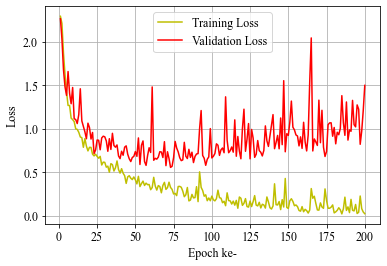

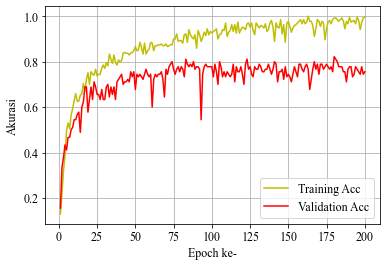

In [736]:
# Plot training and validation

loss6 = history6.history["loss"]
val_loss6 = history6.history["val_loss"]
epochs6 = range(1, len(loss6) + 1)
plt.plot(epochs6, loss6, "y", zorder=3, label="Training Loss")
plt.plot(epochs6, val_loss6, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc6 = history6.history["categorical_accuracy"]
val_acc6 = history6.history["val_categorical_accuracy"]
plt.plot(epochs6, acc6, "y", zorder=3, label="Training Acc")
plt.plot(epochs6, val_acc6, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Akurasi")
plt.legend()
plt.show()

In [737]:
res6 = lstm2_dense2_rd_lr5_75_b2_relu_mc_3.predict(X_test)

In [738]:
yhat6 = lstm2_dense2_rd_lr5_75_b2_relu_mc_3.predict(X_test)
ytrue6 = np.argmax(y_test, axis=1).tolist()
yhat6 = np.argmax(yhat6, axis=1).tolist()

Confusion matrix, without normalization
[[3 3 3 0 0 0 0 0 0 0]
 [2 6 1 0 0 0 0 0 0 0]
 [2 1 5 0 1 0 0 0 0 0]
 [0 0 0 9 0 0 0 0 0 0]
 [1 0 1 0 7 0 0 0 0 0]
 [0 0 0 0 0 6 2 0 0 1]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 1 0 1 0 0 7 0]
 [0 0 0 0 0 0 0 0 0 9]]


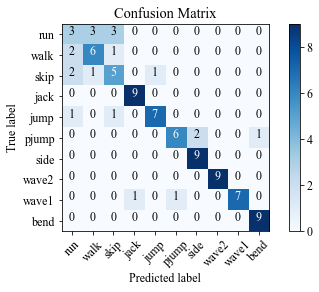

In [739]:
cm6 = confusion_matrix(y_true = ytrue6, y_pred = yhat6)
cm_plot_labels6 = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm6, classes = cm_plot_labels6, title = "Confusion Matrix")

In [740]:
fp6 = cm6.sum(axis=0) - np.diag(cm6)  
fn6 = cm6.sum(axis=1) - np.diag(cm6)
tp6 = np.diag(cm6)
tn6 = cm6.sum() - (fp6 + fn6 + tp6)

print(tp6)
print(fp6)
print(tn6)
print(fn6)

[3 6 5 9 7 6 9 9 7 9]
[5 4 5 1 1 1 2 0 0 1]
[76 77 76 80 80 80 79 81 81 80]
[6 3 4 0 2 3 0 0 2 0]


In [741]:
y_pred6 = lstm2_dense2_rd_lr5_75_b2_relu_mc_3.predict(X_test)
y_pred6 = (y_pred6 > 0.5)

In [742]:
_, acc6 = lstm2_dense2_rd_lr5_75_b2_relu_mc_3.evaluate(X_test, y_test)
print("Accuracy = ", (acc6*100), " %")

3/3 [==============================] - 8s 104ms/step - loss: 1.0555 - categorical_accuracy: 0.7778
Accuracy =  77.77777910232544  %


In [743]:
loss6_2, acc6_2 = lstm2_dense2_rd_lr5_75_b2_relu_mc_3.evaluate(X_train, y_train)
loss6_3, acc6_3 = lstm2_dense2_rd_lr5_75_b2_relu_mc_3.evaluate(X_valid, y_valid)

print("Accuracy2 = ", (acc6_2*100), " %")
print("Accuracy3 = ", (acc6_3*100), " %")

3/3 [==============================] - 0s 67ms/step - loss: 1.0150 - categorical_accuracy: 0.8222
Accuracy2 =  100.0  %
Accuracy3 =  82.22222328186035  %


In [744]:
accuracy_score(ytrue6, yhat6)

0.7777777777777778

In [745]:
acc6 = accuracy_score(ytrue6, yhat6)
acc6

0.7777777777777778

In [746]:
# Error rate
error_rate6 = 1 - acc6
error_rate6

0.2222222222222222

In [747]:
print(classification_report(
      ytrue6,
      yhat6,
      output_dict=False,
      target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.38      0.33      0.35         9
        walk       0.60      0.67      0.63         9
        skip       0.50      0.56      0.53         9
        jack       0.90      1.00      0.95         9
        jump       0.88      0.78      0.82         9
       pjump       0.86      0.67      0.75         9
        side       0.82      1.00      0.90         9
       wave2       1.00      1.00      1.00         9
       wave1       1.00      0.78      0.88         9
        bend       0.90      1.00      0.95         9

    accuracy                           0.78        90
   macro avg       0.78      0.78      0.78        90
weighted avg       0.78      0.78      0.78        90



# lstm2_dense2_rd_lr5_75_b2_default_mc_1
lstm2 (128,64) + dense2 (32,10) + activation=default + nadam + epochs=200 + recurrent_dropout + lr=0.000075 + batch=2 + ModelCheckpoint -> train:24min 15s, test:75,55%

#### Model 3 1st

In [206]:
# Define a sequential model
lstm2_dense2_rd_lr5_75_b2_default_mc_1 = Sequential([
    LSTM(128, recurrent_dropout=0.2, return_sequences=True, input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.2, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [207]:
# Compile model with learning rate
lstm2_dense2_rd_lr5_75_b2_default_mc_1.compile(Nadam(learning_rate=0.000075),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [208]:
# Model Checkpoint Callback - reconfig

checkpoint_filepath7 = os.path.join("tmp/mc_lstm2_dense2_rd_lr5_75_b2_default_mc_1_e{epoch:04d}_val{val_categorical_accuracy:.3f}.h5")

mc_val_acc = ModelCheckpoint(filepath = checkpoint_filepath7,
                             monitor="val_categorical_accuracy",
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode="max",
                             save_freq="epoch")

In [209]:
%%time
# Training model with validation
history7 = lstm2_dense2_rd_lr5_75_b2_default_mc_1.fit(X_train, y_train, batch_size=2, epochs=200, shuffle=True, verbose=2,
                                          validation_data=(X_valid, y_valid), callbacks=[mc_val_acc])

Epoch 1/200

Epoch 00001: val_categorical_accuracy improved from -inf to 0.25556, saving model to tmp\mc_lstm2_dense2_rd_lr5_75_b2_default_mc_1_e0001_val0.256.h5
135/135 - 17s - loss: 2.2890 - categorical_accuracy: 0.1778 - val_loss: 2.2301 - val_categorical_accuracy: 0.2556 - 17s/epoch - 124ms/step
Epoch 2/200

Epoch 00002: val_categorical_accuracy improved from 0.25556 to 0.28889, saving model to tmp\mc_lstm2_dense2_rd_lr5_75_b2_default_mc_1_e0002_val0.289.h5
135/135 - 10s - loss: 2.1585 - categorical_accuracy: 0.2741 - val_loss: 2.0434 - val_categorical_accuracy: 0.2889 - 10s/epoch - 75ms/step
Epoch 3/200

Epoch 00003: val_categorical_accuracy improved from 0.28889 to 0.40000, saving model to tmp\mc_lstm2_dense2_rd_lr5_75_b2_default_mc_1_e0003_val0.400.h5
135/135 - 8s - loss: 1.9388 - categorical_accuracy: 0.3481 - val_loss: 1.8021 - val_categorical_accuracy: 0.4000 - 8s/epoch - 59ms/step
Epoch 4/200

Epoch 00004: val_categorical_accuracy improved from 0.40000 to 0.46667, saving mod

Epoch 35/200

Epoch 00035: val_categorical_accuracy did not improve from 0.77778
135/135 - 7s - loss: 0.4012 - categorical_accuracy: 0.8481 - val_loss: 0.5938 - val_categorical_accuracy: 0.7444 - 7s/epoch - 53ms/step
Epoch 36/200

Epoch 00036: val_categorical_accuracy did not improve from 0.77778
135/135 - 8s - loss: 0.6298 - categorical_accuracy: 0.7593 - val_loss: 0.6634 - val_categorical_accuracy: 0.7333 - 8s/epoch - 56ms/step
Epoch 37/200

Epoch 00037: val_categorical_accuracy improved from 0.77778 to 0.78889, saving model to tmp\mc_lstm2_dense2_rd_lr5_75_b2_default_mc_1_e0037_val0.789.h5
135/135 - 7s - loss: 0.3916 - categorical_accuracy: 0.8815 - val_loss: 0.5308 - val_categorical_accuracy: 0.7889 - 7s/epoch - 53ms/step
Epoch 38/200

Epoch 00038: val_categorical_accuracy improved from 0.78889 to 0.80000, saving model to tmp\mc_lstm2_dense2_rd_lr5_75_b2_default_mc_1_e0038_val0.800.h5
135/135 - 7s - loss: 0.4162 - categorical_accuracy: 0.8481 - val_loss: 0.4910 - val_categorical_ac

Epoch 71/200

Epoch 00071: val_categorical_accuracy did not improve from 0.83333
135/135 - 7s - loss: 0.2307 - categorical_accuracy: 0.9148 - val_loss: 0.4721 - val_categorical_accuracy: 0.8000 - 7s/epoch - 52ms/step
Epoch 72/200

Epoch 00072: val_categorical_accuracy did not improve from 0.83333
135/135 - 7s - loss: 0.1696 - categorical_accuracy: 0.9444 - val_loss: 0.5985 - val_categorical_accuracy: 0.7667 - 7s/epoch - 53ms/step
Epoch 73/200

Epoch 00073: val_categorical_accuracy did not improve from 0.83333
135/135 - 7s - loss: 0.1663 - categorical_accuracy: 0.9481 - val_loss: 0.5544 - val_categorical_accuracy: 0.7556 - 7s/epoch - 53ms/step
Epoch 74/200

Epoch 00074: val_categorical_accuracy did not improve from 0.83333
135/135 - 7s - loss: 0.1924 - categorical_accuracy: 0.9444 - val_loss: 0.6434 - val_categorical_accuracy: 0.7333 - 7s/epoch - 53ms/step
Epoch 75/200

Epoch 00075: val_categorical_accuracy did not improve from 0.83333
135/135 - 8s - loss: 0.3138 - categorical_accuracy:

Epoch 109/200

Epoch 00109: val_categorical_accuracy did not improve from 0.85556
135/135 - 7s - loss: 0.1428 - categorical_accuracy: 0.9593 - val_loss: 0.6028 - val_categorical_accuracy: 0.7556 - 7s/epoch - 53ms/step
Epoch 110/200

Epoch 00110: val_categorical_accuracy did not improve from 0.85556
135/135 - 7s - loss: 0.1419 - categorical_accuracy: 0.9444 - val_loss: 0.4599 - val_categorical_accuracy: 0.8333 - 7s/epoch - 52ms/step
Epoch 111/200

Epoch 00111: val_categorical_accuracy did not improve from 0.85556
135/135 - 7s - loss: 0.2636 - categorical_accuracy: 0.9111 - val_loss: 0.6104 - val_categorical_accuracy: 0.7778 - 7s/epoch - 52ms/step
Epoch 112/200

Epoch 00112: val_categorical_accuracy improved from 0.85556 to 0.86667, saving model to tmp\mc_lstm2_dense2_rd_lr5_75_b2_default_mc_1_e0112_val0.867.h5
135/135 - 7s - loss: 0.1051 - categorical_accuracy: 0.9778 - val_loss: 0.4108 - val_categorical_accuracy: 0.8667 - 7s/epoch - 52ms/step
Epoch 113/200

Epoch 00113: val_categorical

Epoch 146/200

Epoch 00146: val_categorical_accuracy did not improve from 0.87778
135/135 - 7s - loss: 0.0379 - categorical_accuracy: 1.0000 - val_loss: 0.5010 - val_categorical_accuracy: 0.7889 - 7s/epoch - 52ms/step
Epoch 147/200

Epoch 00147: val_categorical_accuracy did not improve from 0.87778
135/135 - 7s - loss: 0.0373 - categorical_accuracy: 0.9889 - val_loss: 0.7717 - val_categorical_accuracy: 0.7556 - 7s/epoch - 52ms/step
Epoch 148/200

Epoch 00148: val_categorical_accuracy did not improve from 0.87778
135/135 - 7s - loss: 0.0410 - categorical_accuracy: 0.9889 - val_loss: 0.6970 - val_categorical_accuracy: 0.7556 - 7s/epoch - 53ms/step
Epoch 149/200

Epoch 00149: val_categorical_accuracy did not improve from 0.87778
135/135 - 7s - loss: 0.0978 - categorical_accuracy: 0.9667 - val_loss: 0.6043 - val_categorical_accuracy: 0.8111 - 7s/epoch - 52ms/step
Epoch 150/200

Epoch 00150: val_categorical_accuracy did not improve from 0.87778
135/135 - 7s - loss: 0.0735 - categorical_accu

Epoch 184/200

Epoch 00184: val_categorical_accuracy did not improve from 0.88889
135/135 - 7s - loss: 0.1156 - categorical_accuracy: 0.9630 - val_loss: 0.6585 - val_categorical_accuracy: 0.8111 - 7s/epoch - 52ms/step
Epoch 185/200

Epoch 00185: val_categorical_accuracy did not improve from 0.88889
135/135 - 7s - loss: 0.0647 - categorical_accuracy: 0.9852 - val_loss: 0.6378 - val_categorical_accuracy: 0.7778 - 7s/epoch - 53ms/step
Epoch 186/200

Epoch 00186: val_categorical_accuracy did not improve from 0.88889
135/135 - 7s - loss: 0.0928 - categorical_accuracy: 0.9741 - val_loss: 0.6016 - val_categorical_accuracy: 0.8556 - 7s/epoch - 52ms/step
Epoch 187/200

Epoch 00187: val_categorical_accuracy did not improve from 0.88889
135/135 - 7s - loss: 0.0796 - categorical_accuracy: 0.9852 - val_loss: 0.6846 - val_categorical_accuracy: 0.7667 - 7s/epoch - 52ms/step
Epoch 188/200

Epoch 00188: val_categorical_accuracy did not improve from 0.88889
135/135 - 7s - loss: 0.0438 - categorical_accu

In [227]:
# Save history to json and csv

# convert the history7.history dict to a pandas DataFrame:     
hist_df_7 = pd.DataFrame(history7.history) 

# save to json:  
hist_json_file_7 = 'history/mine/json/lstm2_dense2_rd_lr5_75_b2_default_mc_1.json' 
with open(hist_json_file_7, mode='w') as f:
    hist_df_7.to_json(f)

# or save to csv: 
hist_csv_file_7 = 'history/mine/csv/lstm2_dense2_rd_lr5_75_b2_default_mc_1.csv'
with open(hist_csv_file_7, mode='w') as f:
    hist_df_7.to_csv(f)

In [211]:
lstm2_dense2_rd_lr5_75_b2_default_mc_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 25, 128)           133632    
                                                                 
 lstm_21 (LSTM)              (None, 64)                49408     
                                                                 
 dense_20 (Dense)            (None, 32)                2080      
                                                                 
 dense_21 (Dense)            (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-trainable params: 0
_________________________________________________________________


In [229]:
# Load Model
lstm2_dense2_rd_lr5_75_b2_default_mc_1.load_weights("tmp\mc_lstm2_dense2_rd_lr5_75_b2_default_mc_1_e0172_val0.889.h5")

In [213]:
# Save Model
lstm2_dense2_rd_lr5_75_b2_default_mc_1.save("model2\lstm2_dense2_rd_lr5_75_b2_default_mc_2_e0116_val0.833.h5")

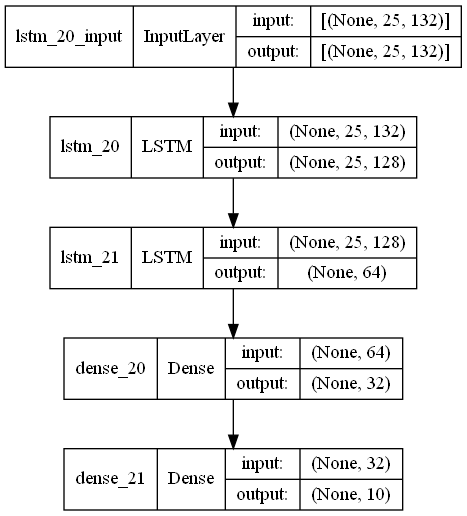

In [214]:
# Visualize
plot_model(lstm2_dense2_rd_lr5_75_b2_default_mc_1, to_file = "arc_lstm2_dense2_rd_lr5_75_b2_default_mc_2_1840_23032022.png", show_shapes = True)

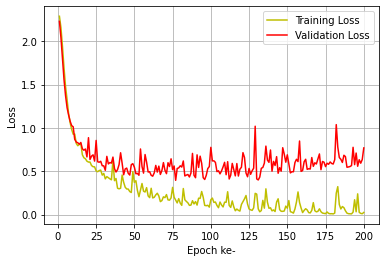

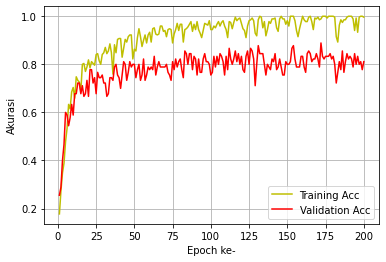

In [215]:
# Plot training and validation

loss7 = history7.history["loss"]
val_loss7 = history7.history["val_loss"]
epochs7 = range(1, len(loss7) + 1)
plt.plot(epochs7, loss7, "y", zorder=3, label="Training Loss")
plt.plot(epochs7, val_loss7, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc7 = history7.history["categorical_accuracy"]
val_acc7 = history7.history["val_categorical_accuracy"]
plt.plot(epochs7, acc7, "y", zorder=3, label="Training Acc")
plt.plot(epochs7, val_acc7, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Akurasi")
plt.legend()
plt.show()

In [230]:
res7 = lstm2_dense2_rd_lr5_75_b2_default_mc_1.predict(X_test)

In [231]:
yhat7 = lstm2_dense2_rd_lr5_75_b2_default_mc_1.predict(X_test)
ytrue7 = np.argmax(y_test, axis=1).tolist()
yhat7 = np.argmax(yhat7, axis=1).tolist()

Confusion matrix, without normalization
[[2 3 4 0 0 0 0 0 0 0]
 [2 5 1 0 0 0 1 0 0 0]
 [4 1 4 0 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 1 0]
 [1 0 1 0 6 0 0 0 0 1]
 [0 0 0 0 0 8 1 0 0 0]
 [0 1 0 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 0 9 0]
 [0 0 0 0 0 0 0 0 0 9]]


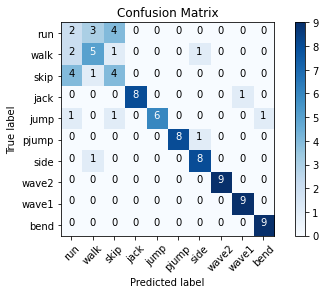

In [232]:
cm7 = confusion_matrix(y_true = ytrue7, y_pred = yhat7)
cm_plot_labels7 = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm7, classes = cm_plot_labels7, title = "Confusion Matrix")

In [233]:
fp7 = cm7.sum(axis=0) - np.diag(cm7)  
fn7 = cm7.sum(axis=1) - np.diag(cm7)
tp7 = np.diag(cm7)
tn7 = cm7.sum() - (fp7 + fn7 + tp7)

print(tp7)
print(fp7)
print(tn7)
print(fn7)

[2 5 4 8 6 8 8 9 9 9]
[7 5 6 0 0 0 2 0 1 1]
[74 76 75 81 81 81 79 81 80 80]
[7 4 5 1 3 1 1 0 0 0]


In [234]:
y_pred7 = lstm2_dense2_rd_lr5_75_b2_default_mc_1.predict(X_test)
y_pred7 = (y_pred7 > 0.5)

In [235]:
_, acc7 = lstm2_dense2_rd_lr5_75_b2_default_mc_1.evaluate(X_test, y_test)
print("Accuracy = ", (acc7*100), " %")

3/3 [==============================] - 0s 17ms/step - loss: 0.8325 - categorical_accuracy: 0.7556
Accuracy =  75.55555701255798  %


In [236]:
loss7_2, acc7_2 = lstm2_dense2_rd_lr5_75_b2_default_mc_1.evaluate(X_train, y_train)
loss7_3, acc7_3 = lstm2_dense2_rd_lr5_75_b2_default_mc_1.evaluate(X_valid, y_valid)

print("Accuracy2 = ", (acc7_2*100), " %")
print("Accuracy3 = ", (acc7_3*100), " %")

3/3 [==============================] - 0s 18ms/step - loss: 0.5179 - categorical_accuracy: 0.8889
Accuracy2 =  100.0  %
Accuracy3 =  88.88888955116272  %


In [237]:
accuracy_score(ytrue7, yhat7)

0.7555555555555555

In [238]:
acc7 = accuracy_score(ytrue7, yhat7)
acc7

0.7555555555555555

In [239]:
# Error rate
error_rate7 = 1 - acc7
error_rate7

0.24444444444444446

In [240]:
print(classification_report(
      ytrue7,
      yhat7,
      output_dict=False,
      target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.22      0.22      0.22         9
        walk       0.50      0.56      0.53         9
        skip       0.40      0.44      0.42         9
        jack       1.00      0.89      0.94         9
        jump       1.00      0.67      0.80         9
       pjump       1.00      0.89      0.94         9
        side       0.80      0.89      0.84         9
       wave2       1.00      1.00      1.00         9
       wave1       0.90      1.00      0.95         9
        bend       0.90      1.00      0.95         9

    accuracy                           0.76        90
   macro avg       0.77      0.76      0.76        90
weighted avg       0.77      0.76      0.76        90



# lstm2_dense2_rd_lr5_75_b2_default_mc_2
lstm2 (128,64) + dense2 (32,10) + activation=default + nadam + epochs=200 + recurrent_dropout + lr=0.000075 + batch=2 + ModelCheckpoint -> train:24min 52s, test:78,88%

#### Model 3 2nd (Chosen)

In [241]:
# Define a sequential model
lstm2_dense2_rd_lr5_75_b2_default_mc_2 = Sequential([
    LSTM(128, recurrent_dropout=0.2, return_sequences=True, input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.2, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [242]:
# Compile model with learning rate
lstm2_dense2_rd_lr5_75_b2_default_mc_2.compile(Nadam(learning_rate=0.000075),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [243]:
# Model Checkpoint Callback - reconfig

checkpoint_filepath8 = os.path.join("tmp/mc_lstm2_dense2_rd_lr5_75_b2_default_mc_2_e{epoch:04d}_val{val_categorical_accuracy:.3f}.h5")

mc_val_acc = ModelCheckpoint(filepath = checkpoint_filepath8,
                             monitor="val_categorical_accuracy",
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode="max",
                             save_freq="epoch")

In [244]:
%%time
# Training model with validation
history8 = lstm2_dense2_rd_lr5_75_b2_default_mc_2.fit(X_train, y_train, batch_size=2, epochs=200, shuffle=True, verbose=2,
                                          validation_data=(X_valid, y_valid), callbacks=[mc_val_acc])

Epoch 1/200

Epoch 00001: val_categorical_accuracy improved from -inf to 0.21111, saving model to tmp\mc_lstm2_dense2_rd_lr5_75_b2_default_mc_2_e0001_val0.211.h5
135/135 - 14s - loss: 2.2714 - categorical_accuracy: 0.1333 - val_loss: 2.2201 - val_categorical_accuracy: 0.2111 - 14s/epoch - 105ms/step
Epoch 2/200

Epoch 00002: val_categorical_accuracy improved from 0.21111 to 0.26667, saving model to tmp\mc_lstm2_dense2_rd_lr5_75_b2_default_mc_2_e0002_val0.267.h5
135/135 - 7s - loss: 2.1356 - categorical_accuracy: 0.1778 - val_loss: 2.0178 - val_categorical_accuracy: 0.2667 - 7s/epoch - 55ms/step
Epoch 3/200

Epoch 00003: val_categorical_accuracy improved from 0.26667 to 0.28889, saving model to tmp\mc_lstm2_dense2_rd_lr5_75_b2_default_mc_2_e0003_val0.289.h5
135/135 - 7s - loss: 1.9046 - categorical_accuracy: 0.3185 - val_loss: 1.8058 - val_categorical_accuracy: 0.2889 - 7s/epoch - 54ms/step
Epoch 4/200

Epoch 00004: val_categorical_accuracy improved from 0.28889 to 0.41111, saving model

Epoch 35/200

Epoch 00035: val_categorical_accuracy did not improve from 0.80000
135/135 - 7s - loss: 0.3860 - categorical_accuracy: 0.8815 - val_loss: 0.5282 - val_categorical_accuracy: 0.7667 - 7s/epoch - 53ms/step
Epoch 36/200

Epoch 00036: val_categorical_accuracy did not improve from 0.80000
135/135 - 7s - loss: 0.3532 - categorical_accuracy: 0.9037 - val_loss: 0.7191 - val_categorical_accuracy: 0.7333 - 7s/epoch - 53ms/step
Epoch 37/200

Epoch 00037: val_categorical_accuracy did not improve from 0.80000
135/135 - 7s - loss: 0.3107 - categorical_accuracy: 0.9074 - val_loss: 0.5495 - val_categorical_accuracy: 0.7333 - 7s/epoch - 54ms/step
Epoch 38/200

Epoch 00038: val_categorical_accuracy did not improve from 0.80000
135/135 - 7s - loss: 0.3166 - categorical_accuracy: 0.9000 - val_loss: 0.6134 - val_categorical_accuracy: 0.7556 - 7s/epoch - 53ms/step
Epoch 39/200

Epoch 00039: val_categorical_accuracy did not improve from 0.80000
135/135 - 7s - loss: 0.3423 - categorical_accuracy:

Epoch 73/200

Epoch 00073: val_categorical_accuracy did not improve from 0.80000
135/135 - 7s - loss: 0.1958 - categorical_accuracy: 0.9222 - val_loss: 0.6466 - val_categorical_accuracy: 0.8000 - 7s/epoch - 54ms/step
Epoch 74/200

Epoch 00074: val_categorical_accuracy did not improve from 0.80000
135/135 - 7s - loss: 0.2209 - categorical_accuracy: 0.9259 - val_loss: 0.8442 - val_categorical_accuracy: 0.7556 - 7s/epoch - 54ms/step
Epoch 75/200

Epoch 00075: val_categorical_accuracy did not improve from 0.80000
135/135 - 7s - loss: 0.2072 - categorical_accuracy: 0.9333 - val_loss: 0.6821 - val_categorical_accuracy: 0.7556 - 7s/epoch - 54ms/step
Epoch 76/200

Epoch 00076: val_categorical_accuracy did not improve from 0.80000
135/135 - 7s - loss: 0.1785 - categorical_accuracy: 0.9259 - val_loss: 0.6692 - val_categorical_accuracy: 0.7667 - 7s/epoch - 54ms/step
Epoch 77/200

Epoch 00077: val_categorical_accuracy improved from 0.80000 to 0.81111, saving model to tmp\mc_lstm2_dense2_rd_lr5_75_

Epoch 109/200

Epoch 00109: val_categorical_accuracy did not improve from 0.85556
135/135 - 7s - loss: 0.1378 - categorical_accuracy: 0.9556 - val_loss: 0.6273 - val_categorical_accuracy: 0.7889 - 7s/epoch - 53ms/step
Epoch 110/200

Epoch 00110: val_categorical_accuracy did not improve from 0.85556
135/135 - 7s - loss: 0.1098 - categorical_accuracy: 0.9630 - val_loss: 0.6685 - val_categorical_accuracy: 0.7889 - 7s/epoch - 54ms/step
Epoch 111/200

Epoch 00111: val_categorical_accuracy did not improve from 0.85556
135/135 - 7s - loss: 0.1018 - categorical_accuracy: 0.9704 - val_loss: 0.4880 - val_categorical_accuracy: 0.8556 - 7s/epoch - 53ms/step
Epoch 112/200

Epoch 00112: val_categorical_accuracy did not improve from 0.85556
135/135 - 7s - loss: 0.0439 - categorical_accuracy: 1.0000 - val_loss: 0.6259 - val_categorical_accuracy: 0.8000 - 7s/epoch - 54ms/step
Epoch 113/200

Epoch 00113: val_categorical_accuracy did not improve from 0.85556
135/135 - 7s - loss: 0.0568 - categorical_accu

Epoch 147/200

Epoch 00147: val_categorical_accuracy did not improve from 0.85556
135/135 - 7s - loss: 0.1623 - categorical_accuracy: 0.9481 - val_loss: 0.7870 - val_categorical_accuracy: 0.7556 - 7s/epoch - 53ms/step
Epoch 148/200

Epoch 00148: val_categorical_accuracy did not improve from 0.85556
135/135 - 7s - loss: 0.0634 - categorical_accuracy: 0.9926 - val_loss: 0.7049 - val_categorical_accuracy: 0.7444 - 7s/epoch - 54ms/step
Epoch 149/200

Epoch 00149: val_categorical_accuracy did not improve from 0.85556
135/135 - 7s - loss: 0.0290 - categorical_accuracy: 0.9963 - val_loss: 0.5937 - val_categorical_accuracy: 0.8000 - 7s/epoch - 53ms/step
Epoch 150/200

Epoch 00150: val_categorical_accuracy did not improve from 0.85556
135/135 - 7s - loss: 0.0593 - categorical_accuracy: 0.9852 - val_loss: 0.8259 - val_categorical_accuracy: 0.7778 - 7s/epoch - 54ms/step
Epoch 151/200

Epoch 00151: val_categorical_accuracy did not improve from 0.85556
135/135 - 7s - loss: 0.0268 - categorical_accu

Epoch 185/200

Epoch 00185: val_categorical_accuracy did not improve from 0.85556
135/135 - 7s - loss: 0.0077 - categorical_accuracy: 1.0000 - val_loss: 0.7109 - val_categorical_accuracy: 0.8000 - 7s/epoch - 54ms/step
Epoch 186/200

Epoch 00186: val_categorical_accuracy did not improve from 0.85556
135/135 - 7s - loss: 0.0079 - categorical_accuracy: 1.0000 - val_loss: 0.7986 - val_categorical_accuracy: 0.7889 - 7s/epoch - 54ms/step
Epoch 187/200

Epoch 00187: val_categorical_accuracy did not improve from 0.85556
135/135 - 7s - loss: 0.0072 - categorical_accuracy: 1.0000 - val_loss: 0.7642 - val_categorical_accuracy: 0.7889 - 7s/epoch - 53ms/step
Epoch 188/200

Epoch 00188: val_categorical_accuracy did not improve from 0.85556
135/135 - 7s - loss: 0.0060 - categorical_accuracy: 1.0000 - val_loss: 0.7798 - val_categorical_accuracy: 0.8000 - 7s/epoch - 53ms/step
Epoch 189/200

Epoch 00189: val_categorical_accuracy did not improve from 0.85556
135/135 - 7s - loss: 0.0229 - categorical_accu

In [245]:
# Save history to json and csv

# convert the history8.history dict to a pandas DataFrame:     
hist_df_8 = pd.DataFrame(history8.history) 

# save to json:  
hist_json_file_8 = 'history/mine/json/lstm2_dense2_rd_lr5_75_b2_default_mc_2.json' 
with open(hist_json_file_8, mode='w') as f:
    hist_df_8.to_json(f)

# or save to csv: 
hist_csv_file_8 = 'history/mine/csv/lstm2_dense2_rd_lr5_75_b2_default_mc_2.csv'
with open(hist_csv_file_8, mode='w') as f:
    hist_df_8.to_csv(f)

In [ ]:
lstm2_dense2_rd_lr5_75_b2_default_mc_2.summary()

In [246]:
# Load Model
lstm2_dense2_rd_lr5_75_b2_default_mc_2.load_weights("tmp\mc_lstm2_dense2_rd_lr5_75_b2_default_mc_2_e0103_val0.856.h5")

In [754]:
# Save Model
lstm2_dense2_rd_lr5_75_b2_default_mc_2.save("model/mine/lstm2_dense2_rd_lr5_75_b2_default_mc_2_e0103_val0.856.h5")

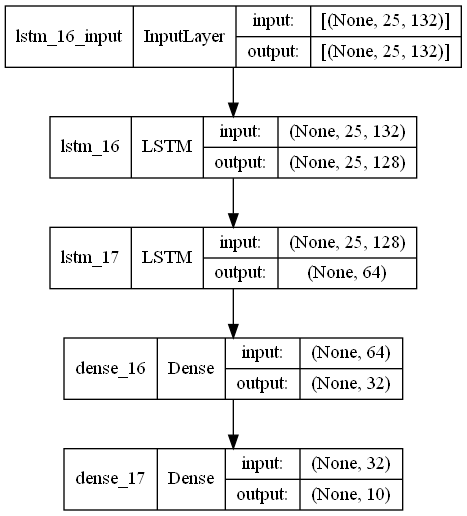

In [139]:
# Visualize
plot_model(lstm2_dense2_rd_lr5_75_b2_default_mc_2, to_file = "arc_lstm2_dense2_rd_lr5_75_b2_default_mc_2_1840_23032022.png", show_shapes = True)

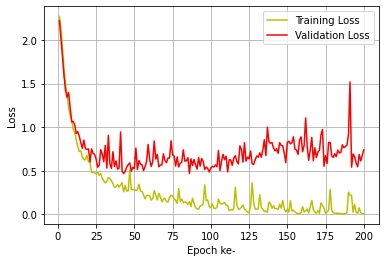

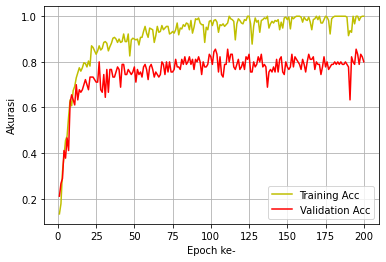

In [247]:
# Plot training and validation

loss8 = history8.history["loss"]
val_loss8 = history8.history["val_loss"]
epochs8 = range(1, len(loss8) + 1)
plt.plot(epochs8, loss8, "y", zorder=3, label="Training Loss")
plt.plot(epochs8, val_loss8, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc8 = history8.history["categorical_accuracy"]
val_acc8 = history8.history["val_categorical_accuracy"]
plt.plot(epochs8, acc8, "y", zorder=3, label="Training Acc")
plt.plot(epochs8, val_acc8, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Akurasi")
plt.legend()
plt.show()

In [32]:
df_8 = pd.read_csv("history/mine/csv/lstm2_dense2_rd_lr5_75_b2_default_mc_2.csv")
df_8.head()

Unnamed: 0      loss  categorical_accuracy  val_loss  \
0           0  2.271437              0.133333  2.220141   
1           1  2.135635              0.177778  2.017771   
2           2  1.904619              0.318519  1.805766   
3           3  1.666037              0.385185  1.590035   
4           4  1.490866              0.455556  1.419842   

   val_categorical_accuracy  
0                  0.211111  
1                  0.266667  
2                  0.288889  
3                  0.411111  
4                  0.377778

In [33]:
df_8_processed = df_8.copy(deep=True)

df_8_processed["categorical_accuracy"] = df_8_processed["categorical_accuracy"]*100
df_8_processed["val_categorical_accuracy"] = df_8_processed["val_categorical_accuracy"]*100

df_8_processed

Unnamed: 0      loss  categorical_accuracy  val_loss  \
0             0  2.271437             13.333334  2.220141   
1             1  2.135635             17.777778  2.017771   
2             2  1.904619             31.851852  1.805766   
3             3  1.666037             38.518518  1.590035   
4             4  1.490866             45.555556  1.419842   
..          ...       ...                   ...       ...   
195         195  0.014415            100.000000  0.546172   
196         196  0.075494             98.148149  0.687815   
197         197  0.020249             99.629629  0.612734   
198         198  0.009666            100.000000  0.676077   
199         199  0.009319            100.000000  0.741651   

     val_categorical_accuracy  
0                   21.111111  
1                   26.666668  
2                   28.888890  
3                   41.111112  
4                   37.777779  
..                        ...  
195                 83.333331  
196                 78.888887  
197                 83.333331  
198                 82.222223  
199                 80.000001  

[200 rows x 5 columns]

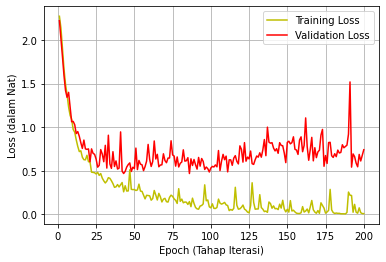

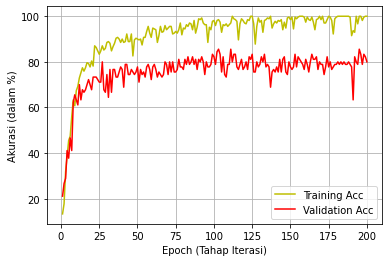

In [34]:
# Plot training and validation

loss8_2 = df_8_processed["loss"]
val_loss8_2 = df_8_processed["val_loss"]
epochs8_2 = range(1, len(loss8_2) + 1)
plt.plot(epochs8_2, loss8_2, "y", zorder=3, label="Training Loss")
plt.plot(epochs8_2, val_loss8_2, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch (Tahap Iterasi)")
plt.ylabel("Loss (dalam Nat)")
plt.legend()
plt.show()

acc8_2 = df_8_processed["categorical_accuracy"]
val_acc8_2 = df_8_processed["val_categorical_accuracy"]
plt.plot(epochs8_2, acc8_2, "y", zorder=3, label="Training Acc")
plt.plot(epochs8_2, val_acc8_2, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch (Tahap Iterasi)")
plt.ylabel("Akurasi (dalam %)")
plt.legend()
plt.show()

In [248]:
res8 = lstm2_dense2_rd_lr5_75_b2_default_mc_2.predict(X_test)

In [249]:
yhat8 = lstm2_dense2_rd_lr5_75_b2_default_mc_2.predict(X_test)
ytrue8 = np.argmax(y_test, axis=1).tolist()
yhat8 = np.argmax(yhat8, axis=1).tolist()

Confusion matrix, without normalization
[[5 3 1 0 0 0 0 0 0 0]
 [2 6 0 0 1 0 0 0 0 0]
 [4 1 4 0 0 0 0 0 0 0]
 [0 0 0 9 0 0 0 0 0 0]
 [1 0 1 0 7 0 0 0 0 0]
 [0 0 0 0 0 8 1 0 0 0]
 [0 1 0 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 3 0 0 0 0 6 0]
 [0 0 0 0 0 0 0 0 0 9]]


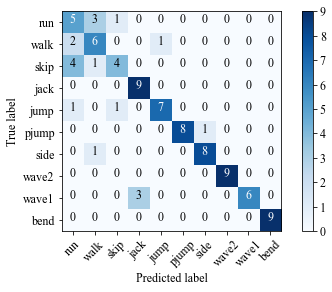

In [759]:
cm8 = confusion_matrix(y_true = ytrue8, y_pred = yhat8)
cm_plot_labels8 = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm8, classes = cm_plot_labels8, title = "")

In [251]:
fp8 = cm8.sum(axis=0) - np.diag(cm8)  
fn8 = cm8.sum(axis=1) - np.diag(cm8)
tp8 = np.diag(cm8)
tn8 = cm8.sum() - (fp8 + fn8 + tp8)

print(tp8)
print(fp8)
print(tn8)
print(fn8)

[5 6 4 9 7 8 8 9 6 9]
[7 5 2 3 1 0 1 0 0 0]
[74 76 79 78 80 81 80 81 81 81]
[4 3 5 0 2 1 1 0 3 0]


In [252]:
y_pred8 = lstm2_dense2_rd_lr5_75_b2_default_mc_2.predict(X_test)
y_pred8 = (y_pred8 > 0.5)

In [253]:
_, acc8 = lstm2_dense2_rd_lr5_75_b2_default_mc_2.evaluate(X_test, y_test)
print("Accuracy = ", (acc8*100), " %")

3/3 [==============================] - 1s 19ms/step - loss: 0.6393 - categorical_accuracy: 0.7889
Accuracy =  78.88888716697693  %


In [254]:
loss8_2, acc8_2 = lstm2_dense2_rd_lr5_75_b2_default_mc_2.evaluate(X_train, y_train)
loss8_3, acc8_3 = lstm2_dense2_rd_lr5_75_b2_default_mc_2.evaluate(X_valid, y_valid)

print("Accuracy2 = ", (acc8_2*100), " %")
print("Accuracy3 = ", (acc8_3*100), " %")

3/3 [==============================] - 0s 19ms/step - loss: 0.5676 - categorical_accuracy: 0.8556
Accuracy2 =  99.62962865829468  %
Accuracy3 =  85.5555534362793  %


In [255]:
accuracy_score(ytrue8, yhat8)

0.7888888888888889

In [256]:
acc8 = accuracy_score(ytrue8, yhat8)
acc8

0.7888888888888889

In [257]:
# Error rate
error_rate8 = 1 - acc8
error_rate8

0.21111111111111114

In [258]:
print(classification_report(
      ytrue8,
      yhat8,
      output_dict=False,
      target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.42      0.56      0.48         9
        walk       0.55      0.67      0.60         9
        skip       0.67      0.44      0.53         9
        jack       0.75      1.00      0.86         9
        jump       0.88      0.78      0.82         9
       pjump       1.00      0.89      0.94         9
        side       0.89      0.89      0.89         9
       wave2       1.00      1.00      1.00         9
       wave1       1.00      0.67      0.80         9
        bend       1.00      1.00      1.00         9

    accuracy                           0.79        90
   macro avg       0.81      0.79      0.79        90
weighted avg       0.81      0.79      0.79        90



# lstm2_dense2_rd_lr5_75_b2_default_mc_3
lstm2 (128,64) + dense2 (32,10) + activation=default + nadam + epochs=200 + recurrent_dropout + lr=0.000075 + batch=2 + ModelCheckpoint -> train:25min 3s, test:78,88%

#### Model 3 3rd

In [259]:
# Define a sequential model
lstm2_dense2_rd_lr5_75_b2_default_mc_3 = Sequential([
    LSTM(128, recurrent_dropout=0.2, return_sequences=True, input_shape=(25,132)),
    LSTM(64, recurrent_dropout=0.2, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(actions.shape[0], activation="softmax")
])

In [260]:
# Compile model with learning rate
lstm2_dense2_rd_lr5_75_b2_default_mc_3.compile(Nadam(learning_rate=0.000075),
                                            loss="categorical_crossentropy",
                                            metrics=["categorical_accuracy"])

In [261]:
# Model Checkpoint Callback - reconfig

checkpoint_filepath9 = os.path.join("tmp/mc_lstm2_dense2_rd_lr5_75_b2_default_mc_3_e{epoch:04d}_val{val_categorical_accuracy:.3f}.h5")

mc_val_acc = ModelCheckpoint(filepath = checkpoint_filepath9,
                             monitor="val_categorical_accuracy",
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode="max",
                             save_freq="epoch")

In [262]:
%%time
# Training model with validation
history9 = lstm2_dense2_rd_lr5_75_b2_default_mc_3.fit(X_train, y_train, batch_size=2, epochs=200, shuffle=True, verbose=2,
                                          validation_data=(X_valid, y_valid), callbacks=[mc_val_acc])

Epoch 1/200

Epoch 00001: val_categorical_accuracy improved from -inf to 0.20000, saving model to tmp\mc_lstm2_dense2_rd_lr5_75_b2_default_mc_3_e0001_val0.200.h5
135/135 - 17s - loss: 2.2890 - categorical_accuracy: 0.1370 - val_loss: 2.2550 - val_categorical_accuracy: 0.2000 - 17s/epoch - 124ms/step
Epoch 2/200

Epoch 00002: val_categorical_accuracy improved from 0.20000 to 0.23333, saving model to tmp\mc_lstm2_dense2_rd_lr5_75_b2_default_mc_3_e0002_val0.233.h5
135/135 - 8s - loss: 2.1686 - categorical_accuracy: 0.2852 - val_loss: 2.0915 - val_categorical_accuracy: 0.2333 - 8s/epoch - 61ms/step
Epoch 3/200

Epoch 00003: val_categorical_accuracy improved from 0.23333 to 0.33333, saving model to tmp\mc_lstm2_dense2_rd_lr5_75_b2_default_mc_3_e0003_val0.333.h5
135/135 - 7s - loss: 1.9874 - categorical_accuracy: 0.3407 - val_loss: 1.9145 - val_categorical_accuracy: 0.3333 - 7s/epoch - 54ms/step
Epoch 4/200

Epoch 00004: val_categorical_accuracy improved from 0.33333 to 0.38889, saving model

Epoch 33/200

Epoch 00033: val_categorical_accuracy did not improve from 0.75556
135/135 - 7s - loss: 0.4529 - categorical_accuracy: 0.8519 - val_loss: 0.6594 - val_categorical_accuracy: 0.7333 - 7s/epoch - 55ms/step
Epoch 34/200

Epoch 00034: val_categorical_accuracy did not improve from 0.75556
135/135 - 7s - loss: 0.4126 - categorical_accuracy: 0.8778 - val_loss: 0.7462 - val_categorical_accuracy: 0.6889 - 7s/epoch - 54ms/step
Epoch 35/200

Epoch 00035: val_categorical_accuracy did not improve from 0.75556
135/135 - 7s - loss: 0.3693 - categorical_accuracy: 0.8852 - val_loss: 0.7646 - val_categorical_accuracy: 0.6667 - 7s/epoch - 55ms/step
Epoch 36/200

Epoch 00036: val_categorical_accuracy did not improve from 0.75556
135/135 - 7s - loss: 0.4174 - categorical_accuracy: 0.8593 - val_loss: 0.6290 - val_categorical_accuracy: 0.7333 - 7s/epoch - 54ms/step
Epoch 37/200

Epoch 00037: val_categorical_accuracy did not improve from 0.75556
135/135 - 7s - loss: 0.3651 - categorical_accuracy:

Epoch 70/200

Epoch 00070: val_categorical_accuracy did not improve from 0.80000
135/135 - 7s - loss: 0.2165 - categorical_accuracy: 0.9370 - val_loss: 0.6681 - val_categorical_accuracy: 0.7333 - 7s/epoch - 54ms/step
Epoch 71/200

Epoch 00071: val_categorical_accuracy did not improve from 0.80000
135/135 - 7s - loss: 0.2650 - categorical_accuracy: 0.9185 - val_loss: 1.1155 - val_categorical_accuracy: 0.6667 - 7s/epoch - 55ms/step
Epoch 72/200

Epoch 00072: val_categorical_accuracy improved from 0.80000 to 0.81111, saving model to tmp\mc_lstm2_dense2_rd_lr5_75_b2_default_mc_3_e0072_val0.811.h5
135/135 - 7s - loss: 0.2445 - categorical_accuracy: 0.8963 - val_loss: 0.6143 - val_categorical_accuracy: 0.8111 - 7s/epoch - 54ms/step
Epoch 73/200

Epoch 00073: val_categorical_accuracy did not improve from 0.81111
135/135 - 7s - loss: 0.1444 - categorical_accuracy: 0.9593 - val_loss: 0.6047 - val_categorical_accuracy: 0.7667 - 7s/epoch - 54ms/step
Epoch 74/200

Epoch 00074: val_categorical_accu

Epoch 108/200

Epoch 00108: val_categorical_accuracy did not improve from 0.81111
135/135 - 7s - loss: 0.0755 - categorical_accuracy: 0.9852 - val_loss: 0.6934 - val_categorical_accuracy: 0.7667 - 7s/epoch - 54ms/step
Epoch 109/200

Epoch 00109: val_categorical_accuracy did not improve from 0.81111
135/135 - 7s - loss: 0.1170 - categorical_accuracy: 0.9667 - val_loss: 0.6709 - val_categorical_accuracy: 0.8000 - 7s/epoch - 54ms/step
Epoch 110/200

Epoch 00110: val_categorical_accuracy did not improve from 0.81111
135/135 - 7s - loss: 0.0802 - categorical_accuracy: 0.9778 - val_loss: 0.6317 - val_categorical_accuracy: 0.7889 - 7s/epoch - 54ms/step
Epoch 111/200

Epoch 00111: val_categorical_accuracy did not improve from 0.81111
135/135 - 7s - loss: 0.0463 - categorical_accuracy: 0.9926 - val_loss: 0.5825 - val_categorical_accuracy: 0.8111 - 7s/epoch - 54ms/step
Epoch 112/200

Epoch 00112: val_categorical_accuracy did not improve from 0.81111
135/135 - 7s - loss: 0.1159 - categorical_accu

Epoch 146/200

Epoch 00146: val_categorical_accuracy did not improve from 0.83333
135/135 - 7s - loss: 0.0239 - categorical_accuracy: 1.0000 - val_loss: 0.7133 - val_categorical_accuracy: 0.8000 - 7s/epoch - 54ms/step
Epoch 147/200

Epoch 00147: val_categorical_accuracy did not improve from 0.83333
135/135 - 7s - loss: 0.0894 - categorical_accuracy: 0.9778 - val_loss: 0.7311 - val_categorical_accuracy: 0.7667 - 7s/epoch - 54ms/step
Epoch 148/200

Epoch 00148: val_categorical_accuracy did not improve from 0.83333
135/135 - 7s - loss: 0.0250 - categorical_accuracy: 1.0000 - val_loss: 0.7214 - val_categorical_accuracy: 0.8000 - 7s/epoch - 54ms/step
Epoch 149/200

Epoch 00149: val_categorical_accuracy did not improve from 0.83333
135/135 - 7s - loss: 0.0372 - categorical_accuracy: 0.9889 - val_loss: 0.7274 - val_categorical_accuracy: 0.7889 - 7s/epoch - 54ms/step
Epoch 150/200

Epoch 00150: val_categorical_accuracy did not improve from 0.83333
135/135 - 7s - loss: 0.2162 - categorical_accu

Epoch 184/200

Epoch 00184: val_categorical_accuracy did not improve from 0.83333
135/135 - 7s - loss: 0.0137 - categorical_accuracy: 1.0000 - val_loss: 0.7182 - val_categorical_accuracy: 0.8222 - 7s/epoch - 54ms/step
Epoch 185/200

Epoch 00185: val_categorical_accuracy did not improve from 0.83333
135/135 - 7s - loss: 0.0085 - categorical_accuracy: 1.0000 - val_loss: 0.7344 - val_categorical_accuracy: 0.8222 - 7s/epoch - 54ms/step
Epoch 186/200

Epoch 00186: val_categorical_accuracy did not improve from 0.83333
135/135 - 7s - loss: 0.1000 - categorical_accuracy: 0.9667 - val_loss: 0.7213 - val_categorical_accuracy: 0.8111 - 7s/epoch - 54ms/step
Epoch 187/200

Epoch 00187: val_categorical_accuracy did not improve from 0.83333
135/135 - 7s - loss: 0.0703 - categorical_accuracy: 0.9778 - val_loss: 0.7430 - val_categorical_accuracy: 0.7556 - 7s/epoch - 55ms/step
Epoch 188/200

Epoch 00188: val_categorical_accuracy did not improve from 0.83333
135/135 - 7s - loss: 0.0509 - categorical_accu

In [278]:
# Save history to json and csv

# convert the history9.history dict to a pandas DataFrame:     
hist_df_9 = pd.DataFrame(history9.history) 

# save to json:  
hist_json_file_9 = 'history/mine/json/lstm2_dense2_rd_lr5_75_b2_default_mc_3.json' 
with open(hist_json_file_9, mode='w') as f:
    hist_df_9.to_json(f)

# or save to csv: 
hist_csv_file_9 = 'history/mine/csv/lstm2_dense2_rd_lr5_75_b2_default_mc_3.csv'
with open(hist_csv_file_9, mode='w') as f:
    hist_df_9.to_csv(f)

In [306]:
lstm2_dense2_rd_lr5_75_b2_default_mc_3.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 25, 128)           133632    
                                                                 
 lstm_25 (LSTM)              (None, 64)                49408     
                                                                 
 dense_24 (Dense)            (None, 32)                2080      
                                                                 
 dense_25 (Dense)            (None, 10)                330       
                                                                 
Total params: 185,450
Trainable params: 185,450
Non-trainable params: 0
_________________________________________________________________


In [264]:
# Load Model
lstm2_dense2_rd_lr5_75_b2_default_mc_3.load_weights("tmp\mc_lstm2_dense2_rd_lr5_75_b2_default_mc_3_e0145_val0.833.h5")

In [58]:
# Save Model
lstm2_dense2_rd_lr5_75_b2_default_mc_3.save("model2\lstm2_dense2_rd_lr5_75_b2_default_mc_3_e0116_val0.833.h5")

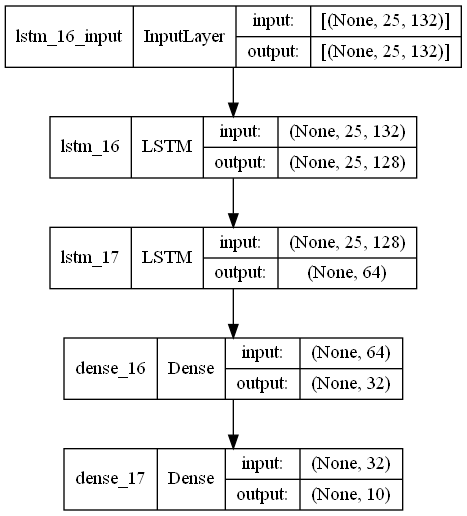

In [139]:
# Visualize
plot_model(lstm2_dense2_rd_lr5_75_b2_default_mc_3, to_file = "arc_lstm2_dense2_rd_lr5_75_b2_default_mc_3_1840_23032022.png", show_shapes = True)

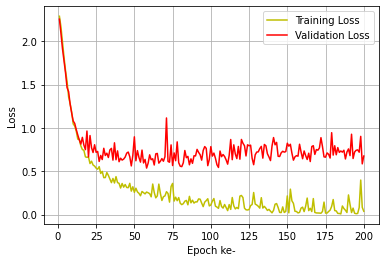

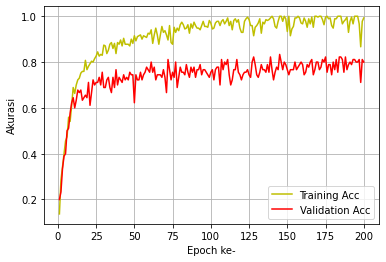

In [265]:
# Plot training and validation

loss9 = history9.history["loss"]
val_loss9 = history9.history["val_loss"]
epochs9 = range(1, len(loss9) + 1)
plt.plot(epochs9, loss9, "y", zorder=3, label="Training Loss")
plt.plot(epochs9, val_loss9, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc9 = history9.history["categorical_accuracy"]
val_acc9 = history9.history["val_categorical_accuracy"]
plt.plot(epochs9, acc9, "y", zorder=3, label="Training Acc")
plt.plot(epochs9, val_acc9, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Akurasi")
plt.legend()
plt.show()

In [266]:
res9 = lstm2_dense2_rd_lr5_75_b2_default_mc_3.predict(X_test)

In [267]:
yhat9 = lstm2_dense2_rd_lr5_75_b2_default_mc_3.predict(X_test)
ytrue9 = np.argmax(y_test, axis=1).tolist()
yhat9 = np.argmax(yhat9, axis=1).tolist()

Confusion matrix, without normalization
[[3 4 2 0 0 0 0 0 0 0]
 [3 6 0 0 0 0 0 0 0 0]
 [3 1 5 0 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 0 1 0]
 [2 0 0 0 7 0 0 0 0 0]
 [0 0 0 0 0 8 1 0 0 0]
 [0 1 0 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 1 0 0 0 0 8 0]
 [0 0 0 0 0 0 0 0 0 9]]


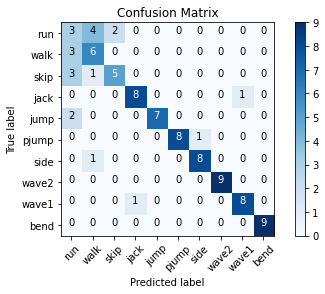

In [279]:
cm9 = confusion_matrix(y_true = ytrue9, y_pred = yhat9)
cm_plot_labels9 = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm9, classes = cm_plot_labels9, title = "Confusion Matrix")

In [280]:
fp9 = cm9.sum(axis=0) - np.diag(cm9)  
fn9 = cm9.sum(axis=1) - np.diag(cm9)
tp9 = np.diag(cm9)
tn9 = cm9.sum() - (fp9 + fn9 + tp9)

print(tp9)
print(fp9)
print(tn9)
print(fn9)

[3 6 5 8 7 8 8 9 8 9]
[8 6 2 1 0 0 1 0 1 0]
[73 75 79 80 81 81 80 81 80 81]
[6 3 4 1 2 1 1 0 1 0]


In [281]:
y_pred9 = lstm2_dense2_rd_lr5_75_b2_default_mc_3.predict(X_test)
y_pred9 = (y_pred9 > 0.5)

In [282]:
_, acc9 = lstm2_dense2_rd_lr5_75_b2_default_mc_3.evaluate(X_test, y_test)
print("Accuracy = ", (acc9*100), " %")

3/3 [==============================] - 0s 30ms/step - loss: 0.7285 - categorical_accuracy: 0.7889
Accuracy =  78.88888716697693  %


In [283]:
loss9_2, acc9_2 = lstm2_dense2_rd_lr5_75_b2_default_mc_3.evaluate(X_train, y_train)
loss9_3, acc9_3 = lstm2_dense2_rd_lr5_75_b2_default_mc_3.evaluate(X_valid, y_valid)

print("Accuracy2 = ", (acc9_2*100), " %")
print("Accuracy3 = ", (acc9_3*100), " %")

3/3 [==============================] - 0s 33ms/step - loss: 0.6710 - categorical_accuracy: 0.8333
Accuracy2 =  99.62962865829468  %
Accuracy3 =  83.33333134651184  %


In [284]:
accuracy_score(ytrue9, yhat9)

0.7888888888888889

In [285]:
acc9 = accuracy_score(ytrue9, yhat9)
acc9

0.7888888888888889

In [286]:
# Error rate
error_rate9 = 1 - acc9
error_rate9

0.21111111111111114

In [287]:
print(classification_report(
      ytrue9,
      yhat9,
      output_dict=False,
      target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.27      0.33      0.30         9
        walk       0.50      0.67      0.57         9
        skip       0.71      0.56      0.63         9
        jack       0.89      0.89      0.89         9
        jump       1.00      0.78      0.88         9
       pjump       1.00      0.89      0.94         9
        side       0.89      0.89      0.89         9
       wave2       1.00      1.00      1.00         9
       wave1       0.89      0.89      0.89         9
        bend       1.00      1.00      1.00         9

    accuracy                           0.79        90
   macro avg       0.82      0.79      0.80        90
weighted avg       0.82      0.79      0.80        90



# va_lstm_sysu_1
LSTM3=100 + dropout3=0,5 + Adam + lr=0,005 + GradientClip- clipnorm=1.0 + w/o TimeDistributed(dense=10) + batchsize=64 + epochs = 200 + ModelCheckpoint -> train:2min 33s, test:81%

EarlyStopping & ReduceLROnPlateu are unused.
if TimeDistributed were used, the output shape would be (none, 25, 10)(3D) + return_sequence should be True

Zhang (2017)
View Adaptive Recurrent Neural Networks for High Performance Human Action Recognition from Skeleton Data

#### Model VA-LSTM SYSU 1st (Chosen)

In [375]:
# Define a sequential model
va_lstm_sysu_1 = Sequential([
    LSTM(100, recurrent_activation="sigmoid", return_sequences=True, implementation=2, input_shape=(25,132)),
    Dropout(0.5),
    LSTM(100, recurrent_activation="sigmoid", return_sequences=True, implementation=2),
    Dropout(0.5),
    LSTM(100, recurrent_activation="sigmoid", return_sequences=False, implementation=2),
    Dropout(0.5),
    Dense(actions.shape[0], activation="softmax")
])

In [376]:
# Compile model with learning rate
va_lstm_sysu_1.compile(Adam(learning_rate=0.005, clipnorm=1.0),
                      loss="categorical_crossentropy",
                      metrics=["categorical_accuracy"])

In [377]:
# Model Checkpoint Callback - reconfig

checkpoint_filepath10 = os.path.join("tmp/mc_va_lstm_sysu_1_e{epoch:04d}_val{val_categorical_accuracy:.3f}.h5")

mc_val_acc = ModelCheckpoint(filepath = checkpoint_filepath10,
                             monitor="val_categorical_accuracy",
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode="max",
                             save_freq="epoch")

# Early Stopping Callback

# es_val_acc = EarlyStopping(monitor="val_categorical_accuracy",
#                            patience=15,
#                            mode='auto')

# ReduceLROnPlateu Callback

# rlrp_val_acc = ReduceLROnPlateau(monitor="val_categorical_accuracy",
#                                  factor=0.1,
#                                  patience=5,
#                                  mode='auto',
#                                  cooldown=3.,
#                                  verbose=1)

In [378]:
%%time
# Training model with validation
history10 = va_lstm_sysu_1.fit(X_train, y_train, batch_size=64, epochs=200, verbose=2,
                             validation_data=(X_valid, y_valid), callbacks=[mc_val_acc])

Epoch 1/200

Epoch 00001: val_categorical_accuracy improved from -inf to 0.10000, saving model to tmp\mc_va_lstm_sysu_1_e0001_val0.100.h5
5/5 - 11s - loss: 2.3950 - categorical_accuracy: 0.0889 - val_loss: 2.3399 - val_categorical_accuracy: 0.1000 - 11s/epoch - 2s/step
Epoch 2/200

Epoch 00002: val_categorical_accuracy improved from 0.10000 to 0.25556, saving model to tmp\mc_va_lstm_sysu_1_e0002_val0.256.h5
5/5 - 1s - loss: 2.3461 - categorical_accuracy: 0.0815 - val_loss: 2.1871 - val_categorical_accuracy: 0.2556 - 836ms/epoch - 167ms/step
Epoch 3/200

Epoch 00003: val_categorical_accuracy did not improve from 0.25556
5/5 - 1s - loss: 2.1217 - categorical_accuracy: 0.1852 - val_loss: 2.1669 - val_categorical_accuracy: 0.2000 - 714ms/epoch - 143ms/step
Epoch 4/200

Epoch 00004: val_categorical_accuracy did not improve from 0.25556
5/5 - 1s - loss: 2.0296 - categorical_accuracy: 0.1852 - val_loss: 1.8913 - val_categorical_accuracy: 0.2111 - 723ms/epoch - 145ms/step
Epoch 5/200

Epoch 00

Epoch 37/200

Epoch 00037: val_categorical_accuracy did not improve from 0.57778
5/5 - 1s - loss: 1.0680 - categorical_accuracy: 0.5926 - val_loss: 1.3547 - val_categorical_accuracy: 0.5222 - 733ms/epoch - 147ms/step
Epoch 38/200

Epoch 00038: val_categorical_accuracy did not improve from 0.57778
5/5 - 1s - loss: 0.9993 - categorical_accuracy: 0.6037 - val_loss: 1.3988 - val_categorical_accuracy: 0.4778 - 696ms/epoch - 139ms/step
Epoch 39/200

Epoch 00039: val_categorical_accuracy did not improve from 0.57778
5/5 - 1s - loss: 1.1290 - categorical_accuracy: 0.5963 - val_loss: 1.0743 - val_categorical_accuracy: 0.5333 - 685ms/epoch - 137ms/step
Epoch 40/200

Epoch 00040: val_categorical_accuracy did not improve from 0.57778
5/5 - 1s - loss: 1.0230 - categorical_accuracy: 0.5778 - val_loss: 1.4659 - val_categorical_accuracy: 0.4111 - 705ms/epoch - 141ms/step
Epoch 41/200

Epoch 00041: val_categorical_accuracy improved from 0.57778 to 0.60000, saving model to tmp\mc_va_lstm_sysu_1_e0041_va

Epoch 74/200

Epoch 00074: val_categorical_accuracy did not improve from 0.73333
5/5 - 1s - loss: 0.5954 - categorical_accuracy: 0.7519 - val_loss: 0.9114 - val_categorical_accuracy: 0.6444 - 685ms/epoch - 137ms/step
Epoch 75/200

Epoch 00075: val_categorical_accuracy did not improve from 0.73333
5/5 - 1s - loss: 0.6281 - categorical_accuracy: 0.7444 - val_loss: 1.0622 - val_categorical_accuracy: 0.5889 - 711ms/epoch - 142ms/step
Epoch 76/200

Epoch 00076: val_categorical_accuracy did not improve from 0.73333
5/5 - 1s - loss: 0.5348 - categorical_accuracy: 0.7815 - val_loss: 0.6613 - val_categorical_accuracy: 0.6889 - 701ms/epoch - 140ms/step
Epoch 77/200

Epoch 00077: val_categorical_accuracy did not improve from 0.73333
5/5 - 1s - loss: 0.4482 - categorical_accuracy: 0.8037 - val_loss: 0.8756 - val_categorical_accuracy: 0.6778 - 730ms/epoch - 146ms/step
Epoch 78/200

Epoch 00078: val_categorical_accuracy did not improve from 0.73333
5/5 - 1s - loss: 0.4805 - categorical_accuracy: 0.8

Epoch 112/200

Epoch 00112: val_categorical_accuracy did not improve from 0.80000
5/5 - 1s - loss: 0.4722 - categorical_accuracy: 0.8222 - val_loss: 0.8077 - val_categorical_accuracy: 0.7667 - 709ms/epoch - 142ms/step
Epoch 113/200

Epoch 00113: val_categorical_accuracy did not improve from 0.80000
5/5 - 1s - loss: 0.3852 - categorical_accuracy: 0.8630 - val_loss: 0.7883 - val_categorical_accuracy: 0.7444 - 700ms/epoch - 140ms/step
Epoch 114/200

Epoch 00114: val_categorical_accuracy did not improve from 0.80000
5/5 - 1s - loss: 0.5644 - categorical_accuracy: 0.8185 - val_loss: 0.6986 - val_categorical_accuracy: 0.7000 - 719ms/epoch - 144ms/step
Epoch 115/200

Epoch 00115: val_categorical_accuracy did not improve from 0.80000
5/5 - 1s - loss: 0.3472 - categorical_accuracy: 0.8778 - val_loss: 0.6699 - val_categorical_accuracy: 0.7556 - 684ms/epoch - 137ms/step
Epoch 116/200

Epoch 00116: val_categorical_accuracy did not improve from 0.80000
5/5 - 1s - loss: 0.3840 - categorical_accuracy

Epoch 149/200

Epoch 00149: val_categorical_accuracy did not improve from 0.84444
5/5 - 1s - loss: 0.1705 - categorical_accuracy: 0.9481 - val_loss: 0.5556 - val_categorical_accuracy: 0.8222 - 716ms/epoch - 143ms/step
Epoch 150/200

Epoch 00150: val_categorical_accuracy did not improve from 0.84444
5/5 - 1s - loss: 0.2154 - categorical_accuracy: 0.9148 - val_loss: 0.6983 - val_categorical_accuracy: 0.7667 - 699ms/epoch - 140ms/step
Epoch 151/200

Epoch 00151: val_categorical_accuracy did not improve from 0.84444
5/5 - 1s - loss: 0.2270 - categorical_accuracy: 0.9296 - val_loss: 0.6551 - val_categorical_accuracy: 0.8000 - 696ms/epoch - 139ms/step
Epoch 152/200

Epoch 00152: val_categorical_accuracy did not improve from 0.84444
5/5 - 1s - loss: 0.1900 - categorical_accuracy: 0.9259 - val_loss: 0.5130 - val_categorical_accuracy: 0.8000 - 701ms/epoch - 140ms/step
Epoch 153/200

Epoch 00153: val_categorical_accuracy did not improve from 0.84444
5/5 - 1s - loss: 0.1719 - categorical_accuracy

Epoch 187/200

Epoch 00187: val_categorical_accuracy did not improve from 0.84444
5/5 - 1s - loss: 0.3658 - categorical_accuracy: 0.8852 - val_loss: 0.6471 - val_categorical_accuracy: 0.8444 - 687ms/epoch - 137ms/step
Epoch 188/200

Epoch 00188: val_categorical_accuracy did not improve from 0.84444
5/5 - 1s - loss: 0.2030 - categorical_accuracy: 0.9259 - val_loss: 0.5207 - val_categorical_accuracy: 0.8111 - 685ms/epoch - 137ms/step
Epoch 189/200

Epoch 00189: val_categorical_accuracy improved from 0.84444 to 0.87778, saving model to tmp\mc_va_lstm_sysu_1_e0189_val0.878.h5
5/5 - 1s - loss: 0.1923 - categorical_accuracy: 0.9407 - val_loss: 0.5696 - val_categorical_accuracy: 0.8778 - 731ms/epoch - 146ms/step
Epoch 190/200

Epoch 00190: val_categorical_accuracy did not improve from 0.87778
5/5 - 1s - loss: 0.1711 - categorical_accuracy: 0.9444 - val_loss: 0.7384 - val_categorical_accuracy: 0.8000 - 688ms/epoch - 138ms/step
Epoch 191/200

Epoch 00191: val_categorical_accuracy did not improv

In [379]:
# Save history to json and csv

# convert the history9.history dict to a pandas DataFrame:     
hist_df_10 = pd.DataFrame(history10.history) 

# save to json:  
hist_json_file_10 = 'history/others/json/va_lstm_sysu_1.json' 
with open(hist_json_file_10, mode='w') as f:
    hist_df_10.to_json(f)

# or save to csv: 
hist_csv_file_10 = 'history/others/csv/va_lstm_sysu_1.csv'
with open(hist_csv_file_10, mode='w') as f:
    hist_df_10.to_csv(f)

In [ ]:
va_lstm_sysu_1.summary()

In [380]:
# Load Model
va_lstm_sysu_1.load_weights("tmp\mc_va_lstm_sysu_1_e0189_val0.878.h5")

In [749]:
# Save Model
va_lstm_sysu_1.save("model/others/va_lstm_sysu_1_e0189_val0.878.h5")

In [ ]:
# Visualize
plot_model(va_lstm_sysu_1, to_file = "arc_lstm2_dense2_rd_lr5_75_b2_default_mc_3_1840_23032022.png", show_shapes = True)

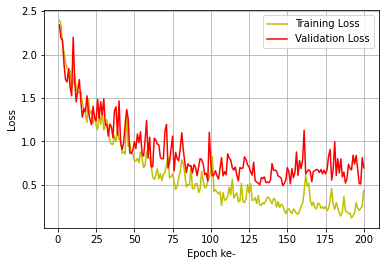

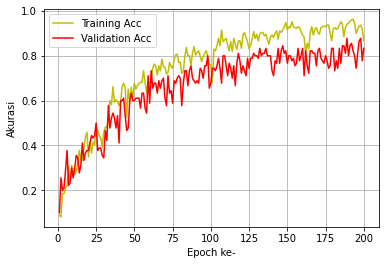

In [381]:
# Plot training and validation

loss10 = history10.history["loss"]
val_loss10 = history10.history["val_loss"]
epochs10 = range(1, len(loss10) + 1)
plt.plot(epochs10, loss10, "y", zorder=3, label="Training Loss")
plt.plot(epochs10, val_loss10, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc10 = history10.history["categorical_accuracy"]
val_acc10 = history10.history["val_categorical_accuracy"]
plt.plot(epochs10, acc10, "y", zorder=3, label="Training Acc")
plt.plot(epochs10, val_acc10, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Akurasi")
plt.legend()
plt.show()

In [37]:
df_10 = pd.read_csv("history/others/csv/va_lstm_sysu_1.csv")
df_10.head()

Unnamed: 0      loss  categorical_accuracy  val_loss  \
0           0  2.395023              0.088889  2.339947   
1           1  2.346143              0.081481  2.187079   
2           2  2.121731              0.185185  2.166874   
3           3  2.029579              0.185185  1.891293   
4           4  1.907895              0.211111  1.711890   

   val_categorical_accuracy  
0                  0.100000  
1                  0.255556  
2                  0.200000  
3                  0.211111  
4                  0.288889

In [36]:
df_10_processed = df_10.copy(deep=True)

df_10_processed["categorical_accuracy"] = df_10_processed["categorical_accuracy"]*100
df_10_processed["val_categorical_accuracy"] = df_10_processed["val_categorical_accuracy"]*100

df_10_processed

Unnamed: 0      loss  categorical_accuracy  val_loss  \
0             0  2.395023              8.888889  2.339947   
1             1  2.346143              8.148148  2.187079   
2             2  2.121731             18.518518  2.166874   
3             3  2.029579             18.518518  1.891293   
4             4  1.907895             21.111111  1.711890   
..          ...       ...                   ...       ...   
195         195  0.230691             91.851854  0.686018   
196         196  0.207225             93.333334  0.516552   
197         197  0.229873             93.703705  0.511015   
198         198  0.259535             91.851854  0.815437   
199         199  0.438355             86.666667  0.696196   

     val_categorical_accuracy  
0                   10.000000  
1                   25.555557  
2                   20.000000  
3                   21.111111  
4                   28.888890  
..                        ...  
195                 81.111109  
196                 86.666667  
197                 87.777776  
198                 77.777779  
199                 83.333331  

[200 rows x 5 columns]

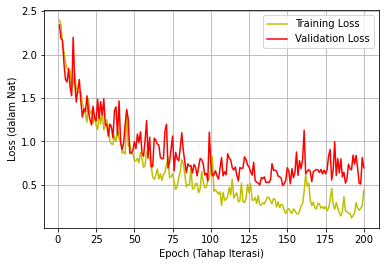

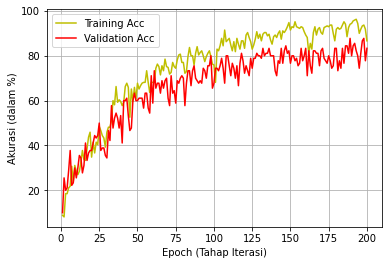

In [38]:
# Plot training and validation

loss10_2 = df_10_processed["loss"]
val_loss10_2 = df_10_processed["val_loss"]
epochs10_2 = range(1, len(loss10_2) + 1)
plt.plot(epochs10_2, loss10_2, "y", zorder=3, label="Training Loss")
plt.plot(epochs10_2, val_loss10_2, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch (Tahap Iterasi)")
plt.ylabel("Loss (dalam Nat)")
plt.legend()
plt.show()

acc10_2 = df_10_processed["categorical_accuracy"]
val_acc10_2 = df_10_processed["val_categorical_accuracy"]
plt.plot(epochs10_2, acc10_2, "y", zorder=3, label="Training Acc")
plt.plot(epochs10_2, val_acc10_2, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch (Tahap Iterasi)")
plt.ylabel("Akurasi (dalam %)")
plt.legend()
plt.show()

In [382]:
res10 = va_lstm_sysu_1.predict(X_test)

In [383]:
yhat10 = va_lstm_sysu_1.predict(X_test)
ytrue10 = np.argmax(y_test, axis=1).tolist()
yhat10 = np.argmax(yhat10, axis=1).tolist()

Confusion matrix, without normalization
[[4 1 3 0 1 0 0 0 0 0]
 [1 5 2 0 1 0 0 0 0 0]
 [3 2 4 0 0 0 0 0 0 0]
 [0 0 0 9 0 0 0 0 0 0]
 [0 0 1 0 8 0 0 0 0 0]
 [0 0 0 0 0 8 1 0 0 0]
 [1 0 0 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 0 9 0]
 [0 0 0 0 0 0 0 0 0 9]]


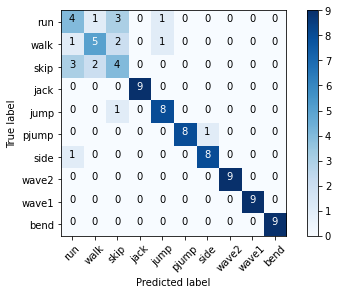

In [384]:
cm10 = confusion_matrix(y_true = ytrue10, y_pred = yhat10)
cm_plot_labels10 = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm10, classes = cm_plot_labels10, title = "")

In [385]:
fp10 = cm10.sum(axis=0) - np.diag(cm10)  
fn10 = cm10.sum(axis=1) - np.diag(cm10)
tp10 = np.diag(cm10)
tn10 = cm10.sum() - (fp10 + fn10 + tp10)

print(tp10)
print(fp10)
print(tn10)
print(fn10)

[4 5 4 9 8 8 8 9 9 9]
[5 3 6 0 2 0 1 0 0 0]
[76 78 75 81 79 81 80 81 81 81]
[5 4 5 0 1 1 1 0 0 0]


In [386]:
y_pred10 = va_lstm_sysu_1.predict(X_test)
y_pred10 = (y_pred10 > 0.5)

In [387]:
_, acc10 = va_lstm_sysu_1.evaluate(X_test, y_test)
print("Accuracy = ", (acc10*100), " %")

3/3 [==============================] - 0s 33ms/step - loss: 0.6747 - categorical_accuracy: 0.8111
Accuracy =  81.11110925674438  %


In [388]:
loss10_2, acc10_2 = va_lstm_sysu_1.evaluate(X_train, y_train)
loss10_3, acc10_3 = va_lstm_sysu_1.evaluate(X_valid, y_valid)

print("Accuracy2 = ", (acc10_2*100), " %")
print("Accuracy3 = ", (acc10_3*100), " %")

3/3 [==============================] - 0s 35ms/step - loss: 0.5696 - categorical_accuracy: 0.8778
Accuracy2 =  98.51852059364319  %
Accuracy3 =  87.77777552604675  %


In [389]:
accuracy_score(ytrue10, yhat10)

0.8111111111111111

In [390]:
acc10 = accuracy_score(ytrue10, yhat10)
acc10

0.8111111111111111

In [391]:
# Error rate
error_rate10 = 1 - acc10
error_rate10

0.18888888888888888

In [392]:
print(classification_report(
      ytrue10,
      yhat10,
      output_dict=False,
      target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.44      0.44      0.44         9
        walk       0.62      0.56      0.59         9
        skip       0.40      0.44      0.42         9
        jack       1.00      1.00      1.00         9
        jump       0.80      0.89      0.84         9
       pjump       1.00      0.89      0.94         9
        side       0.89      0.89      0.89         9
       wave2       1.00      1.00      1.00         9
       wave1       1.00      1.00      1.00         9
        bend       1.00      1.00      1.00         9

    accuracy                           0.81        90
   macro avg       0.82      0.81      0.81        90
weighted avg       0.82      0.81      0.81        90



# va_lstm_sysu_2
LSTM3=100 + dropout3=0,5 + Adam + lr=0,005 + GradientClip- clipnorm=1.0 + w/o TimeDistributed(dense=10) + batchsize=64 + epochs = 200 + ModelCheckpoint -> train:2min 40s, test:76.66%

EarlyStopping & ReduceLROnPlateu are unused.
if TimeDistributed were used, the output shape would be (none, 25, 10)(3D) + return_sequence should be True 
#### Model VA-LSTM SYSU 2nd

In [395]:
# Define a sequential model
va_lstm_sysu_2 = Sequential([
    LSTM(100, recurrent_activation="sigmoid", return_sequences=True, implementation=2, input_shape=(25,132)),
    Dropout(0.5),
    LSTM(100, recurrent_activation="sigmoid", return_sequences=True, implementation=2),
    Dropout(0.5),
    LSTM(100, recurrent_activation="sigmoid", return_sequences=False, implementation=2),
    Dropout(0.5),
    Dense(actions.shape[0], activation="softmax")
])

In [396]:
# Compile model with learning rate
va_lstm_sysu_2.compile(Adam(learning_rate=0.005, clipnorm=1.0),
                      loss="categorical_crossentropy",
                      metrics=["categorical_accuracy"])

In [397]:
# Model Checkpoint Callback - reconfig

checkpoint_filepath11 = os.path.join("tmp/mc_va_lstm_sysu_2_e{epoch:04d}_val{val_categorical_accuracy:.3f}.h5")

mc_val_acc = ModelCheckpoint(filepath = checkpoint_filepath11,
                             monitor="val_categorical_accuracy",
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode="max",
                             save_freq="epoch")

In [398]:
%%time
# Training model with validation
history11 = va_lstm_sysu_2.fit(X_train, y_train, batch_size=64, epochs=200, verbose=2,
                             validation_data=(X_valid, y_valid), callbacks=[mc_val_acc])

Epoch 1/200

Epoch 00001: val_categorical_accuracy improved from -inf to 0.14444, saving model to tmp\mc_va_lstm_sysu_2_e0001_val0.144.h5
5/5 - 13s - loss: 2.3589 - categorical_accuracy: 0.0889 - val_loss: 2.2538 - val_categorical_accuracy: 0.1444 - 13s/epoch - 3s/step
Epoch 2/200

Epoch 00002: val_categorical_accuracy improved from 0.14444 to 0.27778, saving model to tmp\mc_va_lstm_sysu_2_e0002_val0.278.h5
5/5 - 1s - loss: 2.2613 - categorical_accuracy: 0.1667 - val_loss: 1.8880 - val_categorical_accuracy: 0.2778 - 751ms/epoch - 150ms/step
Epoch 3/200

Epoch 00003: val_categorical_accuracy did not improve from 0.27778
5/5 - 1s - loss: 1.9614 - categorical_accuracy: 0.2148 - val_loss: 1.9913 - val_categorical_accuracy: 0.2556 - 738ms/epoch - 148ms/step
Epoch 4/200

Epoch 00004: val_categorical_accuracy improved from 0.27778 to 0.36667, saving model to tmp\mc_va_lstm_sysu_2_e0004_val0.367.h5
5/5 - 1s - loss: 1.9503 - categorical_accuracy: 0.2185 - val_loss: 1.5900 - val_categorical_accu


Epoch 00036: val_categorical_accuracy did not improve from 0.61111
5/5 - 1s - loss: 1.1165 - categorical_accuracy: 0.5407 - val_loss: 1.0184 - val_categorical_accuracy: 0.6111 - 904ms/epoch - 181ms/step
Epoch 37/200

Epoch 00037: val_categorical_accuracy improved from 0.61111 to 0.62222, saving model to tmp\mc_va_lstm_sysu_2_e0037_val0.622.h5
5/5 - 1s - loss: 0.9152 - categorical_accuracy: 0.6481 - val_loss: 0.9175 - val_categorical_accuracy: 0.6222 - 944ms/epoch - 189ms/step
Epoch 38/200

Epoch 00038: val_categorical_accuracy did not improve from 0.62222
5/5 - 1s - loss: 0.8645 - categorical_accuracy: 0.7000 - val_loss: 0.8926 - val_categorical_accuracy: 0.6222 - 885ms/epoch - 177ms/step
Epoch 39/200

Epoch 00039: val_categorical_accuracy did not improve from 0.62222
5/5 - 1s - loss: 0.8236 - categorical_accuracy: 0.6630 - val_loss: 1.0167 - val_categorical_accuracy: 0.5667 - 918ms/epoch - 184ms/step
Epoch 40/200

Epoch 00040: val_categorical_accuracy did not improve from 0.62222
5/5

Epoch 72/200

Epoch 00072: val_categorical_accuracy did not improve from 0.73333
5/5 - 1s - loss: 0.6173 - categorical_accuracy: 0.7481 - val_loss: 0.9580 - val_categorical_accuracy: 0.6556 - 708ms/epoch - 142ms/step
Epoch 73/200

Epoch 00073: val_categorical_accuracy did not improve from 0.73333
5/5 - 1s - loss: 0.6070 - categorical_accuracy: 0.7481 - val_loss: 0.7562 - val_categorical_accuracy: 0.6556 - 718ms/epoch - 144ms/step
Epoch 74/200

Epoch 00074: val_categorical_accuracy did not improve from 0.73333
5/5 - 1s - loss: 0.5910 - categorical_accuracy: 0.7593 - val_loss: 0.6538 - val_categorical_accuracy: 0.7000 - 718ms/epoch - 144ms/step
Epoch 75/200

Epoch 00075: val_categorical_accuracy did not improve from 0.73333
5/5 - 1s - loss: 0.5271 - categorical_accuracy: 0.7519 - val_loss: 0.7057 - val_categorical_accuracy: 0.6889 - 720ms/epoch - 144ms/step
Epoch 76/200

Epoch 00076: val_categorical_accuracy did not improve from 0.73333
5/5 - 1s - loss: 0.4693 - categorical_accuracy: 0.8

Epoch 109/200

Epoch 00109: val_categorical_accuracy did not improve from 0.81111
5/5 - 1s - loss: 0.2785 - categorical_accuracy: 0.9074 - val_loss: 0.4764 - val_categorical_accuracy: 0.8000 - 713ms/epoch - 143ms/step
Epoch 110/200

Epoch 00110: val_categorical_accuracy improved from 0.81111 to 0.83333, saving model to tmp\mc_va_lstm_sysu_2_e0110_val0.833.h5
5/5 - 1s - loss: 0.2877 - categorical_accuracy: 0.8926 - val_loss: 0.4332 - val_categorical_accuracy: 0.8333 - 838ms/epoch - 168ms/step
Epoch 111/200

Epoch 00111: val_categorical_accuracy did not improve from 0.83333
5/5 - 1s - loss: 0.3308 - categorical_accuracy: 0.8593 - val_loss: 0.5149 - val_categorical_accuracy: 0.7667 - 697ms/epoch - 139ms/step
Epoch 112/200

Epoch 00112: val_categorical_accuracy did not improve from 0.83333
5/5 - 1s - loss: 0.3902 - categorical_accuracy: 0.8926 - val_loss: 0.5228 - val_categorical_accuracy: 0.8222 - 716ms/epoch - 143ms/step
Epoch 113/200

Epoch 00113: val_categorical_accuracy did not improv

Epoch 146/200

Epoch 00146: val_categorical_accuracy did not improve from 0.85556
5/5 - 1s - loss: 0.2155 - categorical_accuracy: 0.9259 - val_loss: 0.5414 - val_categorical_accuracy: 0.8222 - 728ms/epoch - 146ms/step
Epoch 147/200

Epoch 00147: val_categorical_accuracy did not improve from 0.85556
5/5 - 1s - loss: 0.3138 - categorical_accuracy: 0.9074 - val_loss: 0.9008 - val_categorical_accuracy: 0.7333 - 745ms/epoch - 149ms/step
Epoch 148/200

Epoch 00148: val_categorical_accuracy did not improve from 0.85556
5/5 - 1s - loss: 0.4431 - categorical_accuracy: 0.8704 - val_loss: 0.4768 - val_categorical_accuracy: 0.8222 - 753ms/epoch - 151ms/step
Epoch 149/200

Epoch 00149: val_categorical_accuracy did not improve from 0.85556
5/5 - 1s - loss: 0.2532 - categorical_accuracy: 0.9000 - val_loss: 0.9882 - val_categorical_accuracy: 0.7333 - 768ms/epoch - 154ms/step
Epoch 150/200

Epoch 00150: val_categorical_accuracy did not improve from 0.85556
5/5 - 1s - loss: 0.4035 - categorical_accuracy

Epoch 184/200

Epoch 00184: val_categorical_accuracy did not improve from 0.85556
5/5 - 1s - loss: 0.2512 - categorical_accuracy: 0.9074 - val_loss: 0.7145 - val_categorical_accuracy: 0.7889 - 702ms/epoch - 140ms/step
Epoch 185/200

Epoch 00185: val_categorical_accuracy did not improve from 0.85556
5/5 - 1s - loss: 0.5598 - categorical_accuracy: 0.8444 - val_loss: 0.8138 - val_categorical_accuracy: 0.7222 - 712ms/epoch - 142ms/step
Epoch 186/200

Epoch 00186: val_categorical_accuracy did not improve from 0.85556
5/5 - 1s - loss: 0.4139 - categorical_accuracy: 0.8370 - val_loss: 0.6744 - val_categorical_accuracy: 0.7889 - 721ms/epoch - 144ms/step
Epoch 187/200

Epoch 00187: val_categorical_accuracy did not improve from 0.85556
5/5 - 1s - loss: 0.2701 - categorical_accuracy: 0.9074 - val_loss: 0.5634 - val_categorical_accuracy: 0.8222 - 712ms/epoch - 142ms/step
Epoch 188/200

Epoch 00188: val_categorical_accuracy did not improve from 0.85556
5/5 - 1s - loss: 0.2247 - categorical_accuracy

In [399]:
# Save history to json and csv

# convert the history11.history dict to a pandas DataFrame:     
hist_df_11 = pd.DataFrame(history11.history) 

# save to json:  
hist_json_file_11 = 'history/others/json/va_lstm_sysu_2.json' 
with open(hist_json_file_11, mode='w') as f:
    hist_df_11.to_json(f)

# or save to csv: 
hist_csv_file_11 = 'history/others/csv/va_lstm_sysu_2.csv'
with open(hist_csv_file_11, mode='w') as f:
    hist_df_11.to_csv(f)

In [ ]:
va_lstm_sysu_2.summary()

In [400]:
# Load Model
va_lstm_sysu_2.load_weights("tmp\mc_va_lstm_sysu_2_e0144_val0.856.h5")

In [ ]:
# Save Model
va_lstm_sysu_2.save("model2\lstm2_dense2_rd_lr5_75_b2_default_mc_3_e0116_val0.833.h5")

In [ ]:
# Visualize
plot_model(va_lstm_sysu_2, to_file = "arc_lstm2_dense2_rd_lr5_75_b2_default_mc_3_1840_23032022.png", show_shapes = True)

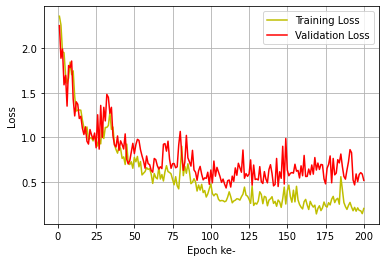

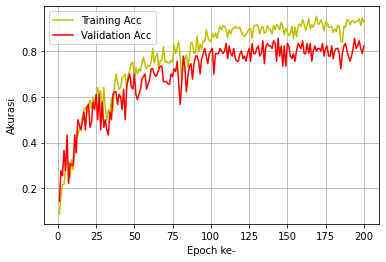

In [401]:
# Plot training and validation

loss11 = history11.history["loss"]
val_loss11 = history11.history["val_loss"]
epochs11 = range(1, len(loss11) + 1)
plt.plot(epochs11, loss11, "y", zorder=3, label="Training Loss")
plt.plot(epochs11, val_loss11, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc11 = history11.history["categorical_accuracy"]
val_acc11 = history11.history["val_categorical_accuracy"]
plt.plot(epochs11, acc11, "y", zorder=3, label="Training Acc")
plt.plot(epochs11, val_acc11, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Akurasi")
plt.legend()
plt.show()

In [402]:
res11 = va_lstm_sysu_2.predict(X_test)

In [403]:
yhat11 = va_lstm_sysu_2.predict(X_test)
ytrue11 = np.argmax(y_test, axis=1).tolist()
yhat11 = np.argmax(yhat11, axis=1).tolist()

Confusion matrix, without normalization
[[3 4 2 0 0 0 0 0 0 0]
 [2 6 0 0 1 0 0 0 0 0]
 [3 1 3 0 2 0 0 0 0 0]
 [0 0 0 9 0 0 0 0 0 0]
 [0 0 1 0 8 0 0 0 0 0]
 [0 0 0 0 0 6 3 0 0 0]
 [0 0 1 0 0 1 7 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 0 9 0]
 [0 0 0 0 0 0 0 0 0 9]]


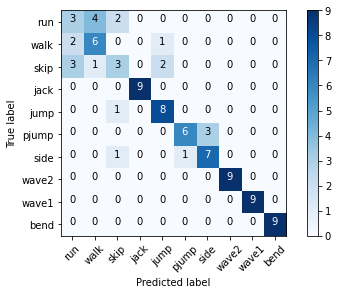

In [404]:
cm11 = confusion_matrix(y_true = ytrue11, y_pred = yhat11)
cm_plot_labels11 = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm11, classes = cm_plot_labels11, title = "")

In [405]:
fp11 = cm11.sum(axis=0) - np.diag(cm11)  
fn11 = cm11.sum(axis=1) - np.diag(cm11)
tp11 = np.diag(cm11)
tn11 = cm11.sum() - (fp11 + fn11 + tp11)

print(tp11)
print(fp11)
print(tn11)
print(fn11)

[3 6 3 9 8 6 7 9 9 9]
[5 5 4 0 3 1 3 0 0 0]
[76 76 77 81 78 80 78 81 81 81]
[6 3 6 0 1 3 2 0 0 0]


In [406]:
y_pred11 = va_lstm_sysu_2.predict(X_test)
y_pred11 = (y_pred11 > 0.5)

In [407]:
_, acc11 = va_lstm_sysu_2.evaluate(X_test, y_test)
print("Accuracy = ", (acc11*100), " %")

3/3 [==============================] - 0s 34ms/step - loss: 0.8250 - categorical_accuracy: 0.7667
Accuracy =  76.66666507720947  %


In [408]:
loss11_2, acc11_2 = va_lstm_sysu_2.evaluate(X_train, y_train)
loss11_3, acc11_3 = va_lstm_sysu_2.evaluate(X_valid, y_valid)

print("Accuracy2 = ", (acc11_2*100), " %")
print("Accuracy3 = ", (acc11_3*100), " %")

3/3 [==============================] - 0s 33ms/step - loss: 0.4495 - categorical_accuracy: 0.8556
Accuracy2 =  94.81481313705444  %
Accuracy3 =  85.5555534362793  %


In [409]:
accuracy_score(ytrue11, yhat11)

0.7666666666666667

In [410]:
acc11 = accuracy_score(ytrue11, yhat11)
acc11

0.7666666666666667

In [411]:
# Error rate
error_rate11 = 1 - acc11
error_rate11

0.23333333333333328

In [412]:
print(classification_report(
      ytrue11,
      yhat11,
      output_dict=False,
      target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.38      0.33      0.35         9
        walk       0.55      0.67      0.60         9
        skip       0.43      0.33      0.38         9
        jack       1.00      1.00      1.00         9
        jump       0.73      0.89      0.80         9
       pjump       0.86      0.67      0.75         9
        side       0.70      0.78      0.74         9
       wave2       1.00      1.00      1.00         9
       wave1       1.00      1.00      1.00         9
        bend       1.00      1.00      1.00         9

    accuracy                           0.77        90
   macro avg       0.76      0.77      0.76        90
weighted avg       0.76      0.77      0.76        90



# va_lstm_sysu_3
LSTM3=100 + dropout3=0,5 + Adam + lr=0,005 + GradientClip- clipnorm=1.0 + w/o TimeDistributed(dense=10) + batchsize=64 + epochs = 200 + ModelCheckpoint -> train:2min 36s, test:73.33%

EarlyStopping & ReduceLROnPlateu are unused.
if TimeDistributed were used, the output shape would be (none, 25, 10)(3D) + return_sequence should be True 
#### Model VA-LSTM SYSU 3rd

In [413]:
# Define a sequential model
va_lstm_sysu_3 = Sequential([
    LSTM(100, recurrent_activation="sigmoid", return_sequences=True, implementation=2, input_shape=(25,132)),
    Dropout(0.5),
    LSTM(100, recurrent_activation="sigmoid", return_sequences=True, implementation=2),
    Dropout(0.5),
    LSTM(100, recurrent_activation="sigmoid", return_sequences=False, implementation=2),
    Dropout(0.5),
    Dense(actions.shape[0], activation="softmax")
])

In [414]:
# Compile model with learning rate
va_lstm_sysu_3.compile(Adam(learning_rate=0.005, clipnorm=1.0),
                      loss="categorical_crossentropy",
                      metrics=["categorical_accuracy"])

In [415]:
# Model Checkpoint Callback - reconfig

checkpoint_filepath12 = os.path.join("tmp/mc_va_lstm_sysu_3_e{epoch:04d}_val{val_categorical_accuracy:.3f}.h5")

mc_val_acc = ModelCheckpoint(filepath = checkpoint_filepath12,
                             monitor="val_categorical_accuracy",
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode="max",
                             save_freq="epoch")

In [416]:
%%time
# Training model with validation
history12 = va_lstm_sysu_3.fit(X_train, y_train, batch_size=64, epochs=200, verbose=2,
                             validation_data=(X_valid, y_valid), callbacks=[mc_val_acc])

Epoch 1/200

Epoch 00001: val_categorical_accuracy improved from -inf to 0.10000, saving model to tmp\mc_va_lstm_sysu_3_e0001_val0.100.h5
5/5 - 10s - loss: 2.3710 - categorical_accuracy: 0.0852 - val_loss: 2.2916 - val_categorical_accuracy: 0.1000 - 10s/epoch - 2s/step
Epoch 2/200

Epoch 00002: val_categorical_accuracy did not improve from 0.10000
5/5 - 1s - loss: 2.3483 - categorical_accuracy: 0.0963 - val_loss: 2.3540 - val_categorical_accuracy: 0.0667 - 741ms/epoch - 148ms/step
Epoch 3/200

Epoch 00003: val_categorical_accuracy improved from 0.10000 to 0.20000, saving model to tmp\mc_va_lstm_sysu_3_e0003_val0.200.h5
5/5 - 1s - loss: 2.2740 - categorical_accuracy: 0.1259 - val_loss: 1.9939 - val_categorical_accuracy: 0.2000 - 757ms/epoch - 151ms/step
Epoch 4/200

Epoch 00004: val_categorical_accuracy improved from 0.20000 to 0.21111, saving model to tmp\mc_va_lstm_sysu_3_e0004_val0.211.h5
5/5 - 1s - loss: 2.0800 - categorical_accuracy: 0.1889 - val_loss: 1.9583 - val_categorical_accu

Epoch 36/200

Epoch 00036: val_categorical_accuracy did not improve from 0.57778
5/5 - 1s - loss: 1.0114 - categorical_accuracy: 0.6000 - val_loss: 1.2417 - val_categorical_accuracy: 0.5111 - 737ms/epoch - 147ms/step
Epoch 37/200

Epoch 00037: val_categorical_accuracy did not improve from 0.57778
5/5 - 1s - loss: 0.9831 - categorical_accuracy: 0.5926 - val_loss: 1.0962 - val_categorical_accuracy: 0.5556 - 711ms/epoch - 142ms/step
Epoch 38/200

Epoch 00038: val_categorical_accuracy improved from 0.57778 to 0.60000, saving model to tmp\mc_va_lstm_sysu_3_e0038_val0.600.h5
5/5 - 1s - loss: 0.9924 - categorical_accuracy: 0.5889 - val_loss: 0.9508 - val_categorical_accuracy: 0.6000 - 754ms/epoch - 151ms/step
Epoch 39/200

Epoch 00039: val_categorical_accuracy did not improve from 0.60000
5/5 - 1s - loss: 0.8650 - categorical_accuracy: 0.6444 - val_loss: 1.7025 - val_categorical_accuracy: 0.3444 - 711ms/epoch - 142ms/step
Epoch 40/200

Epoch 00040: val_categorical_accuracy did not improve fro

Epoch 73/200

Epoch 00073: val_categorical_accuracy did not improve from 0.73333
5/5 - 1s - loss: 0.5498 - categorical_accuracy: 0.7593 - val_loss: 0.6993 - val_categorical_accuracy: 0.6667 - 749ms/epoch - 150ms/step
Epoch 74/200

Epoch 00074: val_categorical_accuracy did not improve from 0.73333
5/5 - 1s - loss: 0.5739 - categorical_accuracy: 0.7704 - val_loss: 0.7792 - val_categorical_accuracy: 0.6778 - 712ms/epoch - 142ms/step
Epoch 75/200

Epoch 00075: val_categorical_accuracy improved from 0.73333 to 0.75556, saving model to tmp\mc_va_lstm_sysu_3_e0075_val0.756.h5
5/5 - 1s - loss: 0.6359 - categorical_accuracy: 0.7333 - val_loss: 0.6432 - val_categorical_accuracy: 0.7556 - 753ms/epoch - 151ms/step
Epoch 76/200

Epoch 00076: val_categorical_accuracy did not improve from 0.75556
5/5 - 1s - loss: 0.5633 - categorical_accuracy: 0.7667 - val_loss: 0.9224 - val_categorical_accuracy: 0.6556 - 714ms/epoch - 143ms/step
Epoch 77/200

Epoch 00077: val_categorical_accuracy did not improve fro

Epoch 111/200

Epoch 00111: val_categorical_accuracy did not improve from 0.75556
5/5 - 1s - loss: 0.4290 - categorical_accuracy: 0.8148 - val_loss: 0.6947 - val_categorical_accuracy: 0.7333 - 712ms/epoch - 142ms/step
Epoch 112/200

Epoch 00112: val_categorical_accuracy did not improve from 0.75556
5/5 - 1s - loss: 0.3989 - categorical_accuracy: 0.8370 - val_loss: 0.7878 - val_categorical_accuracy: 0.6667 - 715ms/epoch - 143ms/step
Epoch 113/200

Epoch 00113: val_categorical_accuracy did not improve from 0.75556
5/5 - 1s - loss: 0.6700 - categorical_accuracy: 0.7407 - val_loss: 0.5921 - val_categorical_accuracy: 0.7444 - 719ms/epoch - 144ms/step
Epoch 114/200

Epoch 00114: val_categorical_accuracy did not improve from 0.75556
5/5 - 1s - loss: 0.5546 - categorical_accuracy: 0.7593 - val_loss: 0.6956 - val_categorical_accuracy: 0.7556 - 730ms/epoch - 146ms/step
Epoch 115/200

Epoch 00115: val_categorical_accuracy did not improve from 0.75556
5/5 - 1s - loss: 0.3992 - categorical_accuracy

Epoch 148/200

Epoch 00148: val_categorical_accuracy did not improve from 0.78889
5/5 - 1s - loss: 0.5319 - categorical_accuracy: 0.8074 - val_loss: 0.7456 - val_categorical_accuracy: 0.7556 - 718ms/epoch - 144ms/step
Epoch 149/200

Epoch 00149: val_categorical_accuracy did not improve from 0.78889
5/5 - 1s - loss: 0.4327 - categorical_accuracy: 0.8296 - val_loss: 0.7595 - val_categorical_accuracy: 0.7333 - 733ms/epoch - 147ms/step
Epoch 150/200

Epoch 00150: val_categorical_accuracy did not improve from 0.78889
5/5 - 1s - loss: 0.3602 - categorical_accuracy: 0.8815 - val_loss: 0.6859 - val_categorical_accuracy: 0.7667 - 717ms/epoch - 143ms/step
Epoch 151/200

Epoch 00151: val_categorical_accuracy did not improve from 0.78889
5/5 - 1s - loss: 0.3641 - categorical_accuracy: 0.8815 - val_loss: 0.6979 - val_categorical_accuracy: 0.7444 - 748ms/epoch - 150ms/step
Epoch 152/200

Epoch 00152: val_categorical_accuracy did not improve from 0.78889
5/5 - 1s - loss: 0.2930 - categorical_accuracy


Epoch 00185: val_categorical_accuracy did not improve from 0.82222
5/5 - 1s - loss: 0.3604 - categorical_accuracy: 0.8741 - val_loss: 0.6722 - val_categorical_accuracy: 0.7778 - 750ms/epoch - 150ms/step
Epoch 186/200

Epoch 00186: val_categorical_accuracy did not improve from 0.82222
5/5 - 1s - loss: 0.3100 - categorical_accuracy: 0.8963 - val_loss: 0.7613 - val_categorical_accuracy: 0.7667 - 714ms/epoch - 143ms/step
Epoch 187/200

Epoch 00187: val_categorical_accuracy did not improve from 0.82222
5/5 - 1s - loss: 0.2445 - categorical_accuracy: 0.9000 - val_loss: 1.0919 - val_categorical_accuracy: 0.7111 - 701ms/epoch - 140ms/step
Epoch 188/200

Epoch 00188: val_categorical_accuracy did not improve from 0.82222
5/5 - 1s - loss: 0.2853 - categorical_accuracy: 0.8852 - val_loss: 1.2400 - val_categorical_accuracy: 0.6444 - 702ms/epoch - 140ms/step
Epoch 189/200

Epoch 00189: val_categorical_accuracy did not improve from 0.82222
5/5 - 1s - loss: 0.4668 - categorical_accuracy: 0.8407 - val

In [417]:
# Save history to json and csv

# convert the history12.history dict to a pandas DataFrame:     
hist_df_12 = pd.DataFrame(history12.history) 

# save to json:  
hist_json_file_12 = 'history/others/json/va_lstm_sysu_3.json' 
with open(hist_json_file_12, mode='w') as f:
    hist_df_12.to_json(f)

# or save to csv: 
hist_csv_file_12 = 'history/others/csv/va_lstm_sysu_3.csv'
with open(hist_csv_file_12, mode='w') as f:
    hist_df_12.to_csv(f)

In [ ]:
va_lstm_sysu_3.summary()

In [418]:
# Load Model
va_lstm_sysu_3.load_weights("tmp\mc_va_lstm_sysu_3_e0190_val0.833.h5")

In [ ]:
# Save Model
va_lstm_sysu_3.save("model2\lstm2_dense2_rd_lr5_75_b2_default_mc_3_e0116_val0.833.h5")

In [ ]:
# Visualize
plot_model(va_lstm_sysu_3, to_file = "arc_lstm2_dense2_rd_lr5_75_b2_default_mc_3_1840_23032022.png", show_shapes = True)

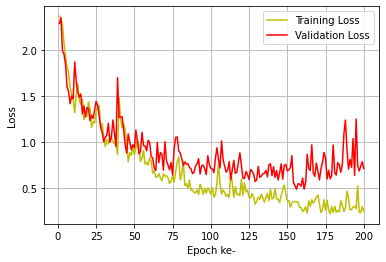

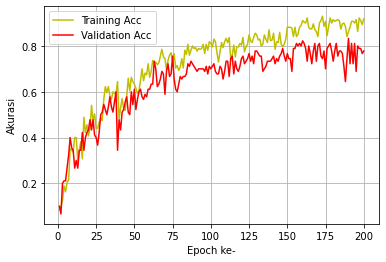

In [419]:
# Plot training and validation

loss12 = history12.history["loss"]
val_loss12 = history12.history["val_loss"]
epochs12 = range(1, len(loss12) + 1)
plt.plot(epochs12, loss12, "y", zorder=3, label="Training Loss")
plt.plot(epochs12, val_loss12, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc12 = history12.history["categorical_accuracy"]
val_acc12 = history12.history["val_categorical_accuracy"]
plt.plot(epochs12, acc12, "y", zorder=3, label="Training Acc")
plt.plot(epochs12, val_acc12, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Akurasi")
plt.legend()
plt.show()

In [420]:
res12 = va_lstm_sysu_3.predict(X_test)

In [421]:
yhat12 = va_lstm_sysu_3.predict(X_test)
ytrue12 = np.argmax(y_test, axis=1).tolist()
yhat12 = np.argmax(yhat12, axis=1).tolist()

Confusion matrix, without normalization
[[5 4 0 0 0 0 0 0 0 0]
 [2 7 0 0 0 0 0 0 0 0]
 [7 1 1 0 0 0 0 0 0 0]
 [0 0 0 8 0 0 0 1 0 0]
 [1 0 1 0 7 0 0 0 0 0]
 [0 0 0 0 0 8 1 0 0 0]
 [1 0 0 0 0 3 5 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 2 7 0]
 [0 0 0 0 0 0 0 0 0 9]]


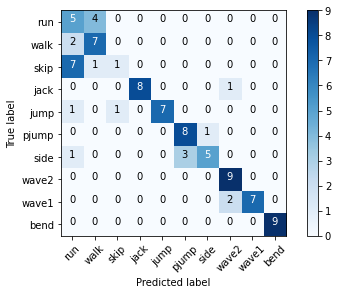

In [422]:
cm12 = confusion_matrix(y_true = ytrue12, y_pred = yhat12)
cm_plot_labels12 = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm12, classes = cm_plot_labels12, title = "")

In [423]:
fp12 = cm12.sum(axis=0) - np.diag(cm12)  
fn12 = cm12.sum(axis=1) - np.diag(cm12)
tp12 = np.diag(cm12)
tn12 = cm12.sum() - (fp12 + fn12 + tp12)

print(tp12)
print(fp12)
print(tn12)
print(fn12)

[5 7 1 8 7 8 5 9 7 9]
[11  5  1  0  0  3  1  3  0  0]
[70 76 80 81 81 78 80 78 81 81]
[4 2 8 1 2 1 4 0 2 0]


In [424]:
y_pred12 = va_lstm_sysu_3.predict(X_test)
y_pred12 = (y_pred12 > 0.5)

In [425]:
_, acc12 = va_lstm_sysu_3.evaluate(X_test, y_test)
print("Accuracy = ", (acc12*100), " %")

3/3 [==============================] - 0s 35ms/step - loss: 1.0952 - categorical_accuracy: 0.7333
Accuracy =  73.33333492279053  %


In [431]:
loss12_2, acc12_2 = va_lstm_sysu_3.evaluate(X_train, y_train)
loss12_3, acc12_3 = va_lstm_sysu_3.evaluate(X_valid, y_valid)

print("Accuracy2 = ", (acc12_2*100), " %")
print("Accuracy3 = ", (acc12_3*100), " %")

3/3 [==============================] - 0s 32ms/step - loss: 0.7069 - categorical_accuracy: 0.8333
Accuracy2 =  90.74074029922485  %
Accuracy3 =  83.33333134651184  %


In [427]:
accuracy_score(ytrue12, yhat12)

0.7333333333333333

In [428]:
acc12 = accuracy_score(ytrue12, yhat12)
acc12

0.7333333333333333

In [429]:
# Error rate
error_rate12 = 1 - acc12
error_rate12

0.2666666666666667

In [430]:
print(classification_report(
      ytrue12,
      yhat12,
      output_dict=False,
      target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.31      0.56      0.40         9
        walk       0.58      0.78      0.67         9
        skip       0.50      0.11      0.18         9
        jack       1.00      0.89      0.94         9
        jump       1.00      0.78      0.88         9
       pjump       0.73      0.89      0.80         9
        side       0.83      0.56      0.67         9
       wave2       0.75      1.00      0.86         9
       wave1       1.00      0.78      0.88         9
        bend       1.00      1.00      1.00         9

    accuracy                           0.73        90
   macro avg       0.77      0.73      0.73        90
weighted avg       0.77      0.73      0.73        90



# va_lstm_sbu_1
LSTM3=50 + dropout3=0,5 + Adam + lr=0,005 + GradientClip- clipnorm=1.0 + w/o TimeDistributed(dense=10) + batchsize=8 + epochs = 200 + ModelCheckpoint -> train:5min 10s, test:76.66%

EarlyStopping & ReduceLROnPlateu are unused.
if TimeDistributed were used, the output shape would be (none, 25, 10)(3D) + return_sequence should be True 
#### Model VA-LSTM SBU 1st

In [432]:
# Define a sequential model
va_lstm_sbu_1 = Sequential([
    LSTM(50, recurrent_activation="sigmoid", return_sequences=True, implementation=2, input_shape=(25,132)),
    Dropout(0.5),
    LSTM(50, recurrent_activation="sigmoid", return_sequences=True, implementation=2),
    Dropout(0.5),
    LSTM(50, recurrent_activation="sigmoid", return_sequences=False, implementation=2),
    Dropout(0.5),
    Dense(actions.shape[0], activation="softmax")
])

In [433]:
# Compile model with learning rate
va_lstm_sbu_1.compile(Adam(learning_rate=0.005, clipnorm=1.0),
                      loss="categorical_crossentropy",
                      metrics=["categorical_accuracy"])

In [434]:
# Model Checkpoint Callback - reconfig

checkpoint_filepath13 = os.path.join("tmp/mc_va_lstm_sbu_1_e{epoch:04d}_val{val_categorical_accuracy:.3f}.h5")

mc_val_acc = ModelCheckpoint(filepath = checkpoint_filepath13,
                             monitor="val_categorical_accuracy",
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode="max",
                             save_freq="epoch")

In [435]:
%%time
# Training model with validation
history13 = va_lstm_sbu_1.fit(X_train, y_train, batch_size=8, epochs=200, verbose=2,
                             validation_data=(X_valid, y_valid), callbacks=[mc_val_acc])

Epoch 1/200

Epoch 00001: val_categorical_accuracy improved from -inf to 0.10000, saving model to tmp\mc_va_lstm_sbu_1_e0001_val0.100.h5
34/34 - 11s - loss: 2.3698 - categorical_accuracy: 0.1000 - val_loss: 2.3190 - val_categorical_accuracy: 0.1000 - 11s/epoch - 325ms/step
Epoch 2/200

Epoch 00002: val_categorical_accuracy did not improve from 0.10000
34/34 - 2s - loss: 2.3583 - categorical_accuracy: 0.0926 - val_loss: 2.3043 - val_categorical_accuracy: 0.1000 - 2s/epoch - 44ms/step
Epoch 3/200

Epoch 00003: val_categorical_accuracy did not improve from 0.10000
34/34 - 2s - loss: 2.3223 - categorical_accuracy: 0.0889 - val_loss: 2.3077 - val_categorical_accuracy: 0.1000 - 2s/epoch - 45ms/step
Epoch 4/200

Epoch 00004: val_categorical_accuracy did not improve from 0.10000
34/34 - 1s - loss: 2.3326 - categorical_accuracy: 0.0630 - val_loss: 2.3021 - val_categorical_accuracy: 0.1000 - 1s/epoch - 43ms/step
Epoch 5/200

Epoch 00005: val_categorical_accuracy did not improve from 0.10000
34/3

Epoch 36/200

Epoch 00036: val_categorical_accuracy did not improve from 0.52222
34/34 - 1s - loss: 1.2207 - categorical_accuracy: 0.4370 - val_loss: 1.1671 - val_categorical_accuracy: 0.4667 - 1s/epoch - 43ms/step
Epoch 37/200

Epoch 00037: val_categorical_accuracy improved from 0.52222 to 0.58889, saving model to tmp\mc_va_lstm_sbu_1_e0037_val0.589.h5
34/34 - 2s - loss: 1.0610 - categorical_accuracy: 0.5333 - val_loss: 0.9308 - val_categorical_accuracy: 0.5889 - 2s/epoch - 44ms/step
Epoch 38/200

Epoch 00038: val_categorical_accuracy did not improve from 0.58889
34/34 - 1s - loss: 1.0441 - categorical_accuracy: 0.5630 - val_loss: 0.9146 - val_categorical_accuracy: 0.5556 - 1s/epoch - 43ms/step
Epoch 39/200

Epoch 00039: val_categorical_accuracy did not improve from 0.58889
34/34 - 1s - loss: 1.1554 - categorical_accuracy: 0.4889 - val_loss: 1.0524 - val_categorical_accuracy: 0.5556 - 1s/epoch - 42ms/step
Epoch 40/200

Epoch 00040: val_categorical_accuracy did not improve from 0.58889

Epoch 73/200

Epoch 00073: val_categorical_accuracy did not improve from 0.68889
34/34 - 1s - loss: 0.7062 - categorical_accuracy: 0.6926 - val_loss: 0.7759 - val_categorical_accuracy: 0.6444 - 1s/epoch - 44ms/step
Epoch 74/200

Epoch 00074: val_categorical_accuracy did not improve from 0.68889
34/34 - 1s - loss: 0.6639 - categorical_accuracy: 0.7074 - val_loss: 0.7114 - val_categorical_accuracy: 0.6778 - 1s/epoch - 43ms/step
Epoch 75/200

Epoch 00075: val_categorical_accuracy did not improve from 0.68889
34/34 - 1s - loss: 0.6064 - categorical_accuracy: 0.7667 - val_loss: 0.7336 - val_categorical_accuracy: 0.6778 - 1s/epoch - 43ms/step
Epoch 76/200

Epoch 00076: val_categorical_accuracy did not improve from 0.68889
34/34 - 1s - loss: 0.6137 - categorical_accuracy: 0.7593 - val_loss: 1.2412 - val_categorical_accuracy: 0.6000 - 1s/epoch - 44ms/step
Epoch 77/200

Epoch 00077: val_categorical_accuracy did not improve from 0.68889
34/34 - 1s - loss: 0.7324 - categorical_accuracy: 0.7370 - 

Epoch 111/200

Epoch 00111: val_categorical_accuracy did not improve from 0.75556
34/34 - 1s - loss: 0.5103 - categorical_accuracy: 0.7926 - val_loss: 0.8598 - val_categorical_accuracy: 0.6556 - 1s/epoch - 44ms/step
Epoch 112/200

Epoch 00112: val_categorical_accuracy did not improve from 0.75556
34/34 - 1s - loss: 0.4381 - categorical_accuracy: 0.8148 - val_loss: 0.8678 - val_categorical_accuracy: 0.6889 - 1s/epoch - 44ms/step
Epoch 113/200

Epoch 00113: val_categorical_accuracy did not improve from 0.75556
34/34 - 1s - loss: 0.3967 - categorical_accuracy: 0.8370 - val_loss: 0.7608 - val_categorical_accuracy: 0.7111 - 1s/epoch - 43ms/step
Epoch 114/200

Epoch 00114: val_categorical_accuracy did not improve from 0.75556
34/34 - 1s - loss: 0.4350 - categorical_accuracy: 0.8481 - val_loss: 1.2822 - val_categorical_accuracy: 0.6000 - 1s/epoch - 43ms/step
Epoch 115/200

Epoch 00115: val_categorical_accuracy did not improve from 0.75556
34/34 - 1s - loss: 0.5585 - categorical_accuracy: 0.78

Epoch 149/200

Epoch 00149: val_categorical_accuracy did not improve from 0.77778
34/34 - 1s - loss: 0.3077 - categorical_accuracy: 0.8778 - val_loss: 1.3355 - val_categorical_accuracy: 0.6000 - 1s/epoch - 43ms/step
Epoch 150/200

Epoch 00150: val_categorical_accuracy did not improve from 0.77778
34/34 - 1s - loss: 0.3941 - categorical_accuracy: 0.8667 - val_loss: 0.9694 - val_categorical_accuracy: 0.7333 - 1s/epoch - 43ms/step
Epoch 151/200

Epoch 00151: val_categorical_accuracy did not improve from 0.77778
34/34 - 1s - loss: 0.5157 - categorical_accuracy: 0.8333 - val_loss: 0.8819 - val_categorical_accuracy: 0.7222 - 1s/epoch - 43ms/step
Epoch 152/200

Epoch 00152: val_categorical_accuracy improved from 0.77778 to 0.80000, saving model to tmp\mc_va_lstm_sbu_1_e0152_val0.800.h5
34/34 - 1s - loss: 0.3066 - categorical_accuracy: 0.9074 - val_loss: 0.6249 - val_categorical_accuracy: 0.8000 - 1s/epoch - 44ms/step
Epoch 153/200

Epoch 00153: val_categorical_accuracy did not improve from 0.

Epoch 187/200

Epoch 00187: val_categorical_accuracy did not improve from 0.83333
34/34 - 1s - loss: 0.2010 - categorical_accuracy: 0.9222 - val_loss: 0.8049 - val_categorical_accuracy: 0.7556 - 1s/epoch - 42ms/step
Epoch 188/200

Epoch 00188: val_categorical_accuracy did not improve from 0.83333
34/34 - 1s - loss: 0.2242 - categorical_accuracy: 0.9481 - val_loss: 0.9995 - val_categorical_accuracy: 0.7333 - 1s/epoch - 44ms/step
Epoch 189/200

Epoch 00189: val_categorical_accuracy did not improve from 0.83333
34/34 - 1s - loss: 0.2670 - categorical_accuracy: 0.9259 - val_loss: 0.6144 - val_categorical_accuracy: 0.8111 - 1s/epoch - 43ms/step
Epoch 190/200

Epoch 00190: val_categorical_accuracy did not improve from 0.83333
34/34 - 1s - loss: 0.1844 - categorical_accuracy: 0.9444 - val_loss: 0.7373 - val_categorical_accuracy: 0.8000 - 1s/epoch - 43ms/step
Epoch 191/200

Epoch 00191: val_categorical_accuracy did not improve from 0.83333
34/34 - 1s - loss: 0.3568 - categorical_accuracy: 0.90

In [436]:
# Save history to json and csv

# convert the history12.history dict to a pandas DataFrame:     
hist_df_13 = pd.DataFrame(history13.history) 

# save to json:  
hist_json_file_13 = 'history/others/json/va_lstm_sbu_1.json' 
with open(hist_json_file_13, mode='w') as f:
    hist_df_13.to_json(f)

# or save to csv: 
hist_csv_file_13 = 'history/others/csv/va_lstm_sbu_1.csv'
with open(hist_csv_file_13, mode='w') as f:
    hist_df_13.to_csv(f)

In [302]:
va_lstm_sbu_1.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 25, 100)           93200     
                                                                 
 dropout_12 (Dropout)        (None, 25, 100)           0         
                                                                 
 lstm_31 (LSTM)              (None, 25, 100)           80400     
                                                                 
 dropout_13 (Dropout)        (None, 25, 100)           0         
                                                                 
 dense_28 (Dense)            (None, 25, 10)            1010      
                                                                 
Total params: 174,610
Trainable params: 174,610
Non-trainable params: 0
_________________________________________________________________


In [437]:
# Load Model
va_lstm_sbu_1.load_weights("tmp\mc_va_lstm_sbu_1_e0176_val0.833.h5")

In [ ]:
# Save Model
va_lstm_sbu_1.save("model2\lstm2_dense2_rd_lr5_75_b2_default_mc_3_e0116_val0.833.h5")

In [ ]:
# Visualize
plot_model(va_lstm_sbu_1, to_file = "arc_lstm2_dense2_rd_lr5_75_b2_default_mc_3_1840_23032022.png", show_shapes = True)

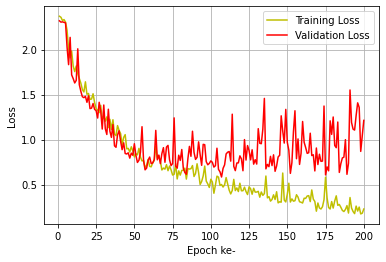

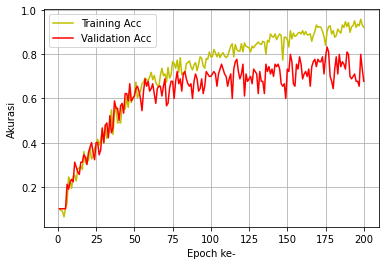

In [438]:
# Plot training and validation

loss13 = history13.history["loss"]
val_loss13 = history13.history["val_loss"]
epochs13 = range(1, len(loss13) + 1)
plt.plot(epochs13, loss13, "y", zorder=3, label="Training Loss")
plt.plot(epochs13, val_loss13, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc13 = history13.history["categorical_accuracy"]
val_acc13 = history13.history["val_categorical_accuracy"]
plt.plot(epochs13, acc13, "y", zorder=3, label="Training Acc")
plt.plot(epochs13, val_acc13, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Akurasi")
plt.legend()
plt.show()

In [439]:
res13 = va_lstm_sbu_1.predict(X_test)

In [440]:
yhat13 = va_lstm_sbu_1.predict(X_test)
ytrue13 = np.argmax(y_test, axis=1).tolist()
yhat13 = np.argmax(yhat13, axis=1).tolist()

Confusion matrix, without normalization
[[5 2 2 0 0 0 0 0 0 0]
 [3 6 0 0 0 0 0 0 0 0]
 [3 3 3 0 0 0 0 0 0 0]
 [0 0 0 9 0 0 0 0 0 0]
 [0 0 1 0 8 0 0 0 0 0]
 [0 0 0 0 0 7 2 0 0 0]
 [0 0 0 0 0 2 7 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 1 0 0 0 0 0 1 7 0]
 [0 0 0 0 0 1 0 0 0 8]]


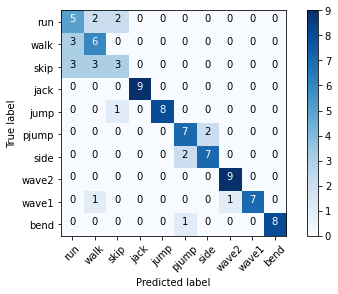

In [441]:
cm13 = confusion_matrix(y_true = ytrue13, y_pred = yhat13)
cm_plot_labels13 = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm13, classes = cm_plot_labels13, title = "")

In [442]:
fp13 = cm13.sum(axis=0) - np.diag(cm13)  
fn13 = cm13.sum(axis=1) - np.diag(cm13)
tp13 = np.diag(cm13)
tn13 = cm13.sum() - (fp13 + fn13 + tp13)

print(tp13)
print(fp13)
print(tn13)
print(fn13)

[5 6 3 9 8 7 7 9 7 8]
[6 6 3 0 0 3 2 1 0 0]
[75 75 78 81 81 78 79 80 81 81]
[4 3 6 0 1 2 2 0 2 1]


In [443]:
y_pred13 = va_lstm_sbu_1.predict(X_test)
y_pred13 = (y_pred13 > 0.5)

In [450]:
_, acc13 = va_lstm_sbu_1.evaluate(X_test, y_test)
print("Accuracy = ", (acc13*100), " %")

3/3 [==============================] - 0s 21ms/step - loss: 0.7400 - categorical_accuracy: 0.7667
Accuracy =  76.66666507720947  %


In [445]:
loss13_2, acc13_2 = va_lstm_sbu_1.evaluate(X_train, y_train)
loss13_3, acc13_3 = va_lstm_sbu_1.evaluate(X_valid, y_valid)

print("Accuracy2 = ", (acc13_2*100), " %")
print("Accuracy3 = ", (acc13_3*100), " %")

3/3 [==============================] - 0s 23ms/step - loss: 0.6970 - categorical_accuracy: 0.8333
Accuracy2 =  95.18518447875977  %
Accuracy3 =  83.33333134651184  %


In [446]:
accuracy_score(ytrue13, yhat13)

0.7666666666666667

In [447]:
acc13 = accuracy_score(ytrue13, yhat13)
acc13

0.7666666666666667

In [448]:
# Error rate
error_rate13 = 1 - acc13
error_rate13

0.23333333333333328

In [449]:
print(classification_report(
      ytrue13,
      yhat13,
      output_dict=False,
      target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.45      0.56      0.50         9
        walk       0.50      0.67      0.57         9
        skip       0.50      0.33      0.40         9
        jack       1.00      1.00      1.00         9
        jump       1.00      0.89      0.94         9
       pjump       0.70      0.78      0.74         9
        side       0.78      0.78      0.78         9
       wave2       0.90      1.00      0.95         9
       wave1       1.00      0.78      0.88         9
        bend       1.00      0.89      0.94         9

    accuracy                           0.77        90
   macro avg       0.78      0.77      0.77        90
weighted avg       0.78      0.77      0.77        90



# va_lstm_sbu_2
LSTM3=50 + dropout3=0,5 + Adam + lr=0,005 + GradientClip- clipnorm=1.0 + w/o TimeDistributed(dense=10) + batchsize=8 + epochs = 200 + ModelCheckpoint -> train:5min 35s, test:81.11%

EarlyStopping & ReduceLROnPlateu are unused.
if TimeDistributed were used, the output shape would be (none, 25, 10)(3D) + return_sequence should be True 
#### Model VA-LSTM SBU 2nd (Chosen)

In [451]:
# Define a sequential model
va_lstm_sbu_2 = Sequential([
    LSTM(50, recurrent_activation="sigmoid", return_sequences=True, implementation=2, input_shape=(25,132)),
    Dropout(0.5),
    LSTM(50, recurrent_activation="sigmoid", return_sequences=True, implementation=2),
    Dropout(0.5),
    LSTM(50, recurrent_activation="sigmoid", return_sequences=False, implementation=2),
    Dropout(0.5),
    Dense(actions.shape[0], activation="softmax")
])

In [452]:
# Compile model with learning rate
va_lstm_sbu_2.compile(Adam(learning_rate=0.005, clipnorm=1.0),
                      loss="categorical_crossentropy",
                      metrics=["categorical_accuracy"])

In [453]:
# Model Checkpoint Callback - reconfig

checkpoint_filepath14 = os.path.join("tmp/mc_va_lstm_sbu_2_e{epoch:04d}_val{val_categorical_accuracy:.3f}.h5")

mc_val_acc = ModelCheckpoint(filepath = checkpoint_filepath14,
                             monitor="val_categorical_accuracy",
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode="max",
                             save_freq="epoch")

In [454]:
%%time
# Training model with validation
history14 = va_lstm_sbu_2.fit(X_train, y_train, batch_size=8, epochs=200, verbose=2,
                             validation_data=(X_valid, y_valid), callbacks=[mc_val_acc])

Epoch 1/200

Epoch 00001: val_categorical_accuracy improved from -inf to 0.10000, saving model to tmp\mc_va_lstm_sbu_2_e0001_val0.100.h5
34/34 - 28s - loss: 2.3933 - categorical_accuracy: 0.0926 - val_loss: 2.3059 - val_categorical_accuracy: 0.1000 - 28s/epoch - 819ms/step
Epoch 2/200

Epoch 00002: val_categorical_accuracy improved from 0.10000 to 0.15556, saving model to tmp\mc_va_lstm_sbu_2_e0002_val0.156.h5
34/34 - 2s - loss: 2.3412 - categorical_accuracy: 0.0963 - val_loss: 2.2859 - val_categorical_accuracy: 0.1556 - 2s/epoch - 47ms/step
Epoch 3/200

Epoch 00003: val_categorical_accuracy did not improve from 0.15556
34/34 - 2s - loss: 2.2048 - categorical_accuracy: 0.1259 - val_loss: 2.7072 - val_categorical_accuracy: 0.1000 - 2s/epoch - 44ms/step
Epoch 4/200

Epoch 00004: val_categorical_accuracy improved from 0.15556 to 0.17778, saving model to tmp\mc_va_lstm_sbu_2_e0004_val0.178.h5
34/34 - 2s - loss: 2.2250 - categorical_accuracy: 0.1519 - val_loss: 1.9263 - val_categorical_accu

Epoch 36/200

Epoch 00036: val_categorical_accuracy did not improve from 0.56667
34/34 - 2s - loss: 0.9975 - categorical_accuracy: 0.5704 - val_loss: 1.2362 - val_categorical_accuracy: 0.5444 - 2s/epoch - 45ms/step
Epoch 37/200

Epoch 00037: val_categorical_accuracy improved from 0.56667 to 0.61111, saving model to tmp\mc_va_lstm_sbu_2_e0037_val0.611.h5
34/34 - 2s - loss: 1.0266 - categorical_accuracy: 0.5852 - val_loss: 0.8952 - val_categorical_accuracy: 0.6111 - 2s/epoch - 44ms/step
Epoch 38/200

Epoch 00038: val_categorical_accuracy did not improve from 0.61111
34/34 - 2s - loss: 0.9795 - categorical_accuracy: 0.5963 - val_loss: 0.9182 - val_categorical_accuracy: 0.6111 - 2s/epoch - 44ms/step
Epoch 39/200

Epoch 00039: val_categorical_accuracy did not improve from 0.61111
34/34 - 2s - loss: 1.0298 - categorical_accuracy: 0.5778 - val_loss: 1.1104 - val_categorical_accuracy: 0.5556 - 2s/epoch - 44ms/step
Epoch 40/200

Epoch 00040: val_categorical_accuracy did not improve from 0.61111

Epoch 73/200

Epoch 00073: val_categorical_accuracy did not improve from 0.77778
34/34 - 2s - loss: 0.7057 - categorical_accuracy: 0.7444 - val_loss: 0.8943 - val_categorical_accuracy: 0.7556 - 2s/epoch - 45ms/step
Epoch 74/200

Epoch 00074: val_categorical_accuracy did not improve from 0.77778
34/34 - 2s - loss: 0.6985 - categorical_accuracy: 0.7259 - val_loss: 0.8259 - val_categorical_accuracy: 0.7444 - 2s/epoch - 45ms/step
Epoch 75/200

Epoch 00075: val_categorical_accuracy did not improve from 0.77778
34/34 - 2s - loss: 0.7951 - categorical_accuracy: 0.6963 - val_loss: 0.7241 - val_categorical_accuracy: 0.6889 - 2s/epoch - 44ms/step
Epoch 76/200

Epoch 00076: val_categorical_accuracy did not improve from 0.77778
34/34 - 2s - loss: 0.6985 - categorical_accuracy: 0.7148 - val_loss: 0.6756 - val_categorical_accuracy: 0.7333 - 2s/epoch - 44ms/step
Epoch 77/200

Epoch 00077: val_categorical_accuracy did not improve from 0.77778
34/34 - 1s - loss: 0.6074 - categorical_accuracy: 0.7185 - 

Epoch 111/200

Epoch 00111: val_categorical_accuracy did not improve from 0.82222
34/34 - 2s - loss: 0.4675 - categorical_accuracy: 0.8148 - val_loss: 0.6082 - val_categorical_accuracy: 0.7778 - 2s/epoch - 45ms/step
Epoch 112/200

Epoch 00112: val_categorical_accuracy did not improve from 0.82222
34/34 - 2s - loss: 0.3984 - categorical_accuracy: 0.8222 - val_loss: 0.6159 - val_categorical_accuracy: 0.7556 - 2s/epoch - 44ms/step
Epoch 113/200

Epoch 00113: val_categorical_accuracy did not improve from 0.82222
34/34 - 1s - loss: 0.4789 - categorical_accuracy: 0.8407 - val_loss: 0.5589 - val_categorical_accuracy: 0.8222 - 1s/epoch - 44ms/step
Epoch 114/200

Epoch 00114: val_categorical_accuracy did not improve from 0.82222
34/34 - 2s - loss: 0.3848 - categorical_accuracy: 0.8370 - val_loss: 0.5937 - val_categorical_accuracy: 0.8111 - 2s/epoch - 45ms/step
Epoch 115/200

Epoch 00115: val_categorical_accuracy did not improve from 0.82222
34/34 - 2s - loss: 0.3978 - categorical_accuracy: 0.87

Epoch 149/200

Epoch 00149: val_categorical_accuracy did not improve from 0.82222
34/34 - 1s - loss: 0.3307 - categorical_accuracy: 0.8593 - val_loss: 0.6178 - val_categorical_accuracy: 0.7889 - 1s/epoch - 44ms/step
Epoch 150/200

Epoch 00150: val_categorical_accuracy did not improve from 0.82222
34/34 - 2s - loss: 0.3549 - categorical_accuracy: 0.8778 - val_loss: 0.6618 - val_categorical_accuracy: 0.8000 - 2s/epoch - 45ms/step
Epoch 151/200

Epoch 00151: val_categorical_accuracy did not improve from 0.82222
34/34 - 2s - loss: 0.3597 - categorical_accuracy: 0.8741 - val_loss: 0.6861 - val_categorical_accuracy: 0.7333 - 2s/epoch - 44ms/step
Epoch 152/200

Epoch 00152: val_categorical_accuracy did not improve from 0.82222
34/34 - 1s - loss: 0.3402 - categorical_accuracy: 0.8889 - val_loss: 0.5560 - val_categorical_accuracy: 0.7667 - 1s/epoch - 44ms/step
Epoch 153/200

Epoch 00153: val_categorical_accuracy did not improve from 0.82222
34/34 - 2s - loss: 0.2578 - categorical_accuracy: 0.90

Epoch 187/200

Epoch 00187: val_categorical_accuracy did not improve from 0.85556
34/34 - 2s - loss: 0.2838 - categorical_accuracy: 0.8926 - val_loss: 0.8134 - val_categorical_accuracy: 0.7889 - 2s/epoch - 54ms/step
Epoch 188/200

Epoch 00188: val_categorical_accuracy did not improve from 0.85556
34/34 - 2s - loss: 0.2563 - categorical_accuracy: 0.9185 - val_loss: 0.5885 - val_categorical_accuracy: 0.8333 - 2s/epoch - 53ms/step
Epoch 189/200

Epoch 00189: val_categorical_accuracy did not improve from 0.85556
34/34 - 2s - loss: 0.2418 - categorical_accuracy: 0.9037 - val_loss: 0.5882 - val_categorical_accuracy: 0.8222 - 2s/epoch - 55ms/step
Epoch 190/200

Epoch 00190: val_categorical_accuracy did not improve from 0.85556
34/34 - 2s - loss: 0.2640 - categorical_accuracy: 0.9074 - val_loss: 0.6054 - val_categorical_accuracy: 0.8111 - 2s/epoch - 54ms/step
Epoch 191/200

Epoch 00191: val_categorical_accuracy did not improve from 0.85556
34/34 - 2s - loss: 0.3586 - categorical_accuracy: 0.89

In [455]:
# Save history to json and csv

# convert the history12.history dict to a pandas DataFrame:     
hist_df_14 = pd.DataFrame(history14.history) 

# save to json:  
hist_json_file_14 = 'history/others/json/va_lstm_sbu_2.json' 
with open(hist_json_file_14, mode='w') as f:
    hist_df_14.to_json(f)

# or save to csv: 
hist_csv_file_14 = 'history/others/csv/va_lstm_sbu_2.csv'
with open(hist_csv_file_14, mode='w') as f:
    hist_df_14.to_csv(f)

In [302]:
va_lstm_sbu_2.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 25, 100)           93200     
                                                                 
 dropout_12 (Dropout)        (None, 25, 100)           0         
                                                                 
 lstm_31 (LSTM)              (None, 25, 100)           80400     
                                                                 
 dropout_13 (Dropout)        (None, 25, 100)           0         
                                                                 
 dense_28 (Dense)            (None, 25, 10)            1010      
                                                                 
Total params: 174,610
Trainable params: 174,610
Non-trainable params: 0
_________________________________________________________________


In [456]:
# Load Model
va_lstm_sbu_2.load_weights("tmp\mc_va_lstm_sbu_2_e0186_val0.856.h5")

In [755]:
# Save Model
va_lstm_sbu_2.save("model/others/va_lstm_sbu_2_e0186_val0.856.h5")

In [ ]:
# Visualize
plot_model(va_lstm_sbu_2, to_file = "arc_lstm2_dense2_rd_lr5_75_b2_default_mc_3_1840_23032022.png", show_shapes = True)

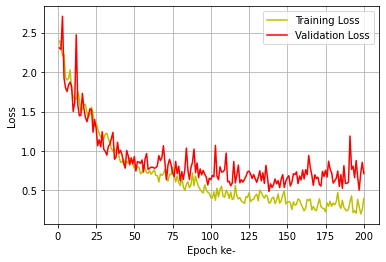

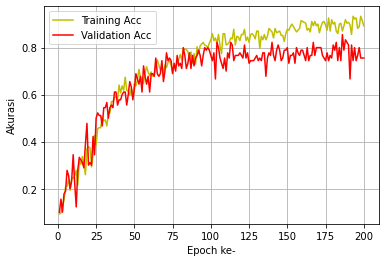

In [457]:
# Plot training and validation

loss14 = history14.history["loss"]
val_loss14 = history14.history["val_loss"]
epochs14 = range(1, len(loss14) + 1)
plt.plot(epochs14, loss14, "y", zorder=3, label="Training Loss")
plt.plot(epochs14, val_loss14, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc14 = history14.history["categorical_accuracy"]
val_acc14 = history14.history["val_categorical_accuracy"]
plt.plot(epochs14, acc14, "y", zorder=3, label="Training Acc")
plt.plot(epochs14, val_acc14, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Akurasi")
plt.legend()
plt.show()

In [39]:
df_14 = pd.read_csv("history/others/csv/va_lstm_sbu_2.csv")
df_14.head()

Unnamed: 0      loss  categorical_accuracy  val_loss  \
0           0  2.393323              0.092593  2.305898   
1           1  2.341195              0.096296  2.285939   
2           2  2.204768              0.125926  2.707191   
3           3  2.225024              0.151852  1.926265   
4           4  1.927374              0.207407  1.800825   

   val_categorical_accuracy  
0                  0.100000  
1                  0.155556  
2                  0.100000  
3                  0.177778  
4                  0.188889

In [40]:
df_14_processed = df_14.copy(deep=True)

df_14_processed["categorical_accuracy"] = df_14_processed["categorical_accuracy"]*100
df_14_processed["val_categorical_accuracy"] = df_14_processed["val_categorical_accuracy"]*100

df_14_processed

Unnamed: 0      loss  categorical_accuracy  val_loss  \
0             0  2.393323              9.259259  2.305898   
1             1  2.341195              9.629630  2.285939   
2             2  2.204768             12.592593  2.707191   
3             3  2.225024             15.185185  1.926265   
4             4  1.927374             20.740740  1.800825   
..          ...       ...                   ...       ...   
195         195  0.387134             88.148147  0.669803   
196         196  0.295483             88.888890  0.505318   
197         197  0.202280             93.333334  0.718086   
198         198  0.255240             91.481483  0.855577   
199         199  0.396485             89.259261  0.713720   

     val_categorical_accuracy  
0                   10.000000  
1                   15.555556  
2                   10.000000  
3                   17.777778  
4                   18.888889  
..                        ...  
195                 76.666665  
196                 80.000001  
197                 75.555557  
198                 75.555557  
199                 75.555557  

[200 rows x 5 columns]

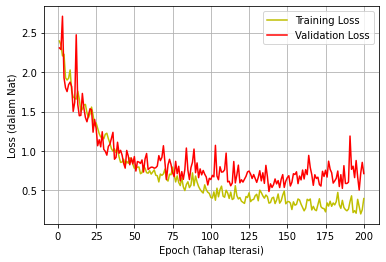

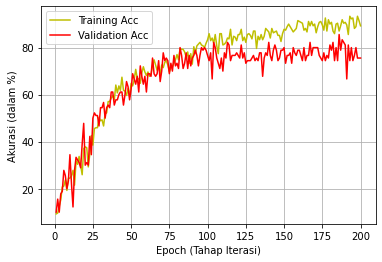

In [41]:
# Plot training and validation

loss14_2 = df_14_processed["loss"]
val_loss14_2 = df_14_processed["val_loss"]
epochs14_2 = range(1, len(loss14_2) + 1)
plt.plot(epochs14_2, loss14_2, "y", zorder=3, label="Training Loss")
plt.plot(epochs14_2, val_loss14_2, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch (Tahap Iterasi)")
plt.ylabel("Loss (dalam Nat)")
plt.legend()
plt.show()

acc14_2 = df_14_processed["categorical_accuracy"]
val_acc14_2 = df_14_processed["val_categorical_accuracy"]
plt.plot(epochs14_2, acc14_2, "y", zorder=3, label="Training Acc")
plt.plot(epochs14_2, val_acc14_2, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch (Tahap Iterasi)")
plt.ylabel("Akurasi (dalam %)")
plt.legend()
plt.show()

In [458]:
res14 = va_lstm_sbu_2.predict(X_test)

In [459]:
yhat14 = va_lstm_sbu_2.predict(X_test)
ytrue14 = np.argmax(y_test, axis=1).tolist()
yhat14 = np.argmax(yhat14, axis=1).tolist()

Confusion matrix, without normalization
[[3 4 2 0 0 0 0 0 0 0]
 [2 6 1 0 0 0 0 0 0 0]
 [2 4 3 0 0 0 0 0 0 0]
 [0 0 0 9 0 0 0 0 0 0]
 [0 0 1 0 8 0 0 0 0 0]
 [0 0 0 0 0 9 0 0 0 0]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 0 9 0]
 [0 0 0 0 0 1 0 0 0 8]]


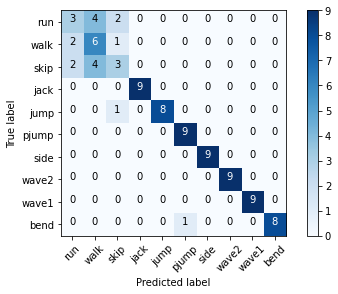

In [460]:
cm14 = confusion_matrix(y_true = ytrue14, y_pred = yhat14)
cm_plot_labels14 = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm14, classes = cm_plot_labels14, title = "")

In [461]:
fp14 = cm14.sum(axis=0) - np.diag(cm14)  
fn14 = cm14.sum(axis=1) - np.diag(cm14)
tp14 = np.diag(cm14)
tn14 = cm14.sum() - (fp14 + fn14 + tp14)

print(tp14)
print(fp14)
print(tn14)
print(fn14)

[3 6 3 9 8 9 9 9 9 8]
[4 8 4 0 0 1 0 0 0 0]
[77 73 77 81 81 80 81 81 81 81]
[6 3 6 0 1 0 0 0 0 1]


In [462]:
y_pred14 = va_lstm_sbu_2.predict(X_test)
y_pred14 = (y_pred14 > 0.5)

In [469]:
_, acc14 = va_lstm_sbu_2.evaluate(X_test, y_test)
print("Accuracy = ", (acc14*100), " %")

3/3 [==============================] - 0s 23ms/step - loss: 0.7039 - categorical_accuracy: 0.8111
Accuracy =  81.11110925674438  %


In [470]:
loss14_2, acc14_2 = va_lstm_sbu_2.evaluate(X_train, y_train)
loss14_3, acc14_3 = va_lstm_sbu_2.evaluate(X_valid, y_valid)

print("Accuracy2 = ", (acc14_2*100), " %")
print("Accuracy3 = ", (acc14_3*100), " %")

3/3 [==============================] - 0s 24ms/step - loss: 0.5259 - categorical_accuracy: 0.8556
Accuracy2 =  92.59259104728699  %
Accuracy3 =  85.5555534362793  %


In [465]:
accuracy_score(ytrue14, yhat14)

0.8111111111111111

In [466]:
acc14 = accuracy_score(ytrue14, yhat14)
acc14

0.8111111111111111

In [467]:
# Error rate
error_rate14 = 1 - acc14
error_rate14

0.18888888888888888

In [468]:
print(classification_report(
      ytrue14,
      yhat14,
      output_dict=False,
      target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.43      0.33      0.38         9
        walk       0.43      0.67      0.52         9
        skip       0.43      0.33      0.38         9
        jack       1.00      1.00      1.00         9
        jump       1.00      0.89      0.94         9
       pjump       0.90      1.00      0.95         9
        side       1.00      1.00      1.00         9
       wave2       1.00      1.00      1.00         9
       wave1       1.00      1.00      1.00         9
        bend       1.00      0.89      0.94         9

    accuracy                           0.81        90
   macro avg       0.82      0.81      0.81        90
weighted avg       0.82      0.81      0.81        90



# va_lstm_sbu_3
LSTM3=50 + dropout3=0,5 + Adam + lr=0,005 + GradientClip- clipnorm=1.0 + w/o TimeDistributed(dense=10) + batchsize=8 + epochs = 200 + ModelCheckpoint -> train:5min 8s, test:75.55%

EarlyStopping & ReduceLROnPlateu are unused.
if TimeDistributed were used, the output shape would be (none, 25, 10)(3D) + return_sequence should be True 
#### Model VA-LSTM SBU 3rd

In [471]:
# Define a sequential model
va_lstm_sbu_3 = Sequential([
    LSTM(50, recurrent_activation="sigmoid", return_sequences=True, implementation=2, input_shape=(25,132)),
    Dropout(0.5),
    LSTM(50, recurrent_activation="sigmoid", return_sequences=True, implementation=2),
    Dropout(0.5),
    LSTM(50, recurrent_activation="sigmoid", return_sequences=False, implementation=2),
    Dropout(0.5),
    Dense(actions.shape[0], activation="softmax")
])

In [472]:
# Compile model with learning rate
va_lstm_sbu_3.compile(Adam(learning_rate=0.005, clipnorm=1.0),
                      loss="categorical_crossentropy",
                      metrics=["categorical_accuracy"])

In [473]:
# Model Checkpoint Callback - reconfig

checkpoint_filepath15 = os.path.join("tmp/mc_va_lstm_sbu_3_e{epoch:04d}_val{val_categorical_accuracy:.3f}.h5")

mc_val_acc = ModelCheckpoint(filepath = checkpoint_filepath15,
                             monitor="val_categorical_accuracy",
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode="max",
                             save_freq="epoch")

In [474]:
%%time
# Training model with validation
history15 = va_lstm_sbu_3.fit(X_train, y_train, batch_size=8, epochs=200, verbose=2,
                             validation_data=(X_valid, y_valid), callbacks=[mc_val_acc])

Epoch 1/200

Epoch 00001: val_categorical_accuracy improved from -inf to 0.10000, saving model to tmp\mc_va_lstm_sbu_3_e0001_val0.100.h5
34/34 - 11s - loss: 2.4013 - categorical_accuracy: 0.0963 - val_loss: 2.3138 - val_categorical_accuracy: 0.1000 - 11s/epoch - 338ms/step
Epoch 2/200

Epoch 00002: val_categorical_accuracy did not improve from 0.10000
34/34 - 2s - loss: 2.3386 - categorical_accuracy: 0.1259 - val_loss: 2.3117 - val_categorical_accuracy: 0.1000 - 2s/epoch - 48ms/step
Epoch 3/200

Epoch 00003: val_categorical_accuracy did not improve from 0.10000
34/34 - 1s - loss: 2.3507 - categorical_accuracy: 0.1037 - val_loss: 2.2960 - val_categorical_accuracy: 0.1000 - 1s/epoch - 42ms/step
Epoch 4/200

Epoch 00004: val_categorical_accuracy improved from 0.10000 to 0.20000, saving model to tmp\mc_va_lstm_sbu_3_e0004_val0.200.h5
34/34 - 1s - loss: 2.2719 - categorical_accuracy: 0.1370 - val_loss: 1.9966 - val_categorical_accuracy: 0.2000 - 1s/epoch - 44ms/step
Epoch 5/200

Epoch 00005

Epoch 36/200

Epoch 00036: val_categorical_accuracy did not improve from 0.60000
34/34 - 1s - loss: 0.8579 - categorical_accuracy: 0.6444 - val_loss: 1.1837 - val_categorical_accuracy: 0.4778 - 1s/epoch - 43ms/step
Epoch 37/200

Epoch 00037: val_categorical_accuracy did not improve from 0.60000
34/34 - 1s - loss: 1.0486 - categorical_accuracy: 0.5444 - val_loss: 0.8780 - val_categorical_accuracy: 0.6000 - 1s/epoch - 43ms/step
Epoch 38/200

Epoch 00038: val_categorical_accuracy did not improve from 0.60000
34/34 - 1s - loss: 0.8659 - categorical_accuracy: 0.6222 - val_loss: 0.9702 - val_categorical_accuracy: 0.6000 - 1s/epoch - 43ms/step
Epoch 39/200

Epoch 00039: val_categorical_accuracy improved from 0.60000 to 0.61111, saving model to tmp\mc_va_lstm_sbu_3_e0039_val0.611.h5
34/34 - 1s - loss: 0.8538 - categorical_accuracy: 0.6481 - val_loss: 0.8558 - val_categorical_accuracy: 0.6111 - 1s/epoch - 43ms/step
Epoch 40/200

Epoch 00040: val_categorical_accuracy improved from 0.61111 to 0.6

Epoch 73/200

Epoch 00073: val_categorical_accuracy did not improve from 0.71111
34/34 - 1s - loss: 0.5635 - categorical_accuracy: 0.7778 - val_loss: 0.8643 - val_categorical_accuracy: 0.6556 - 1s/epoch - 42ms/step
Epoch 74/200

Epoch 00074: val_categorical_accuracy did not improve from 0.71111
34/34 - 1s - loss: 0.6711 - categorical_accuracy: 0.7481 - val_loss: 0.8012 - val_categorical_accuracy: 0.7111 - 1s/epoch - 43ms/step
Epoch 75/200

Epoch 00075: val_categorical_accuracy improved from 0.71111 to 0.73333, saving model to tmp\mc_va_lstm_sbu_3_e0075_val0.733.h5
34/34 - 1s - loss: 0.5490 - categorical_accuracy: 0.7852 - val_loss: 0.7121 - val_categorical_accuracy: 0.7333 - 1s/epoch - 44ms/step
Epoch 76/200

Epoch 00076: val_categorical_accuracy did not improve from 0.73333
34/34 - 1s - loss: 0.5571 - categorical_accuracy: 0.7667 - val_loss: 0.7819 - val_categorical_accuracy: 0.7222 - 1s/epoch - 43ms/step
Epoch 77/200

Epoch 00077: val_categorical_accuracy improved from 0.73333 to 0.7

Epoch 111/200

Epoch 00111: val_categorical_accuracy did not improve from 0.77778
34/34 - 1s - loss: 0.5480 - categorical_accuracy: 0.8222 - val_loss: 0.7547 - val_categorical_accuracy: 0.7333 - 1s/epoch - 44ms/step
Epoch 112/200

Epoch 00112: val_categorical_accuracy did not improve from 0.77778
34/34 - 1s - loss: 0.4143 - categorical_accuracy: 0.8630 - val_loss: 0.8020 - val_categorical_accuracy: 0.7000 - 1s/epoch - 43ms/step
Epoch 113/200

Epoch 00113: val_categorical_accuracy did not improve from 0.77778
34/34 - 1s - loss: 0.3776 - categorical_accuracy: 0.8667 - val_loss: 0.6726 - val_categorical_accuracy: 0.6889 - 1s/epoch - 42ms/step
Epoch 114/200

Epoch 00114: val_categorical_accuracy did not improve from 0.77778
34/34 - 1s - loss: 0.3950 - categorical_accuracy: 0.8667 - val_loss: 0.8429 - val_categorical_accuracy: 0.7333 - 1s/epoch - 44ms/step
Epoch 115/200

Epoch 00115: val_categorical_accuracy did not improve from 0.77778
34/34 - 1s - loss: 0.4245 - categorical_accuracy: 0.86

Epoch 148/200

Epoch 00148: val_categorical_accuracy did not improve from 0.83333
34/34 - 1s - loss: 0.2439 - categorical_accuracy: 0.9259 - val_loss: 0.6061 - val_categorical_accuracy: 0.8111 - 1s/epoch - 44ms/step
Epoch 149/200

Epoch 00149: val_categorical_accuracy did not improve from 0.83333
34/34 - 1s - loss: 0.2406 - categorical_accuracy: 0.9185 - val_loss: 0.7325 - val_categorical_accuracy: 0.8000 - 1s/epoch - 42ms/step
Epoch 150/200

Epoch 00150: val_categorical_accuracy did not improve from 0.83333
34/34 - 1s - loss: 0.2957 - categorical_accuracy: 0.8889 - val_loss: 0.7992 - val_categorical_accuracy: 0.7889 - 1s/epoch - 43ms/step
Epoch 151/200

Epoch 00151: val_categorical_accuracy did not improve from 0.83333
34/34 - 1s - loss: 0.4224 - categorical_accuracy: 0.8519 - val_loss: 0.6188 - val_categorical_accuracy: 0.8000 - 1s/epoch - 43ms/step
Epoch 152/200

Epoch 00152: val_categorical_accuracy did not improve from 0.83333
34/34 - 1s - loss: 0.2628 - categorical_accuracy: 0.91

Epoch 186/200

Epoch 00186: val_categorical_accuracy did not improve from 0.86667
34/34 - 1s - loss: 0.2050 - categorical_accuracy: 0.9259 - val_loss: 0.7809 - val_categorical_accuracy: 0.8111 - 1s/epoch - 43ms/step
Epoch 187/200

Epoch 00187: val_categorical_accuracy did not improve from 0.86667
34/34 - 1s - loss: 0.2217 - categorical_accuracy: 0.9259 - val_loss: 0.8127 - val_categorical_accuracy: 0.8333 - 1s/epoch - 43ms/step
Epoch 188/200

Epoch 00188: val_categorical_accuracy did not improve from 0.86667
34/34 - 1s - loss: 0.2345 - categorical_accuracy: 0.9222 - val_loss: 0.8516 - val_categorical_accuracy: 0.8111 - 1s/epoch - 44ms/step
Epoch 189/200

Epoch 00189: val_categorical_accuracy did not improve from 0.86667
34/34 - 1s - loss: 0.2131 - categorical_accuracy: 0.9222 - val_loss: 0.8044 - val_categorical_accuracy: 0.8222 - 1s/epoch - 43ms/step
Epoch 190/200

Epoch 00190: val_categorical_accuracy did not improve from 0.86667
34/34 - 1s - loss: 0.2585 - categorical_accuracy: 0.91

In [475]:
# Save history to json and csv

# convert the history12.history dict to a pandas DataFrame:     
hist_df_15 = pd.DataFrame(history15.history) 

# save to json:  
hist_json_file_15 = 'history/others/json/va_lstm_sbu_3.json' 
with open(hist_json_file_15, mode='w') as f:
    hist_df_15.to_json(f)

# or save to csv: 
hist_csv_file_15 = 'history/others/csv/va_lstm_sbu_3.csv'
with open(hist_csv_file_15, mode='w') as f:
    hist_df_15.to_csv(f)

In [302]:
va_lstm_sbu_3.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 25, 100)           93200     
                                                                 
 dropout_12 (Dropout)        (None, 25, 100)           0         
                                                                 
 lstm_31 (LSTM)              (None, 25, 100)           80400     
                                                                 
 dropout_13 (Dropout)        (None, 25, 100)           0         
                                                                 
 dense_28 (Dense)            (None, 25, 10)            1010      
                                                                 
Total params: 174,610
Trainable params: 174,610
Non-trainable params: 0
_________________________________________________________________


In [456]:
# Load Model
va_lstm_sbu_3.load_weights("tmp\mc_va_lstm_sbu_3_e0160_val0.867.h5")

In [ ]:
# Save Model
va_lstm_sbu_3.save("model2\lstm2_dense2_rd_lr5_75_b2_default_mc_3_e0116_val0.833.h5")

In [ ]:
# Visualize
plot_model(va_lstm_sbu_3, to_file = "arc_lstm2_dense2_rd_lr5_75_b2_default_mc_3_1840_23032022.png", show_shapes = True)

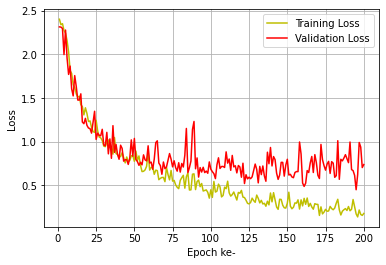

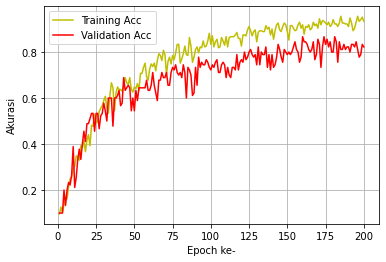

In [476]:
# Plot training and validation

loss15 = history15.history["loss"]
val_loss15 = history15.history["val_loss"]
epochs15 = range(1, len(loss15) + 1)
plt.plot(epochs15, loss15, "y", zorder=3, label="Training Loss")
plt.plot(epochs15, val_loss15, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc15 = history15.history["categorical_accuracy"]
val_acc15 = history15.history["val_categorical_accuracy"]
plt.plot(epochs15, acc15, "y", zorder=3, label="Training Acc")
plt.plot(epochs15, val_acc15, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Akurasi")
plt.legend()
plt.show()

In [477]:
res15 = va_lstm_sbu_3.predict(X_test)

In [478]:
yhat15 = va_lstm_sbu_3.predict(X_test)
ytrue15 = np.argmax(y_test, axis=1).tolist()
yhat15 = np.argmax(yhat15, axis=1).tolist()

Confusion matrix, without normalization
[[3 0 6 0 0 0 0 0 0 0]
 [2 7 0 0 0 0 0 0 0 0]
 [3 1 5 0 0 0 0 0 0 0]
 [0 0 0 9 0 0 0 0 0 0]
 [1 1 3 0 4 0 0 0 0 0]
 [0 0 0 0 0 8 1 0 0 0]
 [1 0 0 0 0 2 6 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 1 8 0]
 [0 0 0 0 0 0 0 0 0 9]]


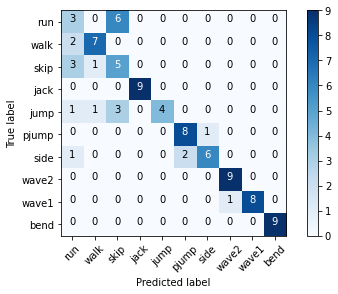

In [490]:
cm15 = confusion_matrix(y_true = ytrue15, y_pred = yhat15)
cm_plot_labels15 = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm15, classes = cm_plot_labels15, title = "")

In [491]:
fp15 = cm15.sum(axis=0) - np.diag(cm15)  
fn15 = cm15.sum(axis=1) - np.diag(cm15)
tp15 = np.diag(cm15)
tn15 = cm15.sum() - (fp15 + fn15 + tp15)

print(tp15)
print(fp15)
print(tn15)
print(fn15)

[3 7 5 9 4 8 6 9 8 9]
[7 2 9 0 0 2 1 1 0 0]
[74 79 72 81 81 79 80 80 81 81]
[6 2 4 0 5 1 3 0 1 0]


In [492]:
y_pred15 = va_lstm_sbu_3.predict(X_test)
y_pred15 = (y_pred15 > 0.5)

In [493]:
_, acc15 = va_lstm_sbu_3.evaluate(X_test, y_test)
print("Accuracy = ", (acc15*100), " %")

3/3 [==============================] - 0s 28ms/step - loss: 1.0342 - categorical_accuracy: 0.7556
Accuracy =  75.55555701255798  %


In [494]:
loss15_2, acc15_2 = va_lstm_sbu_3.evaluate(X_train, y_train)
loss15_3, acc15_3 = va_lstm_sbu_3.evaluate(X_valid, y_valid)

print("Accuracy2 = ", (acc15_2*100), " %")
print("Accuracy3 = ", (acc15_3*100), " %")

3/3 [==============================] - 0s 21ms/step - loss: 0.7387 - categorical_accuracy: 0.8222
Accuracy2 =  97.77777791023254  %
Accuracy3 =  82.22222328186035  %


In [495]:
accuracy_score(ytrue15, yhat15)

0.7555555555555555

In [496]:
acc15 = accuracy_score(ytrue15, yhat15)
acc15

0.7555555555555555

In [497]:
# Error rate
error_rate15 = 1 - acc15
error_rate15

0.24444444444444446

In [498]:
print(classification_report(
      ytrue15,
      yhat15,
      output_dict=False,
      target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.30      0.33      0.32         9
        walk       0.78      0.78      0.78         9
        skip       0.36      0.56      0.43         9
        jack       1.00      1.00      1.00         9
        jump       1.00      0.44      0.62         9
       pjump       0.80      0.89      0.84         9
        side       0.86      0.67      0.75         9
       wave2       0.90      1.00      0.95         9
       wave1       1.00      0.89      0.94         9
        bend       1.00      1.00      1.00         9

    accuracy                           0.76        90
   macro avg       0.80      0.76      0.76        90
weighted avg       0.80      0.76      0.76        90



# lstm_pasl_1
lstm1=256 + lstm2=128 + dropout=0.2 + Adam + batchsize=32 
train:6min 54s, test:76.66%

addition:
lr=0.0001 + ModelCheckpoint + epochs = 200

Proposal of a Real-time American Sign Language Detector using MediaPipe and Recurrent Neural Network

#### LSTM PASL 1st

In [499]:
# Define a sequential model
lstm_pasl_1 = Sequential([
    LSTM(256, return_sequences=True, input_shape=(25,132)),
    Dropout(0.2),
    LSTM(128, return_sequences=False),
    Dropout(0.2),
    Flatten(),
    Dense(actions.shape[0], activation="softmax")
])

In [500]:
# Compile model with learning rate
lstm_pasl_1.compile(Adam(learning_rate=0.0001),
                      loss="categorical_crossentropy",
                      metrics=["categorical_accuracy"])

In [501]:
# Model Checkpoint Callback - reconfig

checkpoint_filepath16 = os.path.join("tmp/mc_lstm_pasl_1_e{epoch:04d}_val{val_categorical_accuracy:.3f}.h5")

mc_val_acc = ModelCheckpoint(filepath = checkpoint_filepath16,
                             monitor="val_categorical_accuracy",
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode="max",
                             save_freq="epoch")

In [502]:
%%time
# Training model with validation
history16 = lstm_pasl_1.fit(X_train, y_train, batch_size=32, epochs=200, verbose=2,
                             validation_data=(X_valid, y_valid), callbacks=[mc_val_acc])

Epoch 1/200

Epoch 00001: val_categorical_accuracy improved from -inf to 0.14444, saving model to tmp\mc_lstm_pasl_1_e0001_val0.144.h5
9/9 - 72s - loss: 2.3313 - categorical_accuracy: 0.0852 - val_loss: 2.2709 - val_categorical_accuracy: 0.1444 - 72s/epoch - 8s/step
Epoch 2/200

Epoch 00002: val_categorical_accuracy did not improve from 0.14444
9/9 - 2s - loss: 2.2622 - categorical_accuracy: 0.1185 - val_loss: 2.2270 - val_categorical_accuracy: 0.1333 - 2s/epoch - 220ms/step
Epoch 3/200

Epoch 00003: val_categorical_accuracy improved from 0.14444 to 0.26667, saving model to tmp\mc_lstm_pasl_1_e0003_val0.267.h5
9/9 - 2s - loss: 2.2068 - categorical_accuracy: 0.1852 - val_loss: 2.1656 - val_categorical_accuracy: 0.2667 - 2s/epoch - 205ms/step
Epoch 4/200

Epoch 00004: val_categorical_accuracy improved from 0.26667 to 0.27778, saving model to tmp\mc_lstm_pasl_1_e0004_val0.278.h5
9/9 - 2s - loss: 2.1258 - categorical_accuracy: 0.2407 - val_loss: 2.0750 - val_categorical_accuracy: 0.2778 - 

Epoch 36/200

Epoch 00036: val_categorical_accuracy did not improve from 0.74444
9/9 - 2s - loss: 0.3761 - categorical_accuracy: 0.8630 - val_loss: 0.6972 - val_categorical_accuracy: 0.7333 - 2s/epoch - 199ms/step
Epoch 37/200

Epoch 00037: val_categorical_accuracy did not improve from 0.74444
9/9 - 2s - loss: 0.3441 - categorical_accuracy: 0.8963 - val_loss: 0.6438 - val_categorical_accuracy: 0.7444 - 2s/epoch - 195ms/step
Epoch 38/200

Epoch 00038: val_categorical_accuracy did not improve from 0.74444
9/9 - 2s - loss: 0.3828 - categorical_accuracy: 0.8741 - val_loss: 0.6599 - val_categorical_accuracy: 0.7444 - 2s/epoch - 197ms/step
Epoch 39/200

Epoch 00039: val_categorical_accuracy did not improve from 0.74444
9/9 - 2s - loss: 0.2960 - categorical_accuracy: 0.9185 - val_loss: 0.6805 - val_categorical_accuracy: 0.7222 - 2s/epoch - 198ms/step
Epoch 40/200

Epoch 00040: val_categorical_accuracy did not improve from 0.74444
9/9 - 2s - loss: 0.3021 - categorical_accuracy: 0.9259 - val_lo

Epoch 74/200

Epoch 00074: val_categorical_accuracy did not improve from 0.78889
9/9 - 2s - loss: 0.1178 - categorical_accuracy: 0.9556 - val_loss: 0.6443 - val_categorical_accuracy: 0.7778 - 2s/epoch - 184ms/step
Epoch 75/200

Epoch 00075: val_categorical_accuracy did not improve from 0.78889
9/9 - 2s - loss: 0.1036 - categorical_accuracy: 0.9778 - val_loss: 0.6550 - val_categorical_accuracy: 0.7333 - 2s/epoch - 182ms/step
Epoch 76/200

Epoch 00076: val_categorical_accuracy did not improve from 0.78889
9/9 - 2s - loss: 0.1141 - categorical_accuracy: 0.9815 - val_loss: 0.7364 - val_categorical_accuracy: 0.7667 - 2s/epoch - 185ms/step
Epoch 77/200

Epoch 00077: val_categorical_accuracy did not improve from 0.78889
9/9 - 2s - loss: 0.1206 - categorical_accuracy: 0.9593 - val_loss: 0.6998 - val_categorical_accuracy: 0.7778 - 2s/epoch - 187ms/step
Epoch 78/200

Epoch 00078: val_categorical_accuracy did not improve from 0.78889
9/9 - 2s - loss: 0.1159 - categorical_accuracy: 0.9630 - val_lo

Epoch 112/200

Epoch 00112: val_categorical_accuracy did not improve from 0.81111
9/9 - 2s - loss: 0.1327 - categorical_accuracy: 0.9630 - val_loss: 0.7064 - val_categorical_accuracy: 0.7556 - 2s/epoch - 177ms/step
Epoch 113/200

Epoch 00113: val_categorical_accuracy did not improve from 0.81111
9/9 - 2s - loss: 0.0860 - categorical_accuracy: 0.9852 - val_loss: 0.5995 - val_categorical_accuracy: 0.7778 - 2s/epoch - 176ms/step
Epoch 114/200

Epoch 00114: val_categorical_accuracy did not improve from 0.81111
9/9 - 2s - loss: 0.0622 - categorical_accuracy: 0.9963 - val_loss: 0.6560 - val_categorical_accuracy: 0.8000 - 2s/epoch - 179ms/step
Epoch 115/200

Epoch 00115: val_categorical_accuracy did not improve from 0.81111
9/9 - 2s - loss: 0.0512 - categorical_accuracy: 0.9926 - val_loss: 0.6183 - val_categorical_accuracy: 0.8000 - 2s/epoch - 183ms/step
Epoch 116/200

Epoch 00116: val_categorical_accuracy did not improve from 0.81111
9/9 - 2s - loss: 0.0697 - categorical_accuracy: 0.9852 - v

Epoch 150/200

Epoch 00150: val_categorical_accuracy did not improve from 0.83333
9/9 - 2s - loss: 0.2091 - categorical_accuracy: 0.9333 - val_loss: 0.8894 - val_categorical_accuracy: 0.7556 - 2s/epoch - 180ms/step
Epoch 151/200

Epoch 00151: val_categorical_accuracy did not improve from 0.83333
9/9 - 2s - loss: 0.0908 - categorical_accuracy: 0.9593 - val_loss: 0.8033 - val_categorical_accuracy: 0.7444 - 2s/epoch - 177ms/step
Epoch 152/200

Epoch 00152: val_categorical_accuracy did not improve from 0.83333
9/9 - 2s - loss: 0.1243 - categorical_accuracy: 0.9667 - val_loss: 0.8595 - val_categorical_accuracy: 0.7444 - 2s/epoch - 178ms/step
Epoch 153/200

Epoch 00153: val_categorical_accuracy did not improve from 0.83333
9/9 - 2s - loss: 0.1117 - categorical_accuracy: 0.9741 - val_loss: 0.8277 - val_categorical_accuracy: 0.7889 - 2s/epoch - 178ms/step
Epoch 154/200

Epoch 00154: val_categorical_accuracy did not improve from 0.83333
9/9 - 2s - loss: 0.1084 - categorical_accuracy: 0.9704 - v

Epoch 189/200

Epoch 00189: val_categorical_accuracy did not improve from 0.83333
9/9 - 2s - loss: 0.0107 - categorical_accuracy: 1.0000 - val_loss: 0.8015 - val_categorical_accuracy: 0.8000 - 2s/epoch - 178ms/step
Epoch 190/200

Epoch 00190: val_categorical_accuracy did not improve from 0.83333
9/9 - 2s - loss: 0.0101 - categorical_accuracy: 1.0000 - val_loss: 0.7709 - val_categorical_accuracy: 0.7889 - 2s/epoch - 184ms/step
Epoch 191/200

Epoch 00191: val_categorical_accuracy did not improve from 0.83333
9/9 - 2s - loss: 0.0100 - categorical_accuracy: 1.0000 - val_loss: 0.7442 - val_categorical_accuracy: 0.8000 - 2s/epoch - 177ms/step
Epoch 192/200

Epoch 00192: val_categorical_accuracy did not improve from 0.83333
9/9 - 2s - loss: 0.0104 - categorical_accuracy: 1.0000 - val_loss: 0.7926 - val_categorical_accuracy: 0.8000 - 2s/epoch - 178ms/step
Epoch 193/200

Epoch 00193: val_categorical_accuracy did not improve from 0.83333
9/9 - 2s - loss: 0.0107 - categorical_accuracy: 1.0000 - v

In [503]:
# Save history to json and csv

# convert the history12.history dict to a pandas DataFrame:     
hist_df_16 = pd.DataFrame(history16.history) 

# save to json:  
hist_json_file_16 = 'history/others/json/lstm_pasl_1.json' 
with open(hist_json_file_16, mode='w') as f:
    hist_df_16.to_json(f)

# or save to csv: 
hist_csv_file_16 = 'history/others/csv/lstm_pasl_1.csv'
with open(hist_csv_file_16, mode='w') as f:
    hist_df_16.to_csv(f)

In [302]:
lstm_pasl_1.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 25, 100)           93200     
                                                                 
 dropout_12 (Dropout)        (None, 25, 100)           0         
                                                                 
 lstm_31 (LSTM)              (None, 25, 100)           80400     
                                                                 
 dropout_13 (Dropout)        (None, 25, 100)           0         
                                                                 
 dense_28 (Dense)            (None, 25, 10)            1010      
                                                                 
Total params: 174,610
Trainable params: 174,610
Non-trainable params: 0
_________________________________________________________________


In [504]:
# Load Model
lstm_pasl_1.load_weights("tmp\mc_lstm_pasl_1_e0145_val0.833.h5")

In [ ]:
# Save Model
lstm_pasl_1.save("model2\lstm2_dense2_rd_lr5_75_b2_default_mc_3_e0116_val0.833.h5")

In [ ]:
# Visualize
plot_model(lstm_pasl_1, to_file = "arc_lstm2_dense2_rd_lr5_75_b2_default_mc_3_1840_23032022.png", show_shapes = True)

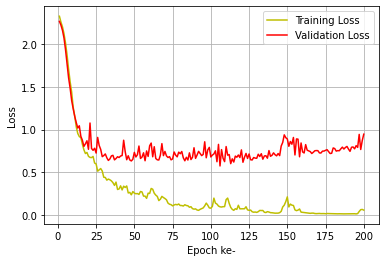

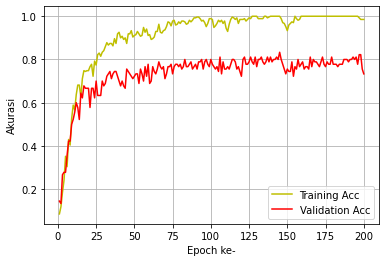

In [505]:
# Plot training and validation

loss16 = history16.history["loss"]
val_loss16 = history16.history["val_loss"]
epochs16 = range(1, len(loss16) + 1)
plt.plot(epochs16, loss16, "y", zorder=3, label="Training Loss")
plt.plot(epochs16, val_loss16, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc16 = history16.history["categorical_accuracy"]
val_acc16 = history16.history["val_categorical_accuracy"]
plt.plot(epochs16, acc16, "y", zorder=3, label="Training Acc")
plt.plot(epochs16, val_acc16, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Akurasi")
plt.legend()
plt.show()

In [506]:
res16 = lstm_pasl_1.predict(X_test)

In [507]:
yhat16 = lstm_pasl_1.predict(X_test)
ytrue16 = np.argmax(y_test, axis=1).tolist()
yhat16 = np.argmax(yhat16, axis=1).tolist()

Confusion matrix, without normalization
[[5 2 2 0 0 0 0 0 0 0]
 [2 5 0 0 1 0 1 0 0 0]
 [3 1 5 0 0 0 0 0 0 0]
 [0 0 0 7 0 1 0 0 1 0]
 [1 0 1 0 7 0 0 0 0 0]
 [0 0 0 0 0 8 1 0 0 0]
 [0 1 0 0 0 0 8 0 0 0]
 [0 0 0 1 0 0 0 8 0 0]
 [0 0 0 2 0 0 0 0 7 0]
 [0 0 0 0 0 0 0 0 0 9]]


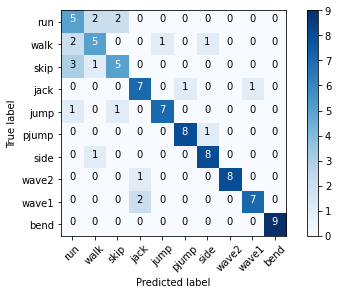

In [508]:
cm16 = confusion_matrix(y_true = ytrue16, y_pred = yhat16)
cm_plot_labels16 = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm16, classes = cm_plot_labels16, title = "")

In [509]:
fp16 = cm16.sum(axis=0) - np.diag(cm16)  
fn16 = cm16.sum(axis=1) - np.diag(cm16)
tp16 = np.diag(cm16)
tn16 = cm16.sum() - (fp16 + fn16 + tp16)

print(tp16)
print(fp16)
print(tn16)
print(fn16)

[5 5 5 7 7 8 8 8 7 9]
[6 4 3 3 1 1 2 0 1 0]
[75 77 78 78 80 80 79 81 80 81]
[4 4 4 2 2 1 1 1 2 0]


In [510]:
y_pred16 = lstm_pasl_1.predict(X_test)
y_pred16 = (y_pred16 > 0.5)

In [511]:
_, acc16 = lstm_pasl_1.evaluate(X_test, y_test)
print("Accuracy = ", (acc16*100), " %")

3/3 [==============================] - 0s 65ms/step - loss: 0.8444 - categorical_accuracy: 0.7667
Accuracy =  76.66666507720947  %


In [512]:
loss16_2, acc16_2 = lstm_pasl_1.evaluate(X_train, y_train)
loss16_3, acc16_3 = lstm_pasl_1.evaluate(X_valid, y_valid)

print("Accuracy2 = ", (acc16_2*100), " %")
print("Accuracy3 = ", (acc16_3*100), " %")

3/3 [==============================] - 0s 67ms/step - loss: 0.6938 - categorical_accuracy: 0.8333
Accuracy2 =  100.0  %
Accuracy3 =  83.33333134651184  %


In [513]:
accuracy_score(ytrue16, yhat16)

0.7666666666666667

In [514]:
acc16 = accuracy_score(ytrue16, yhat16)
acc16

0.7666666666666667

In [515]:
# Error rate
error_rate16 = 1 - acc16
error_rate16

0.23333333333333328

In [516]:
print(classification_report(
      ytrue16,
      yhat16,
      output_dict=False,
      target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.45      0.56      0.50         9
        walk       0.56      0.56      0.56         9
        skip       0.62      0.56      0.59         9
        jack       0.70      0.78      0.74         9
        jump       0.88      0.78      0.82         9
       pjump       0.89      0.89      0.89         9
        side       0.80      0.89      0.84         9
       wave2       1.00      0.89      0.94         9
       wave1       0.88      0.78      0.82         9
        bend       1.00      1.00      1.00         9

    accuracy                           0.77        90
   macro avg       0.78      0.77      0.77        90
weighted avg       0.78      0.77      0.77        90



# lstm_pasl_2
lstm1=256 + lstm2=128 + dropout=0.2 + Adam + batchsize=32 

train:5min 43s, test:73.33%

addition:
lr=0.0001 + ModelCheckpoint + epochs = 200

Proposal of a Real-time American Sign Language Detector using MediaPipe and Recurrent Neural Network

#### LSTM PASL 2nd

In [517]:
# Define a sequential model
lstm_pasl_2 = Sequential([
    LSTM(256, return_sequences=True, input_shape=(25,132)),
    Dropout(0.2),
    LSTM(128, return_sequences=False),
    Dropout(0.2),
    Flatten(),
    Dense(actions.shape[0], activation="softmax")
])

In [518]:
# Compile model with learning rate
lstm_pasl_2.compile(Adam(learning_rate=0.0001),
                      loss="categorical_crossentropy",
                      metrics=["categorical_accuracy"])

In [519]:
# Model Checkpoint Callback - reconfig

checkpoint_filepath17 = os.path.join("tmp/mc_lstm_pasl_2_e{epoch:04d}_val{val_categorical_accuracy:.3f}.h5")

mc_val_acc = ModelCheckpoint(filepath = checkpoint_filepath17,
                             monitor="val_categorical_accuracy",
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode="max",
                             save_freq="epoch")

In [520]:
%%time
# Training model with validation
history17 = lstm_pasl_2.fit(X_train, y_train, batch_size=32, epochs=200, verbose=2,
                             validation_data=(X_valid, y_valid), callbacks=[mc_val_acc])

Epoch 1/200

Epoch 00001: val_categorical_accuracy improved from -inf to 0.17778, saving model to tmp\mc_lstm_pasl_2_e0001_val0.178.h5
9/9 - 10s - loss: 2.3173 - categorical_accuracy: 0.1074 - val_loss: 2.2589 - val_categorical_accuracy: 0.1778 - 10s/epoch - 1s/step
Epoch 2/200

Epoch 00002: val_categorical_accuracy improved from 0.17778 to 0.22222, saving model to tmp\mc_lstm_pasl_2_e0002_val0.222.h5
9/9 - 2s - loss: 2.2346 - categorical_accuracy: 0.1741 - val_loss: 2.2146 - val_categorical_accuracy: 0.2222 - 2s/epoch - 192ms/step
Epoch 3/200

Epoch 00003: val_categorical_accuracy improved from 0.22222 to 0.32222, saving model to tmp\mc_lstm_pasl_2_e0003_val0.322.h5
9/9 - 2s - loss: 2.1916 - categorical_accuracy: 0.1852 - val_loss: 2.1592 - val_categorical_accuracy: 0.3222 - 2s/epoch - 213ms/step
Epoch 4/200

Epoch 00004: val_categorical_accuracy did not improve from 0.32222
9/9 - 2s - loss: 2.1133 - categorical_accuracy: 0.3296 - val_loss: 2.0676 - val_categorical_accuracy: 0.3222 - 

Epoch 36/200

Epoch 00036: val_categorical_accuracy did not improve from 0.72222
9/9 - 2s - loss: 0.3470 - categorical_accuracy: 0.8963 - val_loss: 0.6150 - val_categorical_accuracy: 0.7000 - 2s/epoch - 180ms/step
Epoch 37/200

Epoch 00037: val_categorical_accuracy did not improve from 0.72222
9/9 - 2s - loss: 0.3398 - categorical_accuracy: 0.8741 - val_loss: 0.6407 - val_categorical_accuracy: 0.7222 - 2s/epoch - 178ms/step
Epoch 38/200

Epoch 00038: val_categorical_accuracy did not improve from 0.72222
9/9 - 2s - loss: 0.3504 - categorical_accuracy: 0.8741 - val_loss: 0.6422 - val_categorical_accuracy: 0.7111 - 2s/epoch - 178ms/step
Epoch 39/200

Epoch 00039: val_categorical_accuracy did not improve from 0.72222
9/9 - 2s - loss: 0.3142 - categorical_accuracy: 0.9148 - val_loss: 0.6175 - val_categorical_accuracy: 0.7222 - 2s/epoch - 180ms/step
Epoch 40/200

Epoch 00040: val_categorical_accuracy did not improve from 0.72222
9/9 - 2s - loss: 0.3067 - categorical_accuracy: 0.8926 - val_lo

Epoch 74/200

Epoch 00074: val_categorical_accuracy did not improve from 0.77778
9/9 - 2s - loss: 0.1560 - categorical_accuracy: 0.9556 - val_loss: 0.7081 - val_categorical_accuracy: 0.7667 - 2s/epoch - 181ms/step
Epoch 75/200

Epoch 00075: val_categorical_accuracy did not improve from 0.77778
9/9 - 2s - loss: 0.1460 - categorical_accuracy: 0.9630 - val_loss: 0.6324 - val_categorical_accuracy: 0.7667 - 2s/epoch - 182ms/step
Epoch 76/200

Epoch 00076: val_categorical_accuracy did not improve from 0.77778
9/9 - 2s - loss: 0.1404 - categorical_accuracy: 0.9704 - val_loss: 0.6710 - val_categorical_accuracy: 0.7556 - 2s/epoch - 181ms/step
Epoch 77/200

Epoch 00077: val_categorical_accuracy did not improve from 0.77778
9/9 - 2s - loss: 0.1403 - categorical_accuracy: 0.9593 - val_loss: 0.6306 - val_categorical_accuracy: 0.7444 - 2s/epoch - 182ms/step
Epoch 78/200

Epoch 00078: val_categorical_accuracy did not improve from 0.77778
9/9 - 2s - loss: 0.1066 - categorical_accuracy: 0.9778 - val_lo

Epoch 112/200

Epoch 00112: val_categorical_accuracy did not improve from 0.80000
9/9 - 2s - loss: 0.0631 - categorical_accuracy: 0.9889 - val_loss: 0.6912 - val_categorical_accuracy: 0.7556 - 2s/epoch - 184ms/step
Epoch 113/200

Epoch 00113: val_categorical_accuracy did not improve from 0.80000
9/9 - 2s - loss: 0.0610 - categorical_accuracy: 0.9852 - val_loss: 0.7626 - val_categorical_accuracy: 0.7778 - 2s/epoch - 185ms/step
Epoch 114/200

Epoch 00114: val_categorical_accuracy did not improve from 0.80000
9/9 - 2s - loss: 0.0479 - categorical_accuracy: 0.9926 - val_loss: 0.7040 - val_categorical_accuracy: 0.7778 - 2s/epoch - 181ms/step
Epoch 115/200

Epoch 00115: val_categorical_accuracy did not improve from 0.80000
9/9 - 2s - loss: 0.0376 - categorical_accuracy: 0.9963 - val_loss: 0.7621 - val_categorical_accuracy: 0.7667 - 2s/epoch - 183ms/step
Epoch 116/200

Epoch 00116: val_categorical_accuracy did not improve from 0.80000
9/9 - 2s - loss: 0.0597 - categorical_accuracy: 0.9852 - v

Epoch 150/200

Epoch 00150: val_categorical_accuracy did not improve from 0.81111
9/9 - 2s - loss: 0.0159 - categorical_accuracy: 1.0000 - val_loss: 0.8096 - val_categorical_accuracy: 0.7778 - 2s/epoch - 188ms/step
Epoch 151/200

Epoch 00151: val_categorical_accuracy did not improve from 0.81111
9/9 - 2s - loss: 0.0174 - categorical_accuracy: 1.0000 - val_loss: 0.7953 - val_categorical_accuracy: 0.7667 - 2s/epoch - 182ms/step
Epoch 152/200

Epoch 00152: val_categorical_accuracy did not improve from 0.81111
9/9 - 2s - loss: 0.0145 - categorical_accuracy: 1.0000 - val_loss: 0.7755 - val_categorical_accuracy: 0.7556 - 2s/epoch - 180ms/step
Epoch 153/200

Epoch 00153: val_categorical_accuracy did not improve from 0.81111
9/9 - 2s - loss: 0.0162 - categorical_accuracy: 1.0000 - val_loss: 0.7941 - val_categorical_accuracy: 0.7667 - 2s/epoch - 180ms/step
Epoch 154/200

Epoch 00154: val_categorical_accuracy did not improve from 0.81111
9/9 - 2s - loss: 0.0206 - categorical_accuracy: 0.9963 - v

Epoch 189/200

Epoch 00189: val_categorical_accuracy did not improve from 0.81111
9/9 - 2s - loss: 0.0147 - categorical_accuracy: 1.0000 - val_loss: 0.8158 - val_categorical_accuracy: 0.7778 - 2s/epoch - 181ms/step
Epoch 190/200

Epoch 00190: val_categorical_accuracy did not improve from 0.81111
9/9 - 2s - loss: 0.0131 - categorical_accuracy: 1.0000 - val_loss: 0.8311 - val_categorical_accuracy: 0.7778 - 2s/epoch - 181ms/step
Epoch 191/200

Epoch 00191: val_categorical_accuracy did not improve from 0.81111
9/9 - 2s - loss: 0.0120 - categorical_accuracy: 1.0000 - val_loss: 0.8205 - val_categorical_accuracy: 0.7667 - 2s/epoch - 179ms/step
Epoch 192/200

Epoch 00192: val_categorical_accuracy did not improve from 0.81111
9/9 - 2s - loss: 0.0116 - categorical_accuracy: 1.0000 - val_loss: 0.8054 - val_categorical_accuracy: 0.7778 - 2s/epoch - 181ms/step
Epoch 193/200

Epoch 00193: val_categorical_accuracy did not improve from 0.81111
9/9 - 2s - loss: 0.0136 - categorical_accuracy: 1.0000 - v

In [521]:
# Save history to json and csv

# convert the history12.history dict to a pandas DataFrame:     
hist_df_17 = pd.DataFrame(history17.history) 

# save to json:  
hist_json_file_17 = 'history/others/json/lstm_pasl_2.json' 
with open(hist_json_file_17, mode='w') as f:
    hist_df_17.to_json(f)

# or save to csv: 
hist_csv_file_17 = 'history/others/csv/lstm_pasl_2.csv'
with open(hist_csv_file_17, mode='w') as f:
    hist_df_17.to_csv(f)

In [302]:
lstm_pasl_2.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 25, 100)           93200     
                                                                 
 dropout_12 (Dropout)        (None, 25, 100)           0         
                                                                 
 lstm_31 (LSTM)              (None, 25, 100)           80400     
                                                                 
 dropout_13 (Dropout)        (None, 25, 100)           0         
                                                                 
 dense_28 (Dense)            (None, 25, 10)            1010      
                                                                 
Total params: 174,610
Trainable params: 174,610
Non-trainable params: 0
_________________________________________________________________


In [522]:
# Load Model
lstm_pasl_2.load_weights("tmp\mc_lstm_pasl_2_e0135_val0.811.h5")

In [ ]:
# Save Model
lstm_pasl_2.save("model2\lstm2_dense2_rd_lr5_75_b2_default_mc_3_e0116_val0.833.h5")

In [ ]:
# Visualize
plot_model(lstm_pasl_2, to_file = "arc_lstm2_dense2_rd_lr5_75_b2_default_mc_3_1840_23032022.png", show_shapes = True)

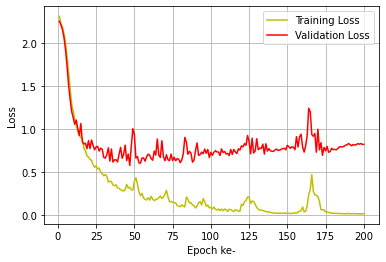

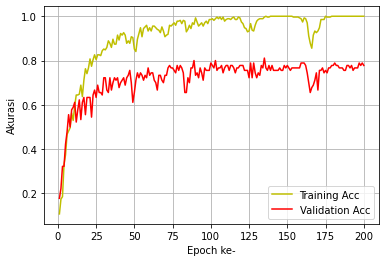

In [534]:
# Plot training and validation

loss17 = history17.history["loss"]
val_loss17 = history17.history["val_loss"]
epochs17 = range(1, len(loss17) + 1)
plt.plot(epochs17, loss17, "y", zorder=3, label="Training Loss")
plt.plot(epochs17, val_loss17, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc17 = history17.history["categorical_accuracy"]
val_acc17 = history17.history["val_categorical_accuracy"]
plt.plot(epochs17, acc17, "y", zorder=3, label="Training Acc")
plt.plot(epochs17, val_acc17, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Akurasi")
plt.legend()
plt.show()

In [524]:
res17 = lstm_pasl_2.predict(X_test)

In [525]:
yhat17 = lstm_pasl_2.predict(X_test)
ytrue17 = np.argmax(y_test, axis=1).tolist()
yhat17 = np.argmax(yhat17, axis=1).tolist()

Confusion matrix, without normalization
[[4 4 1 0 0 0 0 0 0 0]
 [2 5 0 0 1 0 1 0 0 0]
 [4 2 3 0 0 0 0 0 0 0]
 [0 0 0 7 0 1 0 0 1 0]
 [1 0 1 0 6 0 1 0 0 0]
 [0 0 0 0 0 8 1 0 0 0]
 [0 0 0 0 0 1 8 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 2 0 0 0 0 7 0]
 [0 0 0 0 0 0 0 0 0 9]]


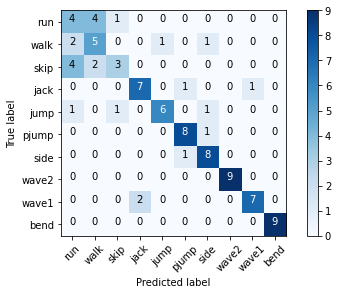

In [526]:
cm17 = confusion_matrix(y_true = ytrue17, y_pred = yhat17)
cm_plot_labels17 = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm17, classes = cm_plot_labels17, title = "")

In [527]:
fp17 = cm17.sum(axis=0) - np.diag(cm17)  
fn17 = cm17.sum(axis=1) - np.diag(cm17)
tp17 = np.diag(cm17)
tn17 = cm17.sum() - (fp17 + fn17 + tp17)

print(tp17)
print(fp17)
print(tn17)
print(fn17)

[4 5 3 7 6 8 8 9 7 9]
[7 6 2 2 1 2 3 0 1 0]
[74 75 79 79 80 79 78 81 80 81]
[5 4 6 2 3 1 1 0 2 0]


In [528]:
y_pred17 = lstm_pasl_2.predict(X_test)
y_pred17 = (y_pred17 > 0.5)

In [529]:
_, acc17 = lstm_pasl_2.evaluate(X_test, y_test)
print("Accuracy = ", (acc17*100), " %")

3/3 [==============================] - 0s 65ms/step - loss: 0.8440 - categorical_accuracy: 0.7333
Accuracy =  73.33333492279053  %


In [530]:
loss17_2, acc17_2 = lstm_pasl_2.evaluate(X_train, y_train)
loss17_3, acc17_3 = lstm_pasl_2.evaluate(X_valid, y_valid)

print("Accuracy2 = ", (acc17_2*100), " %")
print("Accuracy3 = ", (acc17_3*100), " %")

3/3 [==============================] - 0s 72ms/step - loss: 0.7083 - categorical_accuracy: 0.8111
Accuracy2 =  99.62962865829468  %
Accuracy3 =  81.11110925674438  %


In [531]:
acc17 = accuracy_score(ytrue17, yhat17)
acc17

0.7333333333333333

In [532]:
# Error rate
error_rate17 = 1 - acc17
error_rate17

0.2666666666666667

In [533]:
print(classification_report(
      ytrue17,
      yhat17,
      output_dict=False,
      target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.36      0.44      0.40         9
        walk       0.45      0.56      0.50         9
        skip       0.60      0.33      0.43         9
        jack       0.78      0.78      0.78         9
        jump       0.86      0.67      0.75         9
       pjump       0.80      0.89      0.84         9
        side       0.73      0.89      0.80         9
       wave2       1.00      1.00      1.00         9
       wave1       0.88      0.78      0.82         9
        bend       1.00      1.00      1.00         9

    accuracy                           0.73        90
   macro avg       0.75      0.73      0.73        90
weighted avg       0.75      0.73      0.73        90



## lstm_pasl_3
lstm1=256 + lstm2=128 + dropout2=0.2 + Adam + batchsize=32 

train:5min 52s, test:76.66%

addition:
lr=0.0001 + ModelCheckpoint + epochs = 200

Proposal of a Real-time American Sign Language Detector using MediaPipe and Recurrent Neural Network

#### LSTM PASL 3rd (Chosen)

In [535]:
# Define a sequential model
lstm_pasl_3 = Sequential([
    LSTM(256, return_sequences=True, input_shape=(25,132)),
    Dropout(0.2),
    LSTM(128, return_sequences=False),
    Dropout(0.2),
    Flatten(),
    Dense(actions.shape[0], activation="softmax")
])

In [536]:
# Compile model with learning rate
lstm_pasl_3.compile(Adam(learning_rate=0.0001),
                      loss="categorical_crossentropy",
                      metrics=["categorical_accuracy"])

In [537]:
# Model Checkpoint Callback - reconfig

checkpoint_filepath18 = os.path.join("tmp/mc_lstm_pasl_3_e{epoch:04d}_val{val_categorical_accuracy:.3f}.h5")

mc_val_acc = ModelCheckpoint(filepath = checkpoint_filepath18,
                             monitor="val_categorical_accuracy",
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode="max",
                             save_freq="epoch")

In [538]:
%%time
# Training model with validation
history18 = lstm_pasl_3.fit(X_train, y_train, batch_size=32, epochs=200, verbose=2,
                             validation_data=(X_valid, y_valid), callbacks=[mc_val_acc])

Epoch 1/200

Epoch 00001: val_categorical_accuracy improved from -inf to 0.23333, saving model to tmp\mc_lstm_pasl_3_e0001_val0.233.h5
9/9 - 11s - loss: 2.3229 - categorical_accuracy: 0.0815 - val_loss: 2.2530 - val_categorical_accuracy: 0.2333 - 11s/epoch - 1s/step
Epoch 2/200

Epoch 00002: val_categorical_accuracy did not improve from 0.23333
9/9 - 2s - loss: 2.2457 - categorical_accuracy: 0.1593 - val_loss: 2.2129 - val_categorical_accuracy: 0.2111 - 2s/epoch - 200ms/step
Epoch 3/200

Epoch 00003: val_categorical_accuracy improved from 0.23333 to 0.38889, saving model to tmp\mc_lstm_pasl_3_e0003_val0.389.h5
9/9 - 2s - loss: 2.2037 - categorical_accuracy: 0.2037 - val_loss: 2.1453 - val_categorical_accuracy: 0.3889 - 2s/epoch - 198ms/step
Epoch 4/200

Epoch 00004: val_categorical_accuracy did not improve from 0.38889
9/9 - 2s - loss: 2.1184 - categorical_accuracy: 0.3259 - val_loss: 2.0472 - val_categorical_accuracy: 0.3667 - 2s/epoch - 197ms/step
Epoch 5/200

Epoch 00005: val_catego

Epoch 37/200

Epoch 00037: val_categorical_accuracy did not improve from 0.74444
9/9 - 2s - loss: 0.4037 - categorical_accuracy: 0.8556 - val_loss: 0.6763 - val_categorical_accuracy: 0.7444 - 2s/epoch - 185ms/step
Epoch 38/200

Epoch 00038: val_categorical_accuracy improved from 0.74444 to 0.75556, saving model to tmp\mc_lstm_pasl_3_e0038_val0.756.h5
9/9 - 2s - loss: 0.3891 - categorical_accuracy: 0.8741 - val_loss: 0.7585 - val_categorical_accuracy: 0.7556 - 2s/epoch - 191ms/step
Epoch 39/200

Epoch 00039: val_categorical_accuracy did not improve from 0.75556
9/9 - 2s - loss: 0.3742 - categorical_accuracy: 0.8852 - val_loss: 0.6069 - val_categorical_accuracy: 0.7444 - 2s/epoch - 188ms/step
Epoch 40/200

Epoch 00040: val_categorical_accuracy did not improve from 0.75556
9/9 - 2s - loss: 0.3673 - categorical_accuracy: 0.8889 - val_loss: 0.6918 - val_categorical_accuracy: 0.7111 - 2s/epoch - 188ms/step
Epoch 41/200

Epoch 00041: val_categorical_accuracy did not improve from 0.75556
9/9 -

Epoch 75/200

Epoch 00075: val_categorical_accuracy did not improve from 0.80000
9/9 - 2s - loss: 0.1196 - categorical_accuracy: 0.9778 - val_loss: 0.6357 - val_categorical_accuracy: 0.7556 - 2s/epoch - 186ms/step
Epoch 76/200

Epoch 00076: val_categorical_accuracy did not improve from 0.80000
9/9 - 2s - loss: 0.1313 - categorical_accuracy: 0.9704 - val_loss: 0.6435 - val_categorical_accuracy: 0.7667 - 2s/epoch - 186ms/step
Epoch 77/200

Epoch 00077: val_categorical_accuracy did not improve from 0.80000
9/9 - 2s - loss: 0.1215 - categorical_accuracy: 0.9667 - val_loss: 0.6613 - val_categorical_accuracy: 0.7444 - 2s/epoch - 185ms/step
Epoch 78/200

Epoch 00078: val_categorical_accuracy did not improve from 0.80000
9/9 - 2s - loss: 0.1209 - categorical_accuracy: 0.9519 - val_loss: 0.5320 - val_categorical_accuracy: 0.7889 - 2s/epoch - 190ms/step
Epoch 79/200

Epoch 00079: val_categorical_accuracy did not improve from 0.80000
9/9 - 2s - loss: 0.2327 - categorical_accuracy: 0.9296 - val_lo

Epoch 113/200

Epoch 00113: val_categorical_accuracy did not improve from 0.84444
9/9 - 2s - loss: 0.0388 - categorical_accuracy: 1.0000 - val_loss: 0.6959 - val_categorical_accuracy: 0.8111 - 2s/epoch - 184ms/step
Epoch 114/200

Epoch 00114: val_categorical_accuracy did not improve from 0.84444
9/9 - 2s - loss: 0.0434 - categorical_accuracy: 0.9926 - val_loss: 0.7274 - val_categorical_accuracy: 0.7889 - 2s/epoch - 185ms/step
Epoch 115/200

Epoch 00115: val_categorical_accuracy did not improve from 0.84444
9/9 - 2s - loss: 0.0389 - categorical_accuracy: 1.0000 - val_loss: 0.7555 - val_categorical_accuracy: 0.7778 - 2s/epoch - 184ms/step
Epoch 116/200

Epoch 00116: val_categorical_accuracy did not improve from 0.84444
9/9 - 2s - loss: 0.0325 - categorical_accuracy: 1.0000 - val_loss: 0.7036 - val_categorical_accuracy: 0.7889 - 2s/epoch - 184ms/step
Epoch 117/200

Epoch 00117: val_categorical_accuracy did not improve from 0.84444
9/9 - 2s - loss: 0.0309 - categorical_accuracy: 1.0000 - v

Epoch 152/200

Epoch 00152: val_categorical_accuracy did not improve from 0.84444
9/9 - 2s - loss: 0.0160 - categorical_accuracy: 1.0000 - val_loss: 0.7773 - val_categorical_accuracy: 0.8000 - 2s/epoch - 185ms/step
Epoch 153/200

Epoch 00153: val_categorical_accuracy did not improve from 0.84444
9/9 - 2s - loss: 0.0167 - categorical_accuracy: 1.0000 - val_loss: 0.8006 - val_categorical_accuracy: 0.8000 - 2s/epoch - 185ms/step
Epoch 154/200

Epoch 00154: val_categorical_accuracy did not improve from 0.84444
9/9 - 2s - loss: 0.0153 - categorical_accuracy: 1.0000 - val_loss: 0.7643 - val_categorical_accuracy: 0.7889 - 2s/epoch - 186ms/step
Epoch 155/200

Epoch 00155: val_categorical_accuracy did not improve from 0.84444
9/9 - 2s - loss: 0.0169 - categorical_accuracy: 1.0000 - val_loss: 0.7794 - val_categorical_accuracy: 0.8000 - 2s/epoch - 185ms/step
Epoch 156/200

Epoch 00156: val_categorical_accuracy did not improve from 0.84444
9/9 - 2s - loss: 0.0172 - categorical_accuracy: 1.0000 - v

Epoch 191/200

Epoch 00191: val_categorical_accuracy did not improve from 0.84444
9/9 - 2s - loss: 0.0135 - categorical_accuracy: 0.9963 - val_loss: 0.8025 - val_categorical_accuracy: 0.8111 - 2s/epoch - 186ms/step
Epoch 192/200

Epoch 00192: val_categorical_accuracy did not improve from 0.84444
9/9 - 2s - loss: 0.0150 - categorical_accuracy: 0.9963 - val_loss: 0.8363 - val_categorical_accuracy: 0.7778 - 2s/epoch - 184ms/step
Epoch 193/200

Epoch 00193: val_categorical_accuracy did not improve from 0.84444
9/9 - 2s - loss: 0.0282 - categorical_accuracy: 0.9926 - val_loss: 1.0536 - val_categorical_accuracy: 0.7778 - 2s/epoch - 185ms/step
Epoch 194/200

Epoch 00194: val_categorical_accuracy did not improve from 0.84444
9/9 - 2s - loss: 0.2360 - categorical_accuracy: 0.9296 - val_loss: 1.0584 - val_categorical_accuracy: 0.7222 - 2s/epoch - 186ms/step
Epoch 195/200

Epoch 00195: val_categorical_accuracy did not improve from 0.84444
9/9 - 2s - loss: 0.2225 - categorical_accuracy: 0.9222 - v

In [539]:
# Save history to json and csv

# convert the history18.history dict to a pandas DataFrame:     
hist_df_18 = pd.DataFrame(history18.history) 

# save to json:  
hist_json_file_18 = 'history/others/json/lstm_pasl_3.json' 
with open(hist_json_file_18, mode='w') as f:
    hist_df_18.to_json(f)

# or save to csv: 
hist_csv_file_18 = 'history/others/csv/lstm_pasl_3.csv'
with open(hist_csv_file_18, mode='w') as f:
    hist_df_18.to_csv(f)

In [302]:
lstm_pasl_3.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 25, 100)           93200     
                                                                 
 dropout_12 (Dropout)        (None, 25, 100)           0         
                                                                 
 lstm_31 (LSTM)              (None, 25, 100)           80400     
                                                                 
 dropout_13 (Dropout)        (None, 25, 100)           0         
                                                                 
 dense_28 (Dense)            (None, 25, 10)            1010      
                                                                 
Total params: 174,610
Trainable params: 174,610
Non-trainable params: 0
_________________________________________________________________


In [540]:
# Load Model
lstm_pasl_3.load_weights("tmp\mc_lstm_pasl_3_e0092_val0.844.h5")

In [756]:
# Save Model
lstm_pasl_3.save("model/others/lstm_pasl_3_e0092_val0.844.h5")

In [ ]:
# Visualize
plot_model(lstm_pasl_3, to_file = "arc_lstm2_dense2_rd_lr5_75_b2_default_mc_3_1840_23032022.png", show_shapes = True)

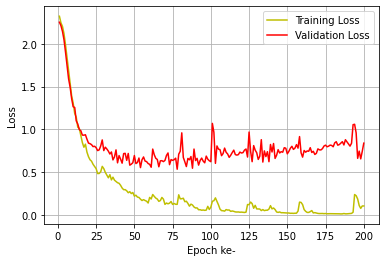

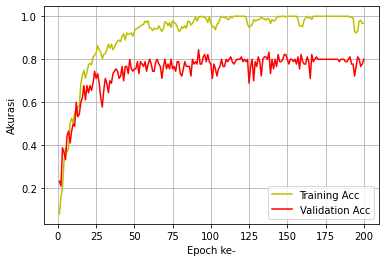

In [541]:
# Plot training and validation

loss18 = history18.history["loss"]
val_loss18 = history18.history["val_loss"]
epochs18 = range(1, len(loss18) + 1)
plt.plot(epochs18, loss18, "y", zorder=3, label="Training Loss")
plt.plot(epochs18, val_loss18, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc18 = history18.history["categorical_accuracy"]
val_acc18 = history18.history["val_categorical_accuracy"]
plt.plot(epochs18, acc18, "y", zorder=3, label="Training Acc")
plt.plot(epochs18, val_acc18, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Akurasi")
plt.legend()
plt.show()

In [42]:
df_18 = pd.read_csv("history/others/csv/lstm_pasl_3.csv")
df_18.head()

Unnamed: 0      loss  categorical_accuracy  val_loss  \
0           0  2.322913              0.081481  2.252987   
1           1  2.245750              0.159259  2.212944   
2           2  2.203703              0.203704  2.145305   
3           3  2.118440              0.325926  2.047151   
4           4  1.986226              0.388889  1.900777   

   val_categorical_accuracy  
0                  0.233333  
1                  0.211111  
2                  0.388889  
3                  0.366667  
4                  0.333333

In [43]:
df_18_processed = df_18.copy(deep=True)

df_18_processed["categorical_accuracy"] = df_18_processed["categorical_accuracy"]*100
df_18_processed["val_categorical_accuracy"] = df_18_processed["val_categorical_accuracy"]*100

df_18_processed

Unnamed: 0      loss  categorical_accuracy  val_loss  \
0             0  2.322913              8.148148  2.252987   
1             1  2.245750             15.925926  2.212944   
2             2  2.203703             20.370370  2.145305   
3             3  2.118440             32.592592  2.047151   
4             4  1.986226             38.888890  1.900777   
..          ...       ...                   ...       ...   
195         195  0.183723             92.962962  0.659502   
196         196  0.107354             97.777778  0.743895   
197         197  0.073626             98.148149  0.653280   
198         198  0.102138             96.666664  0.740915   
199         199  0.101941             96.666664  0.837266   

     val_categorical_accuracy  
0                   23.333333  
1                   21.111111  
2                   38.888890  
3                   36.666667  
4                   33.333334  
..                        ...  
195                 81.111109  
196                 80.000001  
197                 76.666665  
198                 77.777779  
199                 80.000001  

[200 rows x 5 columns]

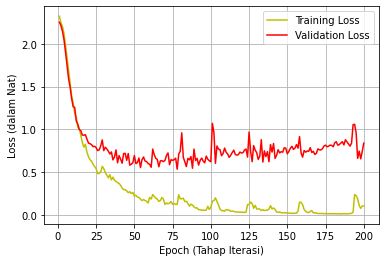

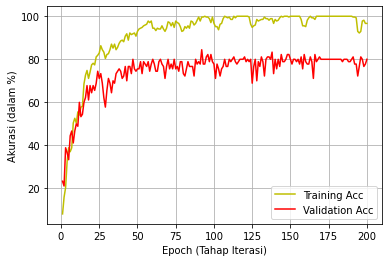

In [49]:
# Plot training and validation

loss18_2 = df_18_processed["loss"]
val_loss18_2 = df_18_processed["val_loss"]
epochs18_2 = range(1, len(loss18_2) + 1)
plt.plot(epochs18_2, loss18_2, "y", zorder=3, label="Training Loss")
plt.plot(epochs18_2, val_loss18_2, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch (Tahap Iterasi)")
plt.ylabel("Loss (dalam Nat)")
plt.legend()
plt.show()

acc18_2 = df_18_processed["categorical_accuracy"]
val_acc18_2 = df_18_processed["val_categorical_accuracy"]
plt.plot(epochs18_2, acc18_2, "y", zorder=3, label="Training Acc")
plt.plot(epochs18_2, val_acc18_2, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch (Tahap Iterasi)")
plt.ylabel("Akurasi (dalam %)")
plt.legend()
plt.show()

In [542]:
res18 = lstm_pasl_3.predict(X_test)

In [543]:
yhat18 = lstm_pasl_3.predict(X_test)
ytrue18 = np.argmax(y_test, axis=1).tolist()
yhat18 = np.argmax(yhat18, axis=1).tolist()

Confusion matrix, without normalization
[[4 2 3 0 0 0 0 0 0 0]
 [1 5 1 0 1 0 1 0 0 0]
 [3 2 4 0 0 0 0 0 0 0]
 [0 0 0 7 0 1 0 0 1 0]
 [1 0 1 0 6 1 0 0 0 0]
 [0 0 0 0 0 9 0 0 0 0]
 [0 1 0 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 1 0 0 0 0 8 0]
 [0 0 0 0 0 0 0 0 0 9]]


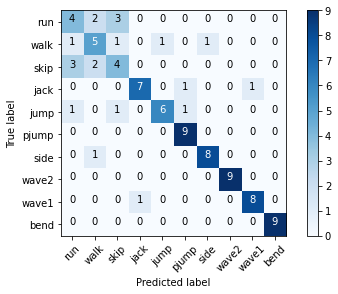

In [544]:
cm18 = confusion_matrix(y_true = ytrue18, y_pred = yhat18)
cm_plot_labels18 = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm18, classes = cm_plot_labels18, title = "")

In [545]:
fp18 = cm18.sum(axis=0) - np.diag(cm18)  
fn18 = cm18.sum(axis=1) - np.diag(cm18)
tp18 = np.diag(cm18)
tn18 = cm18.sum() - (fp18 + fn18 + tp18)

print(tp18)
print(fp18)
print(tn18)
print(fn18)

[4 5 4 7 6 9 8 9 8 9]
[5 5 5 1 1 2 1 0 1 0]
[76 76 76 80 80 79 80 81 80 81]
[5 4 5 2 3 0 1 0 1 0]


In [546]:
y_pred18 = lstm_pasl_3.predict(X_test)
y_pred18 = (y_pred18 > 0.5)

In [547]:
_, acc18 = lstm_pasl_3.evaluate(X_test, y_test)
print("Accuracy = ", (acc18*100), " %")

3/3 [==============================] - 0s 72ms/step - loss: 0.6172 - categorical_accuracy: 0.7667
Accuracy =  76.66666507720947  %


In [548]:
loss18_2, acc18_2 = lstm_pasl_3.evaluate(X_train, y_train)
loss18_3, acc18_3 = lstm_pasl_3.evaluate(X_valid, y_valid)

print("Accuracy2 = ", (acc18_2*100), " %")
print("Accuracy3 = ", (acc18_3*100), " %")

3/3 [==============================] - 0s 70ms/step - loss: 0.5801 - categorical_accuracy: 0.8444
Accuracy2 =  100.0  %
Accuracy3 =  84.44444537162781  %


In [549]:
acc18 = accuracy_score(ytrue18, yhat18)
acc18

0.7666666666666667

In [550]:
# Error rate
error_rate18 = 1 - acc18
error_rate18

0.23333333333333328

In [551]:
print(classification_report(
      ytrue18,
      yhat18,
      output_dict=False,
      target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.44      0.44      0.44         9
        walk       0.50      0.56      0.53         9
        skip       0.44      0.44      0.44         9
        jack       0.88      0.78      0.82         9
        jump       0.86      0.67      0.75         9
       pjump       0.82      1.00      0.90         9
        side       0.89      0.89      0.89         9
       wave2       1.00      1.00      1.00         9
       wave1       0.89      0.89      0.89         9
        bend       1.00      1.00      1.00         9

    accuracy                           0.77        90
   macro avg       0.77      0.77      0.77        90
weighted avg       0.77      0.77      0.77        90



# lstm_ahm_1
lstm1=64 + ADAM + dropout=0.3 + lr=0.01
train:1min 2s, test:69,99%

addition:
ModelCheckpoint + epochs=200 + batch size=32

The Classification of Abnormal Hand Movement to Aid in Autism Detection: Machine Learning Study
#### Model LSTM AHM 1st

In [556]:
# Define a sequential model
lstm_ahm_1 = Sequential([
    LSTM(64, return_sequences=False, input_shape=(25,132)),
    Dropout(0.3),
    Dense(actions.shape[0], activation="softmax")
])

In [557]:
# Compile model with learning rate
lstm_ahm_1.compile(Adam(learning_rate=0.01),
                      loss="categorical_crossentropy",
                      metrics=["categorical_accuracy"])

In [554]:
# Model Checkpoint Callback - reconfig

checkpoint_filepath19 = os.path.join("tmp/mc_lstm_ahm_1_e{epoch:04d}_val{val_categorical_accuracy:.3f}.h5")

mc_val_acc = ModelCheckpoint(filepath = checkpoint_filepath19,
                             monitor="val_categorical_accuracy",
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode="max",
                             save_freq="epoch")

In [558]:
%%time
# Training model with validation
history19 = lstm_ahm_1.fit(X_train, y_train, batch_size=32, epochs=200, verbose=2,
                             validation_data=(X_valid, y_valid), callbacks=[mc_val_acc])

Epoch 1/200

Epoch 00001: val_categorical_accuracy improved from -inf to 0.08889, saving model to tmp\mc_lstm_ahm_1_e0001_val0.089.h5
9/9 - 5s - loss: 2.4068 - categorical_accuracy: 0.1037 - val_loss: 2.3032 - val_categorical_accuracy: 0.0889 - 5s/epoch - 544ms/step
Epoch 2/200

Epoch 00002: val_categorical_accuracy improved from 0.08889 to 0.21111, saving model to tmp\mc_lstm_ahm_1_e0002_val0.211.h5
9/9 - 0s - loss: 2.2510 - categorical_accuracy: 0.1815 - val_loss: 2.1803 - val_categorical_accuracy: 0.2111 - 346ms/epoch - 38ms/step
Epoch 3/200

Epoch 00003: val_categorical_accuracy improved from 0.21111 to 0.23333, saving model to tmp\mc_lstm_ahm_1_e0003_val0.233.h5
9/9 - 0s - loss: 2.0973 - categorical_accuracy: 0.2444 - val_loss: 2.0607 - val_categorical_accuracy: 0.2333 - 344ms/epoch - 38ms/step
Epoch 4/200

Epoch 00004: val_categorical_accuracy improved from 0.23333 to 0.30000, saving model to tmp\mc_lstm_ahm_1_e0004_val0.300.h5
9/9 - 0s - loss: 1.9667 - categorical_accuracy: 0.25

Epoch 36/200

Epoch 00036: val_categorical_accuracy did not improve from 0.64444
9/9 - 0s - loss: 0.7607 - categorical_accuracy: 0.7185 - val_loss: 0.8627 - val_categorical_accuracy: 0.6444 - 273ms/epoch - 30ms/step
Epoch 37/200

Epoch 00037: val_categorical_accuracy did not improve from 0.64444
9/9 - 0s - loss: 0.7357 - categorical_accuracy: 0.6704 - val_loss: 0.7886 - val_categorical_accuracy: 0.6333 - 285ms/epoch - 32ms/step
Epoch 38/200

Epoch 00038: val_categorical_accuracy did not improve from 0.64444
9/9 - 0s - loss: 0.8167 - categorical_accuracy: 0.6481 - val_loss: 0.8234 - val_categorical_accuracy: 0.6333 - 286ms/epoch - 32ms/step
Epoch 39/200

Epoch 00039: val_categorical_accuracy did not improve from 0.64444
9/9 - 0s - loss: 0.7383 - categorical_accuracy: 0.7259 - val_loss: 0.7894 - val_categorical_accuracy: 0.6444 - 275ms/epoch - 31ms/step
Epoch 40/200

Epoch 00040: val_categorical_accuracy did not improve from 0.64444
9/9 - 0s - loss: 0.7970 - categorical_accuracy: 0.6519 

Epoch 73/200

Epoch 00073: val_categorical_accuracy did not improve from 0.77778
9/9 - 0s - loss: 0.3684 - categorical_accuracy: 0.8444 - val_loss: 0.6109 - val_categorical_accuracy: 0.7667 - 288ms/epoch - 32ms/step
Epoch 74/200

Epoch 00074: val_categorical_accuracy improved from 0.77778 to 0.82222, saving model to tmp\mc_lstm_ahm_1_e0074_val0.822.h5
9/9 - 0s - loss: 0.4701 - categorical_accuracy: 0.8074 - val_loss: 0.5837 - val_categorical_accuracy: 0.8222 - 301ms/epoch - 33ms/step
Epoch 75/200

Epoch 00075: val_categorical_accuracy did not improve from 0.82222
9/9 - 0s - loss: 0.4700 - categorical_accuracy: 0.8185 - val_loss: 0.7571 - val_categorical_accuracy: 0.6556 - 275ms/epoch - 31ms/step
Epoch 76/200

Epoch 00076: val_categorical_accuracy did not improve from 0.82222
9/9 - 0s - loss: 0.4550 - categorical_accuracy: 0.8259 - val_loss: 0.6504 - val_categorical_accuracy: 0.7556 - 273ms/epoch - 30ms/step
Epoch 77/200

Epoch 00077: val_categorical_accuracy did not improve from 0.8222

Epoch 111/200

Epoch 00111: val_categorical_accuracy did not improve from 0.82222
9/9 - 0s - loss: 0.4359 - categorical_accuracy: 0.8407 - val_loss: 0.6158 - val_categorical_accuracy: 0.7667 - 278ms/epoch - 31ms/step
Epoch 112/200

Epoch 00112: val_categorical_accuracy did not improve from 0.82222
9/9 - 0s - loss: 0.4014 - categorical_accuracy: 0.8370 - val_loss: 0.7689 - val_categorical_accuracy: 0.7222 - 285ms/epoch - 32ms/step
Epoch 113/200

Epoch 00113: val_categorical_accuracy did not improve from 0.82222
9/9 - 0s - loss: 0.2839 - categorical_accuracy: 0.8963 - val_loss: 0.7048 - val_categorical_accuracy: 0.7778 - 280ms/epoch - 31ms/step
Epoch 114/200

Epoch 00114: val_categorical_accuracy did not improve from 0.82222
9/9 - 0s - loss: 0.4445 - categorical_accuracy: 0.8333 - val_loss: 0.6856 - val_categorical_accuracy: 0.7222 - 281ms/epoch - 31ms/step
Epoch 115/200

Epoch 00115: val_categorical_accuracy did not improve from 0.82222
9/9 - 0s - loss: 0.6381 - categorical_accuracy: 0.

Epoch 149/200

Epoch 00149: val_categorical_accuracy did not improve from 0.84444
9/9 - 0s - loss: 0.2647 - categorical_accuracy: 0.8926 - val_loss: 0.5735 - val_categorical_accuracy: 0.8111 - 290ms/epoch - 32ms/step
Epoch 150/200

Epoch 00150: val_categorical_accuracy did not improve from 0.84444
9/9 - 0s - loss: 0.2528 - categorical_accuracy: 0.9037 - val_loss: 0.6553 - val_categorical_accuracy: 0.7444 - 290ms/epoch - 32ms/step
Epoch 151/200

Epoch 00151: val_categorical_accuracy did not improve from 0.84444
9/9 - 0s - loss: 0.2113 - categorical_accuracy: 0.9444 - val_loss: 0.6980 - val_categorical_accuracy: 0.8000 - 285ms/epoch - 32ms/step
Epoch 152/200

Epoch 00152: val_categorical_accuracy did not improve from 0.84444
9/9 - 0s - loss: 0.2392 - categorical_accuracy: 0.9185 - val_loss: 0.8350 - val_categorical_accuracy: 0.7556 - 291ms/epoch - 32ms/step
Epoch 153/200

Epoch 00153: val_categorical_accuracy did not improve from 0.84444
9/9 - 0s - loss: 0.4043 - categorical_accuracy: 0.

Epoch 187/200

Epoch 00187: val_categorical_accuracy did not improve from 0.84444
9/9 - 0s - loss: 0.2675 - categorical_accuracy: 0.8926 - val_loss: 0.4844 - val_categorical_accuracy: 0.8333 - 282ms/epoch - 31ms/step
Epoch 188/200

Epoch 00188: val_categorical_accuracy did not improve from 0.84444
9/9 - 0s - loss: 0.2466 - categorical_accuracy: 0.9111 - val_loss: 0.5354 - val_categorical_accuracy: 0.8444 - 285ms/epoch - 32ms/step
Epoch 189/200

Epoch 00189: val_categorical_accuracy did not improve from 0.84444
9/9 - 0s - loss: 0.2826 - categorical_accuracy: 0.8926 - val_loss: 0.5176 - val_categorical_accuracy: 0.8222 - 321ms/epoch - 36ms/step
Epoch 190/200

Epoch 00190: val_categorical_accuracy did not improve from 0.84444
9/9 - 0s - loss: 0.2155 - categorical_accuracy: 0.9333 - val_loss: 0.4964 - val_categorical_accuracy: 0.8222 - 310ms/epoch - 34ms/step
Epoch 191/200

Epoch 00191: val_categorical_accuracy did not improve from 0.84444
9/9 - 0s - loss: 0.1953 - categorical_accuracy: 0.

In [559]:
# Save history to json and csv

# convert the history18.history dict to a pandas DataFrame:     
hist_df_19 = pd.DataFrame(history19.history) 

# save to json:  
hist_json_file_19 = 'history/others/json/lstm_ahm_1.json' 
with open(hist_json_file_19, mode='w') as f:
    hist_df_19.to_json(f)

# or save to csv: 
hist_csv_file_19 = 'history/others/csv/lstm_ahm_1.csv'
with open(hist_csv_file_19, mode='w') as f:
    hist_df_19.to_csv(f)

In [302]:
lstm_ahm_1.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 25, 100)           93200     
                                                                 
 dropout_12 (Dropout)        (None, 25, 100)           0         
                                                                 
 lstm_31 (LSTM)              (None, 25, 100)           80400     
                                                                 
 dropout_13 (Dropout)        (None, 25, 100)           0         
                                                                 
 dense_28 (Dense)            (None, 25, 10)            1010      
                                                                 
Total params: 174,610
Trainable params: 174,610
Non-trainable params: 0
_________________________________________________________________


In [560]:
# Load Model
lstm_ahm_1.load_weights("tmp\mc_lstm_ahm_1_e0130_val0.844.h5")

In [ ]:
# Save Model
lstm_ahm_1.save("model2\lstm2_dense2_rd_lr5_75_b2_default_mc_3_e0116_val0.833.h5")

In [ ]:
# Visualize
plot_model(lstm_ahm_1, to_file = "arc_lstm2_dense2_rd_lr5_75_b2_default_mc_3_1840_23032022.png", show_shapes = True)

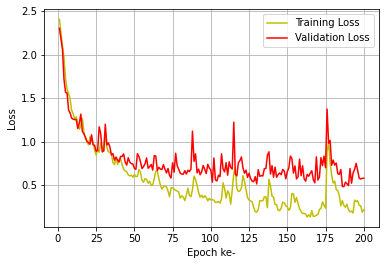

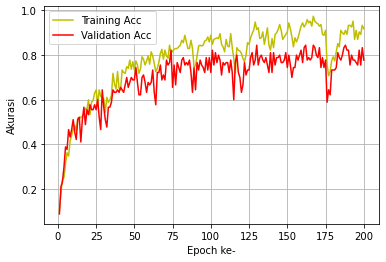

In [561]:
# Plot training and validation

loss19 = history19.history["loss"]
val_loss19 = history19.history["val_loss"]
epochs19 = range(1, len(loss19) + 1)
plt.plot(epochs19, loss19, "y", zorder=3, label="Training Loss")
plt.plot(epochs19, val_loss19, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc19 = history19.history["categorical_accuracy"]
val_acc19 = history19.history["val_categorical_accuracy"]
plt.plot(epochs19, acc19, "y", zorder=3, label="Training Acc")
plt.plot(epochs19, val_acc19, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Akurasi")
plt.legend()
plt.show()

In [562]:
res19 = lstm_ahm_1.predict(X_test)

In [563]:
yhat19 = lstm_ahm_1.predict(X_test)
ytrue19 = np.argmax(y_test, axis=1).tolist()
yhat19 = np.argmax(yhat19, axis=1).tolist()

Confusion matrix, without normalization
[[5 2 2 0 0 0 0 0 0 0]
 [2 5 1 0 1 0 0 0 0 0]
 [3 1 2 0 3 0 0 0 0 0]
 [0 0 0 9 0 0 0 0 0 0]
 [1 0 1 0 7 0 0 0 0 0]
 [0 0 0 1 0 6 2 0 0 0]
 [1 0 0 0 0 4 4 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 1 0 1 0 0 7 0]
 [0 0 0 0 0 0 0 0 0 9]]


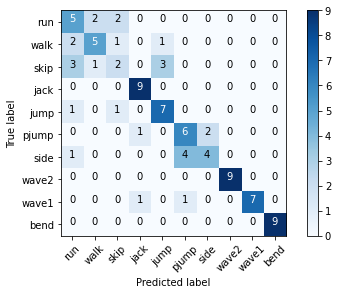

In [564]:
cm19 = confusion_matrix(y_true = ytrue19, y_pred = yhat19)
cm_plot_labels19 = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm19, classes = cm_plot_labels19, title = "")

In [565]:
fp19 = cm19.sum(axis=0) - np.diag(cm19)  
fn19 = cm19.sum(axis=1) - np.diag(cm19)
tp19 = np.diag(cm19)
tn19 = cm19.sum() - (fp19 + fn19 + tp19)

print(tp19)
print(fp19)
print(tn19)
print(fn19)

[5 5 2 9 7 6 4 9 7 9]
[7 3 4 2 4 5 2 0 0 0]
[74 78 77 79 77 76 79 81 81 81]
[4 4 7 0 2 3 5 0 2 0]


In [566]:
y_pred19 = lstm_ahm_1.predict(X_test)
y_pred19 = (y_pred19 > 0.5)

In [567]:
_, acc19 = lstm_ahm_1.evaluate(X_test, y_test)
print("Accuracy = ", (acc19*100), " %")

3/3 [==============================] - 0s 13ms/step - loss: 0.9060 - categorical_accuracy: 0.7000
Accuracy =  69.9999988079071  %


In [568]:
loss19_2, acc19_2 = lstm_ahm_1.evaluate(X_train, y_train)
loss19_3, acc19_3 = lstm_ahm_1.evaluate(X_valid, y_valid)

print("Accuracy2 = ", (acc19_2*100), " %")
print("Accuracy3 = ", (acc19_3*100), " %")

3/3 [==============================] - 0s 12ms/step - loss: 0.5151 - categorical_accuracy: 0.8444
Accuracy2 =  96.29629850387573  %
Accuracy3 =  84.44444537162781  %


In [569]:
acc19 = accuracy_score(ytrue19, yhat19)
acc19

0.7

In [570]:
# Error rate
error_rate19 = 1 - acc19
error_rate19

0.30000000000000004

In [571]:
print(classification_report(
      ytrue19,
      yhat19,
      output_dict=False,
      target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.42      0.56      0.48         9
        walk       0.62      0.56      0.59         9
        skip       0.33      0.22      0.27         9
        jack       0.82      1.00      0.90         9
        jump       0.64      0.78      0.70         9
       pjump       0.55      0.67      0.60         9
        side       0.67      0.44      0.53         9
       wave2       1.00      1.00      1.00         9
       wave1       1.00      0.78      0.88         9
        bend       1.00      1.00      1.00         9

    accuracy                           0.70        90
   macro avg       0.70      0.70      0.69        90
weighted avg       0.70      0.70      0.69        90



# lstm_ahm_2
lstm1=64 + ADAM + dropout=0.3 + lr=0.01
train:1min 4s, test:76.66%

addition:
ModelCheckpoint + epochs=200 + batchsize=32

The Classification of Abnormal Hand Movement to Aid in Autism Detection: Machine Learning Study
#### Model LSTM AHM 2nd (Chosen)

In [572]:
# Define a sequential model
lstm_ahm_2 = Sequential([
    LSTM(64, return_sequences=False, input_shape=(25,132)),
    Dropout(0.3),
    Dense(actions.shape[0], activation="softmax")
])

In [573]:
# Compile model with learning rate
lstm_ahm_2.compile(Adam(learning_rate=0.01),
                      loss="categorical_crossentropy",
                      metrics=["categorical_accuracy"])

In [574]:
# Model Checkpoint Callback - reconfig

checkpoint_filepath20 = os.path.join("tmp/mc_lstm_ahm_2_e{epoch:04d}_val{val_categorical_accuracy:.3f}.h5")

mc_val_acc = ModelCheckpoint(filepath = checkpoint_filepath20,
                             monitor="val_categorical_accuracy",
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode="max",
                             save_freq="epoch")

In [575]:
%%time
# Training model with validation
history20 = lstm_ahm_2.fit(X_train, y_train, batch_size=32, epochs=200, verbose=2,
                             validation_data=(X_valid, y_valid), callbacks=[mc_val_acc])

Epoch 1/200

Epoch 00001: val_categorical_accuracy improved from -inf to 0.21111, saving model to tmp\mc_lstm_ahm_2_e0001_val0.211.h5
9/9 - 5s - loss: 2.3832 - categorical_accuracy: 0.1222 - val_loss: 2.1126 - val_categorical_accuracy: 0.2111 - 5s/epoch - 548ms/step
Epoch 2/200

Epoch 00002: val_categorical_accuracy improved from 0.21111 to 0.24444, saving model to tmp\mc_lstm_ahm_2_e0002_val0.244.h5
9/9 - 0s - loss: 2.0416 - categorical_accuracy: 0.2185 - val_loss: 1.9792 - val_categorical_accuracy: 0.2444 - 327ms/epoch - 36ms/step
Epoch 3/200

Epoch 00003: val_categorical_accuracy improved from 0.24444 to 0.34444, saving model to tmp\mc_lstm_ahm_2_e0003_val0.344.h5
9/9 - 0s - loss: 1.9120 - categorical_accuracy: 0.2630 - val_loss: 1.7108 - val_categorical_accuracy: 0.3444 - 365ms/epoch - 41ms/step
Epoch 4/200

Epoch 00004: val_categorical_accuracy did not improve from 0.34444
9/9 - 0s - loss: 1.7455 - categorical_accuracy: 0.2778 - val_loss: 1.6439 - val_categorical_accuracy: 0.3000 

Epoch 37/200

Epoch 00037: val_categorical_accuracy did not improve from 0.60000
9/9 - 0s - loss: 0.9493 - categorical_accuracy: 0.6556 - val_loss: 1.0142 - val_categorical_accuracy: 0.5556 - 283ms/epoch - 31ms/step
Epoch 38/200

Epoch 00038: val_categorical_accuracy improved from 0.60000 to 0.61111, saving model to tmp\mc_lstm_ahm_2_e0038_val0.611.h5
9/9 - 0s - loss: 0.9575 - categorical_accuracy: 0.6296 - val_loss: 0.9661 - val_categorical_accuracy: 0.6111 - 299ms/epoch - 33ms/step
Epoch 39/200

Epoch 00039: val_categorical_accuracy did not improve from 0.61111
9/9 - 0s - loss: 0.9821 - categorical_accuracy: 0.5593 - val_loss: 0.9669 - val_categorical_accuracy: 0.5444 - 289ms/epoch - 32ms/step
Epoch 40/200

Epoch 00040: val_categorical_accuracy did not improve from 0.61111
9/9 - 0s - loss: 0.9420 - categorical_accuracy: 0.5926 - val_loss: 0.9435 - val_categorical_accuracy: 0.5333 - 288ms/epoch - 32ms/step
Epoch 41/200

Epoch 00041: val_categorical_accuracy did not improve from 0.6111

Epoch 74/200

Epoch 00074: val_categorical_accuracy did not improve from 0.66667
9/9 - 0s - loss: 0.7305 - categorical_accuracy: 0.6815 - val_loss: 0.8309 - val_categorical_accuracy: 0.6556 - 304ms/epoch - 34ms/step
Epoch 75/200

Epoch 00075: val_categorical_accuracy improved from 0.66667 to 0.71111, saving model to tmp\mc_lstm_ahm_2_e0075_val0.711.h5
9/9 - 0s - loss: 0.6789 - categorical_accuracy: 0.7259 - val_loss: 0.7887 - val_categorical_accuracy: 0.7111 - 426ms/epoch - 47ms/step
Epoch 76/200

Epoch 00076: val_categorical_accuracy did not improve from 0.71111
9/9 - 0s - loss: 0.7356 - categorical_accuracy: 0.7148 - val_loss: 0.9541 - val_categorical_accuracy: 0.6111 - 280ms/epoch - 31ms/step
Epoch 77/200

Epoch 00077: val_categorical_accuracy did not improve from 0.71111
9/9 - 0s - loss: 0.7580 - categorical_accuracy: 0.6926 - val_loss: 0.8259 - val_categorical_accuracy: 0.6556 - 293ms/epoch - 33ms/step
Epoch 78/200

Epoch 00078: val_categorical_accuracy did not improve from 0.7111

Epoch 112/200

Epoch 00112: val_categorical_accuracy did not improve from 0.72222
9/9 - 0s - loss: 0.6035 - categorical_accuracy: 0.7889 - val_loss: 0.7575 - val_categorical_accuracy: 0.6667 - 285ms/epoch - 32ms/step
Epoch 113/200

Epoch 00113: val_categorical_accuracy did not improve from 0.72222
9/9 - 0s - loss: 0.5597 - categorical_accuracy: 0.7667 - val_loss: 0.9140 - val_categorical_accuracy: 0.6556 - 295ms/epoch - 33ms/step
Epoch 114/200

Epoch 00114: val_categorical_accuracy did not improve from 0.72222
9/9 - 0s - loss: 0.5776 - categorical_accuracy: 0.8111 - val_loss: 0.8273 - val_categorical_accuracy: 0.6889 - 293ms/epoch - 33ms/step
Epoch 115/200

Epoch 00115: val_categorical_accuracy did not improve from 0.72222
9/9 - 0s - loss: 0.5858 - categorical_accuracy: 0.7815 - val_loss: 0.7741 - val_categorical_accuracy: 0.6778 - 356ms/epoch - 40ms/step
Epoch 116/200

Epoch 00116: val_categorical_accuracy did not improve from 0.72222
9/9 - 0s - loss: 0.5316 - categorical_accuracy: 0.

Epoch 150/200

Epoch 00150: val_categorical_accuracy did not improve from 0.73333
9/9 - 0s - loss: 0.4821 - categorical_accuracy: 0.8370 - val_loss: 0.8327 - val_categorical_accuracy: 0.6889 - 285ms/epoch - 32ms/step
Epoch 151/200

Epoch 00151: val_categorical_accuracy did not improve from 0.73333
9/9 - 0s - loss: 0.4621 - categorical_accuracy: 0.8259 - val_loss: 0.7569 - val_categorical_accuracy: 0.7111 - 277ms/epoch - 31ms/step
Epoch 152/200

Epoch 00152: val_categorical_accuracy did not improve from 0.73333
9/9 - 0s - loss: 0.4079 - categorical_accuracy: 0.8519 - val_loss: 0.8668 - val_categorical_accuracy: 0.7111 - 283ms/epoch - 31ms/step
Epoch 153/200

Epoch 00153: val_categorical_accuracy did not improve from 0.73333
9/9 - 0s - loss: 0.4893 - categorical_accuracy: 0.8148 - val_loss: 0.9240 - val_categorical_accuracy: 0.6444 - 290ms/epoch - 32ms/step
Epoch 154/200

Epoch 00154: val_categorical_accuracy did not improve from 0.73333
9/9 - 0s - loss: 0.5242 - categorical_accuracy: 0.

Epoch 188/200

Epoch 00188: val_categorical_accuracy improved from 0.76667 to 0.77778, saving model to tmp\mc_lstm_ahm_2_e0188_val0.778.h5
9/9 - 0s - loss: 0.3316 - categorical_accuracy: 0.8815 - val_loss: 0.7214 - val_categorical_accuracy: 0.7778 - 303ms/epoch - 34ms/step
Epoch 189/200

Epoch 00189: val_categorical_accuracy did not improve from 0.77778
9/9 - 0s - loss: 0.2769 - categorical_accuracy: 0.8815 - val_loss: 0.7730 - val_categorical_accuracy: 0.7222 - 284ms/epoch - 32ms/step
Epoch 190/200

Epoch 00190: val_categorical_accuracy did not improve from 0.77778
9/9 - 0s - loss: 0.2903 - categorical_accuracy: 0.8815 - val_loss: 0.7414 - val_categorical_accuracy: 0.7444 - 275ms/epoch - 31ms/step
Epoch 191/200

Epoch 00191: val_categorical_accuracy did not improve from 0.77778
9/9 - 0s - loss: 0.2581 - categorical_accuracy: 0.9222 - val_loss: 0.7592 - val_categorical_accuracy: 0.7222 - 280ms/epoch - 31ms/step
Epoch 192/200

Epoch 00192: val_categorical_accuracy did not improve from 0

In [576]:
# Save history to json and csv

# convert the history18.history dict to a pandas DataFrame:     
hist_df_20 = pd.DataFrame(history20.history) 

# save to json:  
hist_json_file_20 = 'history/others/json/lstm_ahm_2.json' 
with open(hist_json_file_20, mode='w') as f:
    hist_df_20.to_json(f)

# or save to csv: 
hist_csv_file_20 = 'history/others/csv/lstm_ahm_2.csv'
with open(hist_csv_file_20, mode='w') as f:
    hist_df_20.to_csv(f)

In [302]:
lstm_ahm_2.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 25, 100)           93200     
                                                                 
 dropout_12 (Dropout)        (None, 25, 100)           0         
                                                                 
 lstm_31 (LSTM)              (None, 25, 100)           80400     
                                                                 
 dropout_13 (Dropout)        (None, 25, 100)           0         
                                                                 
 dense_28 (Dense)            (None, 25, 10)            1010      
                                                                 
Total params: 174,610
Trainable params: 174,610
Non-trainable params: 0
_________________________________________________________________


In [757]:
# Load Model
lstm_ahm_2.load_weights("tmp\mc_lstm_ahm_2_e0197_val0.800.h5")

In [758]:
# Save Model
lstm_ahm_2.save("model/others/lstm_ahm_2_e0197_val0.800.h5")

In [ ]:
# Visualize
plot_model(lstm_ahm_2, to_file = "arc_lstm2_dense2_rd_lr5_75_b2_default_mc_3_1840_23032022.png", show_shapes = True)

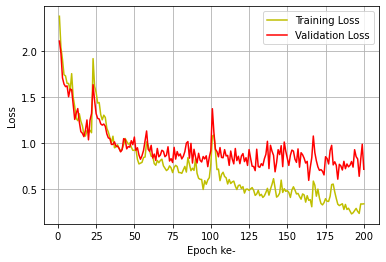

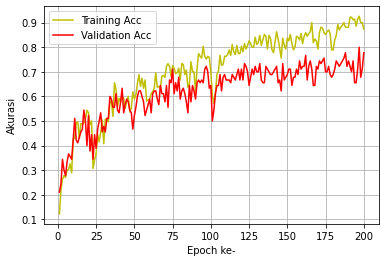

In [578]:
# Plot training and validation

loss20 = history20.history["loss"]
val_loss20 = history20.history["val_loss"]
epochs20 = range(1, len(loss20) + 1)
plt.plot(epochs20, loss20, "y", zorder=3, label="Training Loss")
plt.plot(epochs20, val_loss20, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc20 = history20.history["categorical_accuracy"]
val_acc20 = history20.history["val_categorical_accuracy"]
plt.plot(epochs20, acc20, "y", zorder=3, label="Training Acc")
plt.plot(epochs20, val_acc20, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Akurasi")
plt.legend()
plt.show()

In [45]:
df_20 = pd.read_csv("history/others/csv/lstm_ahm_2.csv")
df_20.head()

Unnamed: 0      loss  categorical_accuracy  val_loss  \
0           0  2.383243              0.122222  2.112649   
1           1  2.041642              0.218519  1.979172   
2           2  1.911998              0.262963  1.710834   
3           3  1.745474              0.277778  1.643908   
4           4  1.733008              0.270370  1.615919   

   val_categorical_accuracy  
0                  0.211111  
1                  0.244444  
2                  0.344444  
3                  0.300000  
4                  0.277778

In [46]:
df_20_processed = df_20.copy(deep=True)

df_20_processed["categorical_accuracy"] = df_20_processed["categorical_accuracy"]*100
df_20_processed["val_categorical_accuracy"] = df_20_processed["val_categorical_accuracy"]*100

df_20_processed

Unnamed: 0      loss  categorical_accuracy  val_loss  \
0             0  2.383243             12.222222  2.112649   
1             1  2.041642             21.851853  1.979172   
2             2  1.911998             26.296297  1.710834   
3             3  1.745474             27.777779  1.643908   
4             4  1.733008             27.037036  1.615919   
..          ...       ...                   ...       ...   
195         195  0.256118             91.481483  0.827634   
196         196  0.233652             92.592591  0.638204   
197         197  0.337331             89.999998  0.822796   
198         198  0.336177             89.999998  0.987936   
199         199  0.338206             87.407410  0.715105   

     val_categorical_accuracy  
0                   21.111111  
1                   24.444444  
2                   34.444445  
3                   30.000001  
4                   27.777779  
..                        ...  
195                 71.111113  
196                 80.000001  
197                 67.777777  
198                 71.111113  
199                 77.777779  

[200 rows x 5 columns]

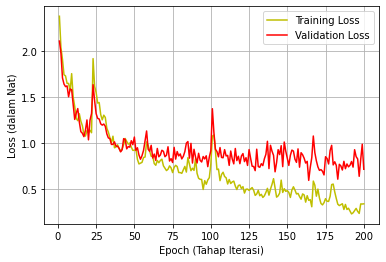

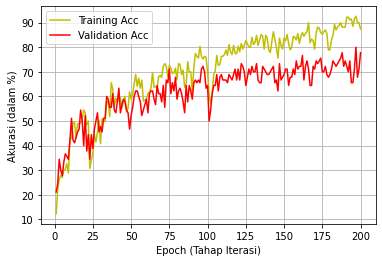

In [48]:
# Plot training and validation

loss20_2 = df_20_processed["loss"]
val_loss20_2 = df_20_processed["val_loss"]
epochs20_2 = range(1, len(loss20_2) + 1)
plt.plot(epochs20_2, loss20_2, "y", zorder=3, label="Training Loss")
plt.plot(epochs20_2, val_loss20_2, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch (Tahap Iterasi)")
plt.ylabel("Loss (dalam Nat)")
plt.legend()
plt.show()

acc20_2 = df_20_processed["categorical_accuracy"]
val_acc20_2 = df_20_processed["val_categorical_accuracy"]
plt.plot(epochs20_2, acc20_2, "y", zorder=3, label="Training Acc")
plt.plot(epochs20_2, val_acc20_2, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch (Tahap Iterasi)")
plt.ylabel("Akurasi (dalam %)")
plt.legend()
plt.show()

In [579]:
res20 = lstm_ahm_2.predict(X_test)

In [581]:
yhat20 = lstm_ahm_2.predict(X_test)
ytrue20 = np.argmax(y_test, axis=1).tolist()
yhat20 = np.argmax(yhat20, axis=1).tolist()

Confusion matrix, without normalization
[[5 3 1 0 0 0 0 0 0 0]
 [2 6 1 0 0 0 0 0 0 0]
 [3 2 2 0 2 0 0 0 0 0]
 [0 0 0 9 0 0 0 0 0 0]
 [1 0 0 0 8 0 0 0 0 0]
 [0 0 0 1 0 6 2 0 0 0]
 [0 0 0 0 0 2 7 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 1 8 0]
 [0 0 0 0 0 0 0 0 0 9]]


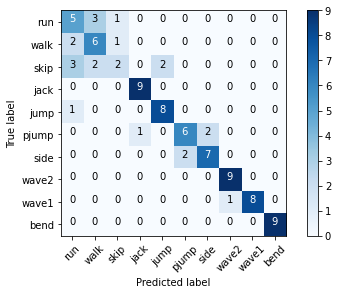

In [582]:
cm20 = confusion_matrix(y_true = ytrue20, y_pred = yhat20)
cm_plot_labels20 = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm20, classes = cm_plot_labels20, title = "")

In [583]:
fp20 = cm20.sum(axis=0) - np.diag(cm20)  
fn20 = cm20.sum(axis=1) - np.diag(cm20)
tp20 = np.diag(cm20)
tn20 = cm20.sum() - (fp20 + fn20 + tp20)

print(tp20)
print(fp20)
print(tn20)
print(fn20)

[5 6 2 9 8 6 7 9 8 9]
[6 5 2 1 2 2 2 1 0 0]
[75 76 79 80 79 79 79 80 81 81]
[4 3 7 0 1 3 2 0 1 0]


In [584]:
y_pred20 = lstm_ahm_2.predict(X_test)
y_pred20 = (y_pred20 > 0.5)

In [585]:
_, acc20 = lstm_ahm_2.evaluate(X_test, y_test)
print("Accuracy = ", (acc20*100), " %")

3/3 [==============================] - 0s 14ms/step - loss: 0.9079 - categorical_accuracy: 0.7667
Accuracy =  76.66666507720947  %


In [586]:
loss20_2, acc20_2 = lstm_ahm_2.evaluate(X_train, y_train)
loss20_3, acc20_3 = lstm_ahm_2.evaluate(X_valid, y_valid)

print("Accuracy2 = ", (acc20_2*100), " %")
print("Accuracy3 = ", (acc20_3*100), " %")

3/3 [==============================] - 0s 13ms/step - loss: 0.6382 - categorical_accuracy: 0.8000
Accuracy2 =  97.40740656852722  %
Accuracy3 =  80.0000011920929  %


In [587]:
acc20 = accuracy_score(ytrue20, yhat20)
acc20

0.7666666666666667

In [588]:
# Error rate
error_rate20 = 1 - acc20
error_rate20

0.23333333333333328

In [589]:
print(classification_report(
      ytrue20,
      yhat20,
      output_dict=False,
      target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.45      0.56      0.50         9
        walk       0.55      0.67      0.60         9
        skip       0.50      0.22      0.31         9
        jack       0.90      1.00      0.95         9
        jump       0.80      0.89      0.84         9
       pjump       0.75      0.67      0.71         9
        side       0.78      0.78      0.78         9
       wave2       0.90      1.00      0.95         9
       wave1       1.00      0.89      0.94         9
        bend       1.00      1.00      1.00         9

    accuracy                           0.77        90
   macro avg       0.76      0.77      0.76        90
weighted avg       0.76      0.77      0.76        90



# lstm_ahm_3
lstm1=64 + ADAM + dropout=0.3 + lr=0.01
train:1min 12s, test:71.11%

addition:
ModelCheckpoint + epochs=200

The Classification of Abnormal Hand Movement to Aid in Autism Detection: Machine Learning Study
#### Model LSTM AHM 3rd

In [590]:
# Define a sequential model
lstm_ahm_3 = Sequential([
    LSTM(64, return_sequences=False, input_shape=(25,132)),
    Dropout(0.3),
    Dense(actions.shape[0], activation="softmax")
])

In [591]:
# Compile model with learning rate
lstm_ahm_3.compile(Adam(learning_rate=0.01),
                      loss="categorical_crossentropy",
                      metrics=["categorical_accuracy"])

In [592]:
# Model Checkpoint Callback - reconfig

checkpoint_filepath21 = os.path.join("tmp/mc_lstm_ahm_3_e{epoch:04d}_val{val_categorical_accuracy:.3f}.h5")

mc_val_acc = ModelCheckpoint(filepath = checkpoint_filepath21,
                             monitor="val_categorical_accuracy",
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode="max",
                             save_freq="epoch")

In [593]:
%%time
# Training model with validation
history21 = lstm_ahm_3.fit(X_train, y_train, batch_size=32, epochs=200, verbose=2,
                             validation_data=(X_valid, y_valid), callbacks=[mc_val_acc])

Epoch 1/200

Epoch 00001: val_categorical_accuracy improved from -inf to 0.21111, saving model to tmp\mc_lstm_ahm_3_e0001_val0.211.h5
9/9 - 8s - loss: 2.3606 - categorical_accuracy: 0.1444 - val_loss: 2.1201 - val_categorical_accuracy: 0.2111 - 8s/epoch - 891ms/step
Epoch 2/200

Epoch 00002: val_categorical_accuracy improved from 0.21111 to 0.30000, saving model to tmp\mc_lstm_ahm_3_e0002_val0.300.h5
9/9 - 0s - loss: 2.0296 - categorical_accuracy: 0.2556 - val_loss: 1.9300 - val_categorical_accuracy: 0.3000 - 341ms/epoch - 38ms/step
Epoch 3/200

Epoch 00003: val_categorical_accuracy improved from 0.30000 to 0.37778, saving model to tmp\mc_lstm_ahm_3_e0003_val0.378.h5
9/9 - 0s - loss: 1.8182 - categorical_accuracy: 0.3444 - val_loss: 1.6794 - val_categorical_accuracy: 0.3778 - 337ms/epoch - 37ms/step
Epoch 4/200

Epoch 00004: val_categorical_accuracy did not improve from 0.37778
9/9 - 0s - loss: 1.6425 - categorical_accuracy: 0.3667 - val_loss: 1.5713 - val_categorical_accuracy: 0.3333 

Epoch 37/200

Epoch 00037: val_categorical_accuracy did not improve from 0.66667
9/9 - 0s - loss: 0.7414 - categorical_accuracy: 0.7111 - val_loss: 0.7827 - val_categorical_accuracy: 0.6556 - 323ms/epoch - 36ms/step
Epoch 38/200

Epoch 00038: val_categorical_accuracy did not improve from 0.66667
9/9 - 0s - loss: 0.7110 - categorical_accuracy: 0.7074 - val_loss: 1.0287 - val_categorical_accuracy: 0.6000 - 309ms/epoch - 34ms/step
Epoch 39/200

Epoch 00039: val_categorical_accuracy did not improve from 0.66667
9/9 - 0s - loss: 0.6800 - categorical_accuracy: 0.7444 - val_loss: 0.9661 - val_categorical_accuracy: 0.6000 - 346ms/epoch - 38ms/step
Epoch 40/200

Epoch 00040: val_categorical_accuracy did not improve from 0.66667
9/9 - 0s - loss: 0.8359 - categorical_accuracy: 0.6963 - val_loss: 0.9095 - val_categorical_accuracy: 0.5778 - 328ms/epoch - 36ms/step
Epoch 41/200

Epoch 00041: val_categorical_accuracy did not improve from 0.66667
9/9 - 0s - loss: 0.8332 - categorical_accuracy: 0.6481 

Epoch 74/200

Epoch 00074: val_categorical_accuracy did not improve from 0.73333
9/9 - 0s - loss: 0.5750 - categorical_accuracy: 0.7852 - val_loss: 0.7760 - val_categorical_accuracy: 0.6556 - 311ms/epoch - 35ms/step
Epoch 75/200

Epoch 00075: val_categorical_accuracy did not improve from 0.73333
9/9 - 0s - loss: 0.5041 - categorical_accuracy: 0.8074 - val_loss: 0.6073 - val_categorical_accuracy: 0.7111 - 317ms/epoch - 35ms/step
Epoch 76/200

Epoch 00076: val_categorical_accuracy did not improve from 0.73333
9/9 - 0s - loss: 0.5368 - categorical_accuracy: 0.7852 - val_loss: 0.6768 - val_categorical_accuracy: 0.6778 - 322ms/epoch - 36ms/step
Epoch 77/200

Epoch 00077: val_categorical_accuracy improved from 0.73333 to 0.75556, saving model to tmp\mc_lstm_ahm_3_e0077_val0.756.h5
9/9 - 0s - loss: 0.5005 - categorical_accuracy: 0.8148 - val_loss: 0.5895 - val_categorical_accuracy: 0.7556 - 353ms/epoch - 39ms/step
Epoch 78/200

Epoch 00078: val_categorical_accuracy did not improve from 0.7555

Epoch 112/200

Epoch 00112: val_categorical_accuracy did not improve from 0.75556
9/9 - 0s - loss: 0.6160 - categorical_accuracy: 0.7778 - val_loss: 0.7521 - val_categorical_accuracy: 0.7222 - 351ms/epoch - 39ms/step
Epoch 113/200

Epoch 00113: val_categorical_accuracy did not improve from 0.75556
9/9 - 0s - loss: 0.5156 - categorical_accuracy: 0.8185 - val_loss: 0.7081 - val_categorical_accuracy: 0.7111 - 338ms/epoch - 38ms/step
Epoch 114/200

Epoch 00114: val_categorical_accuracy did not improve from 0.75556
9/9 - 0s - loss: 0.4880 - categorical_accuracy: 0.7963 - val_loss: 0.7037 - val_categorical_accuracy: 0.7222 - 316ms/epoch - 35ms/step
Epoch 115/200

Epoch 00115: val_categorical_accuracy did not improve from 0.75556
9/9 - 0s - loss: 0.4374 - categorical_accuracy: 0.8074 - val_loss: 0.7177 - val_categorical_accuracy: 0.6778 - 312ms/epoch - 35ms/step
Epoch 116/200

Epoch 00116: val_categorical_accuracy did not improve from 0.75556
9/9 - 0s - loss: 0.5435 - categorical_accuracy: 0.

Epoch 150/200

Epoch 00150: val_categorical_accuracy did not improve from 0.77778
9/9 - 0s - loss: 0.2534 - categorical_accuracy: 0.8926 - val_loss: 0.7513 - val_categorical_accuracy: 0.7444 - 328ms/epoch - 36ms/step
Epoch 151/200

Epoch 00151: val_categorical_accuracy did not improve from 0.77778
9/9 - 0s - loss: 0.2458 - categorical_accuracy: 0.9037 - val_loss: 0.6899 - val_categorical_accuracy: 0.7444 - 321ms/epoch - 36ms/step
Epoch 152/200

Epoch 00152: val_categorical_accuracy did not improve from 0.77778
9/9 - 0s - loss: 0.2497 - categorical_accuracy: 0.9074 - val_loss: 0.7416 - val_categorical_accuracy: 0.7556 - 307ms/epoch - 34ms/step
Epoch 153/200

Epoch 00153: val_categorical_accuracy did not improve from 0.77778
9/9 - 0s - loss: 0.2479 - categorical_accuracy: 0.9148 - val_loss: 0.6132 - val_categorical_accuracy: 0.7444 - 309ms/epoch - 34ms/step
Epoch 154/200

Epoch 00154: val_categorical_accuracy did not improve from 0.77778
9/9 - 0s - loss: 0.2223 - categorical_accuracy: 0.

Epoch 188/200

Epoch 00188: val_categorical_accuracy did not improve from 0.80000
9/9 - 0s - loss: 0.3386 - categorical_accuracy: 0.8889 - val_loss: 0.6016 - val_categorical_accuracy: 0.7667 - 313ms/epoch - 35ms/step
Epoch 189/200

Epoch 00189: val_categorical_accuracy did not improve from 0.80000
9/9 - 0s - loss: 0.2539 - categorical_accuracy: 0.9111 - val_loss: 0.6610 - val_categorical_accuracy: 0.7778 - 304ms/epoch - 34ms/step
Epoch 190/200

Epoch 00190: val_categorical_accuracy did not improve from 0.80000
9/9 - 0s - loss: 0.2356 - categorical_accuracy: 0.9037 - val_loss: 0.7090 - val_categorical_accuracy: 0.7444 - 312ms/epoch - 35ms/step
Epoch 191/200

Epoch 00191: val_categorical_accuracy did not improve from 0.80000
9/9 - 0s - loss: 0.2006 - categorical_accuracy: 0.9333 - val_loss: 0.7901 - val_categorical_accuracy: 0.7444 - 315ms/epoch - 35ms/step
Epoch 192/200

Epoch 00192: val_categorical_accuracy did not improve from 0.80000
9/9 - 0s - loss: 0.1897 - categorical_accuracy: 0.

In [594]:
# Save history to json and csv

# convert the history21.history dict to a pandas DataFrame:     
hist_df_21 = pd.DataFrame(history21.history) 

# save to json:  
hist_json_file_21 = 'history/others/json/lstm_ahm_3.json' 
with open(hist_json_file_21, mode='w') as f:
    hist_df_21.to_json(f)

# or save to csv: 
hist_csv_file_21 = 'history/others/csv/lstm_ahm_3.csv'
with open(hist_csv_file_21, mode='w') as f:
    hist_df_21.to_csv(f)

In [302]:
lstm_ahm_3.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 25, 100)           93200     
                                                                 
 dropout_12 (Dropout)        (None, 25, 100)           0         
                                                                 
 lstm_31 (LSTM)              (None, 25, 100)           80400     
                                                                 
 dropout_13 (Dropout)        (None, 25, 100)           0         
                                                                 
 dense_28 (Dense)            (None, 25, 10)            1010      
                                                                 
Total params: 174,610
Trainable params: 174,610
Non-trainable params: 0
_________________________________________________________________


In [595]:
# Load Model
lstm_ahm_3.load_weights("tmp\mc_lstm_ahm_3_e0155_val0.800.h5")

In [ ]:
# Save Model
lstm_ahm_3.save("model2\lstm2_dense2_rd_lr5_75_b2_default_mc_3_e0116_val0.833.h5")

In [ ]:
# Visualize
plot_model(lstm_ahm_3, to_file = "arc_lstm2_dense2_rd_lr5_75_b2_default_mc_3_1840_23032022.png", show_shapes = True)

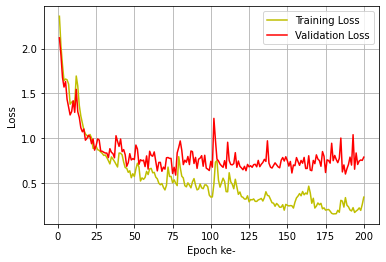

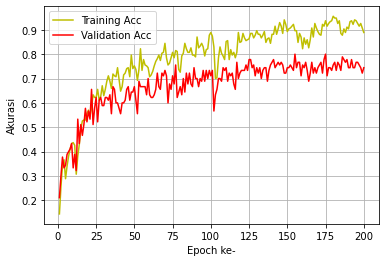

In [596]:
# Plot training and validation

loss21 = history21.history["loss"]
val_loss21 = history21.history["val_loss"]
epochs21 = range(1, len(loss21) + 1)
plt.plot(epochs21, loss21, "y", zorder=3, label="Training Loss")
plt.plot(epochs21, val_loss21, "r", zorder=3, label="Validation Loss")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc21 = history21.history["categorical_accuracy"]
val_acc21 = history21.history["val_categorical_accuracy"]
plt.plot(epochs21, acc21, "y", zorder=3, label="Training Acc")
plt.plot(epochs21, val_acc21, "r", zorder=3, label="Validation Acc")
plt.grid(which="major", axis="both", zorder=0)
plt.xlabel("Epoch ke-")
plt.ylabel("Akurasi")
plt.legend()
plt.show()

In [597]:
res21 = lstm_ahm_3.predict(X_test)

In [598]:
yhat21 = lstm_ahm_3.predict(X_test)
ytrue21 = np.argmax(y_test, axis=1).tolist()
yhat21 = np.argmax(yhat21, axis=1).tolist()

Confusion matrix, without normalization
[[9 0 0 0 0 0 0 0 0 0]
 [6 2 0 0 1 0 0 0 0 0]
 [7 0 1 0 1 0 0 0 0 0]
 [0 0 0 7 0 0 0 0 2 0]
 [0 0 1 0 8 0 0 0 0 0]
 [0 0 0 0 0 7 2 0 0 0]
 [0 0 0 0 0 4 5 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 2 0 0 0 0 7 0]
 [0 0 0 0 0 0 0 0 0 9]]


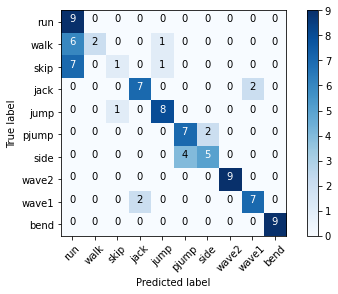

In [599]:
cm21 = confusion_matrix(y_true = ytrue21, y_pred = yhat21)
cm_plot_labels21 = ["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
plot_confusion_matrix(cm = cm21, classes = cm_plot_labels21, title = "")

In [600]:
fp21 = cm21.sum(axis=0) - np.diag(cm21)  
fn21 = cm21.sum(axis=1) - np.diag(cm21)
tp21 = np.diag(cm21)
tn21 = cm21.sum() - (fp21 + fn21 + tp21)

print(tp21)
print(fp21)
print(tn21)
print(fn21)

[9 2 1 7 8 7 5 9 7 9]
[13  0  1  2  2  4  2  0  2  0]
[68 81 80 79 79 77 79 81 79 81]
[0 7 8 2 1 2 4 0 2 0]


In [601]:
y_pred21 = lstm_ahm_3.predict(X_test)
y_pred21 = (y_pred21 > 0.5)

In [602]:
_, acc21 = lstm_ahm_3.evaluate(X_test, y_test)
print("Accuracy = ", (acc21*100), " %")

3/3 [==============================] - 0s 14ms/step - loss: 0.7807 - categorical_accuracy: 0.7111
Accuracy =  71.11111283302307  %


In [603]:
loss21_2, acc21_2 = lstm_ahm_3.evaluate(X_train, y_train)
loss21_3, acc21_3 = lstm_ahm_3.evaluate(X_valid, y_valid)

print("Accuracy2 = ", (acc21_2*100), " %")
print("Accuracy3 = ", (acc21_3*100), " %")

3/3 [==============================] - 0s 13ms/step - loss: 0.6947 - categorical_accuracy: 0.8000
Accuracy2 =  92.96296238899231  %
Accuracy3 =  80.0000011920929  %


In [604]:
acc21 = accuracy_score(ytrue21, yhat21)
acc21

0.7111111111111111

In [605]:
# Error rate
error_rate21 = 1 - acc21
error_rate21

0.28888888888888886

In [606]:
print(classification_report(
      ytrue21,
      yhat21,
      output_dict=False,
      target_names=["run", "walk", "skip", "jack", "jump", "pjump", "side", "wave2", "wave1", "bend"]
))

              precision    recall  f1-score   support

         run       0.41      1.00      0.58         9
        walk       1.00      0.22      0.36         9
        skip       0.50      0.11      0.18         9
        jack       0.78      0.78      0.78         9
        jump       0.80      0.89      0.84         9
       pjump       0.64      0.78      0.70         9
        side       0.71      0.56      0.63         9
       wave2       1.00      1.00      1.00         9
       wave1       0.78      0.78      0.78         9
        bend       1.00      1.00      1.00         9

    accuracy                           0.71        90
   macro avg       0.76      0.71      0.68        90
weighted avg       0.76      0.71      0.68        90



# Demo on a video

In [761]:
# Probability visualisation with live side bar chart

colors = [(237, 17, 17), # run:0 -> red
          (245, 117, 16), # walk:1 -> orange
          (235, 224, 16), # skip:2 -> yellow
          (155, 235, 16), # jack:3 -> lime green
          (86, 224, 58), # jump:4 -> green
          (30, 227, 132), # pjump:5 -> cyan
          (30, 224, 227), # side:6 -> light blue
          (22, 38, 219), # wave2:7 -> blue
          (170, 22, 219), # wave1:8 -> purple
          (219, 22, 104)] # bend:9 -> magenta

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*30), (int(prob*100), 90+num*30), colors[num], -1)
#         cv2.putText(output_frame, actions[num], (0, 85+num*30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
        cv2.putText(output_frame, "{}: {}%".format(actions[num], prob*100), (0, 85+num*30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
    
    return output_frame

In [764]:
# Demo Model 1 : lstm2_dense2_d_relu_mc_3_e0153_val0.844.h5

# Load Model
lstm2_dense2_d_relu_mc_3.load_weights("model/mine/lstm2_dense2_d_relu_mc_3_e0153_val0.844.h5")

# new variable
sequence = []
sentence = []
predictions = []
threshold = 0.5

#cap = cv2.VideoCapture(0) # Webcam
cap = cv2.VideoCapture("demovideo/VideoDemo-360-25-2s-capt.avi") # Demo video

# Set mediapipe model
with mp_pose.Pose(static_image_mode=False,
                  model_complexity=1,
                  smooth_landmarks=True,
                  enable_segmentation=False,
                  smooth_segmentation=True,
                  min_detection_confidence=0.5,
                  min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        
        # Read feed
        ret, frame = cap.read()
        
        # Destroy Window
        if ret == False:
            cap.release()
            cv2.destroyAllWindows()
        
        else:        
            # Make detections
            image, results = mediapipe_detection(frame, pose)
            print(results)

            # Draw landmarks
            draw_styled_landmarks(image, results)

            # Prediction logic
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-25:]

            if len(sequence) == 25:
                res = lstm2_dense2_d_relu_mc_3.predict(np.expand_dims(sequence, axis=0))[0]
                print(actions[np.argmax(res)])
                predictions.append(np.argmax(res))

                # Viz logic
                if np.unique(predictions[-10:])[0] == np.argmax(res):
                    if res[np.argmax(res)] > threshold:
                        if len(sentence) > 0:
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                        else:
                            sentence.append(actions[np.argmax(res)])
                if len(sentence) > 1:
                    sentence = sentence[-1:]

                # Viz probabilities
                image = prob_viz(res, actions, image, colors)

            cv2.rectangle(image, (0,0), (640,40), (245,117,16), -1)
            cv2.putText(image, "detection: ", (3,30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
            cv2.putText(image, " ".join(sentence), (165,30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

            # Show to screen
            cv2.imshow("Demo Model 1", image)

            # Break
            if cv2.waitKey(10) & 0xFF == ord("q"):
                break   
            
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOut

wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run


jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wa

pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOu

<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side

jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1


bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<cl

In [767]:
# Demo Model 2 : lstm2_dense2_rd_lr5_75_b2_relu_mc_2_e0194_val0.856.h5

# Load Model
lstm2_dense2_rd_lr5_75_b2_relu_mc_2.load_weights("model/mine/lstm2_dense2_rd_lr5_75_b2_relu_mc_2_e0194_val0.856.h5")

# new variable
sequence = []
sentence = []
predictions = []
threshold = 0.5

#cap = cv2.VideoCapture(0) # Webcam
cap = cv2.VideoCapture("demovideo/VideoDemo-360-25-2s-capt.avi") # Demo video

# Set mediapipe model
with mp_pose.Pose(static_image_mode=False,
                  model_complexity=1,
                  smooth_landmarks=True,
                  enable_segmentation=False,
                  smooth_segmentation=True,
                  min_detection_confidence=0.5,
                  min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        
        # Read feed
        ret, frame = cap.read()
        
        # Destroy Window
        if ret == False:
            cap.release()
            cv2.destroyAllWindows()
        
        else:        
            # Make detections
            image, results = mediapipe_detection(frame, pose)
            print(results)

            # Draw landmarks
            draw_styled_landmarks(image, results)

            # Prediction logic
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-25:]

            if len(sequence) == 25:
                res = lstm2_dense2_rd_lr5_75_b2_relu_mc_2.predict(np.expand_dims(sequence, axis=0))[0]
                print(actions[np.argmax(res)])
                predictions.append(np.argmax(res))

                # Viz logic
                if np.unique(predictions[-10:])[0] == np.argmax(res):
                    if res[np.argmax(res)] > threshold:
                        if len(sentence) > 0:
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                        else:
                            sentence.append(actions[np.argmax(res)])
                if len(sentence) > 1:
                    sentence = sentence[-1:]

                # Viz probabilities
                image = prob_viz(res, actions, image, colors)

            cv2.rectangle(image, (0,0), (640,40), (245,117,16), -1)
            cv2.putText(image, "detection: ", (3,30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
            cv2.putText(image, " ".join(sentence), (165,30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

            # Show to screen
            cv2.imshow("Demo Model 2", image)

            # Break
            if cv2.waitKey(10) & 0xFF == ord("q"):
                break   
            
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python

<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
skip
<class 'mediapipe.python.solution_base.SolutionOutputs'>
skip
<class 'mediapipe.python.solution_base.SolutionOutputs'>
skip
<class 'mediapipe.python.solution_base.SolutionOutputs'>
skip
<class 'mediapipe.python.solution_base.SolutionOutputs'>
skip
<class 'mediapipe.python.solution_base.SolutionOutputs'>
skip
<class 'mediapipe.python.solution_base.SolutionOutputs'>
skip
<class 'mediapipe.python.solution_base.SolutionOutputs'>
skip
<class 'mediapipe.python.solution_base.SolutionOutputs'>
skip
<class 'mediapipe.python.solution_base.SolutionOutputs'>
skip
<class 'mediapipe.python.solution_base.SolutionOutputs'>
skip
<class 'mediapipe.python.solution_base.SolutionOutputs'>
skip
<class 'mediapipe.python.solution_base.SolutionOutputs'>
skip
<class 'mediapipe.python.solution_base.SolutionOutputs'>
skip
<class 'mediapipe.python.solution_base.SolutionOutputs'>
skip
<class 'm

jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>

<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'

side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<cl

<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<c

<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class '

In [769]:
# Demo Model 3 : lstm2_dense2_rd_lr5_75_b2_default_mc_2_e0103_val0.856.h5

# Load Model
lstm2_dense2_rd_lr5_75_b2_default_mc_2.load_weights("model/mine/lstm2_dense2_rd_lr5_75_b2_default_mc_2_e0103_val0.856.h5")

# new variable
sequence = []
sentence = []
predictions = []
threshold = 0.5

#cap = cv2.VideoCapture(0) # Webcam
cap = cv2.VideoCapture("demovideo/VideoDemo-360-25-2s-capt.avi") # Demo video

# Set mediapipe model
with mp_pose.Pose(static_image_mode=False,
                  model_complexity=1,
                  smooth_landmarks=True,
                  enable_segmentation=False,
                  smooth_segmentation=True,
                  min_detection_confidence=0.5,
                  min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        
        # Read feed
        ret, frame = cap.read()
        
        # Destroy Window
        if ret == False:
            cap.release()
            cv2.destroyAllWindows()
        
        else:        
            # Make detections
            image, results = mediapipe_detection(frame, pose)
            print(results)

            # Draw landmarks
            draw_styled_landmarks(image, results)

            # Prediction logic
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-25:]

            if len(sequence) == 25:
                res = lstm2_dense2_rd_lr5_75_b2_default_mc_2.predict(np.expand_dims(sequence, axis=0))[0]
                print(actions[np.argmax(res)])
                predictions.append(np.argmax(res))

                # Viz logic
                if np.unique(predictions[-10:])[0] == np.argmax(res):
                    if res[np.argmax(res)] > threshold:
                        if len(sentence) > 0:
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                        else:
                            sentence.append(actions[np.argmax(res)])
                if len(sentence) > 1:
                    sentence = sentence[-1:]

                # Viz probabilities
                image = prob_viz(res, actions, image, colors)

            cv2.rectangle(image, (0,0), (640,40), (245,117,16), -1)
            cv2.putText(image, "detection: ", (3,30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
            cv2.putText(image, " ".join(sentence), (165,30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

            # Show to screen
            cv2.imshow("Demo Model 3", image)

            # Break
            if cv2.waitKey(10) & 0xFF == ord("q"):
                break   
            
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python

<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.pytho

<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump

pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOu

pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<

<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<cla

<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class

In [771]:
# Demo VA-LSTM-SYSU : va_lstm_sysu_1_e0189_val0.878.h5

# Load Model
va_lstm_sysu_1.load_weights("model/others/va_lstm_sysu_1_e0189_val0.878.h5")

# new variable
sequence = []
sentence = []
predictions = []
threshold = 0.5

#cap = cv2.VideoCapture(0) # Webcam
cap = cv2.VideoCapture("demovideo/VideoDemo-360-25-2s-capt.avi") # Demo video

# Set mediapipe model
with mp_pose.Pose(static_image_mode=False,
                  model_complexity=1,
                  smooth_landmarks=True,
                  enable_segmentation=False,
                  smooth_segmentation=True,
                  min_detection_confidence=0.5,
                  min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        
        # Read feed
        ret, frame = cap.read()
        
        # Destroy Window
        if ret == False:
            cap.release()
            cv2.destroyAllWindows()
        
        else:        
            # Make detections
            image, results = mediapipe_detection(frame, pose)
            print(results)

            # Draw landmarks
            draw_styled_landmarks(image, results)

            # Prediction logic
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-25:]

            if len(sequence) == 25:
                res = va_lstm_sysu_1.predict(np.expand_dims(sequence, axis=0))[0]
                print(actions[np.argmax(res)])
                predictions.append(np.argmax(res))

                # Viz logic
                if np.unique(predictions[-10:])[0] == np.argmax(res):
                    if res[np.argmax(res)] > threshold:
                        if len(sentence) > 0:
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                        else:
                            sentence.append(actions[np.argmax(res)])
                if len(sentence) > 1:
                    sentence = sentence[-1:]

                # Viz probabilities
                image = prob_viz(res, actions, image, colors)

            cv2.rectangle(image, (0,0), (640,40), (245,117,16), -1)
            cv2.putText(image, "detection: ", (3,30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
            cv2.putText(image, " ".join(sentence), (165,30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

            # Show to screen
            cv2.imshow("VA-LSTM-SYSU", image)

            # Break
            if cv2.waitKey(10) & 0xFF == ord("q"):
                break   
            
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 

jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pju

pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOu

pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutputs'>
side
<class 'mediapipe.python.solution_base.SolutionOutpu

jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wav

bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<cl

In [772]:
# Demo VA-LSTM-SBU : va_lstm_sbu_2_e0186_val0.856.h5

# Load Model
va_lstm_sbu_2.load_weights("model/others/va_lstm_sbu_2_e0186_val0.856.h5")

# new variable
sequence = []
sentence = []
predictions = []
threshold = 0.5

#cap = cv2.VideoCapture(0) # Webcam
cap = cv2.VideoCapture("demovideo/VideoDemo-360-25-2s-capt.avi") # Demo video

# Set mediapipe model
with mp_pose.Pose(static_image_mode=False,
                  model_complexity=1,
                  smooth_landmarks=True,
                  enable_segmentation=False,
                  smooth_segmentation=True,
                  min_detection_confidence=0.5,
                  min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        
        # Read feed
        ret, frame = cap.read()
        
        # Destroy Window
        if ret == False:
            cap.release()
            cv2.destroyAllWindows()
        
        else:        
            # Make detections
            image, results = mediapipe_detection(frame, pose)
            print(results)

            # Draw landmarks
            draw_styled_landmarks(image, results)

            # Prediction logic
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-25:]

            if len(sequence) == 25:
                res = va_lstm_sbu_2.predict(np.expand_dims(sequence, axis=0))[0]
                print(actions[np.argmax(res)])
                predictions.append(np.argmax(res))

                # Viz logic
                if np.unique(predictions[-10:])[0] == np.argmax(res):
                    if res[np.argmax(res)] > threshold:
                        if len(sentence) > 0:
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                        else:
                            sentence.append(actions[np.argmax(res)])
                if len(sentence) > 1:
                    sentence = sentence[-1:]

                # Viz probabilities
                image = prob_viz(res, actions, image, colors)

            cv2.rectangle(image, (0,0), (640,40), (245,117,16), -1)
            cv2.putText(image, "detection: ", (3,30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
            cv2.putText(image, " ".join(sentence), (165,30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

            # Show to screen
            cv2.imshow("VA-LSTM-SBU", image)

            # Break
            if cv2.waitKey(10) & 0xFF == ord("q"):
                break   
            
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOu

<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
ru

jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<

pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOu

<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'

<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class '

wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOu

In [773]:
# Demo LSTM-PASL : lstm_pasl_3_e0092_val0.844.h5

# Load Model
lstm_pasl_3.load_weights("model/others/lstm_pasl_3_e0092_val0.844.h5")

# new variable
sequence = []
sentence = []
predictions = []
threshold = 0.5

#cap = cv2.VideoCapture(0) # Webcam
cap = cv2.VideoCapture("demovideo/VideoDemo-360-25-2s-capt.avi") # Demo video

# Set mediapipe model
with mp_pose.Pose(static_image_mode=False,
                  model_complexity=1,
                  smooth_landmarks=True,
                  enable_segmentation=False,
                  smooth_segmentation=True,
                  min_detection_confidence=0.5,
                  min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        
        # Read feed
        ret, frame = cap.read()
        
        # Destroy Window
        if ret == False:
            cap.release()
            cv2.destroyAllWindows()
        
        else:        
            # Make detections
            image, results = mediapipe_detection(frame, pose)
            print(results)

            # Draw landmarks
            draw_styled_landmarks(image, results)

            # Prediction logic
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-25:]

            if len(sequence) == 25:
                res = lstm_pasl_3.predict(np.expand_dims(sequence, axis=0))[0]
                print(actions[np.argmax(res)])
                predictions.append(np.argmax(res))

                # Viz logic
                if np.unique(predictions[-10:])[0] == np.argmax(res):
                    if res[np.argmax(res)] > threshold:
                        if len(sentence) > 0:
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                        else:
                            sentence.append(actions[np.argmax(res)])
                if len(sentence) > 1:
                    sentence = sentence[-1:]

                # Viz probabilities
                image = prob_viz(res, actions, image, colors)

            cv2.rectangle(image, (0,0), (640,40), (245,117,16), -1)
            cv2.putText(image, "detection: ", (3,30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
            cv2.putText(image, " ".join(sentence), (165,30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

            # Show to screen
            cv2.imshow("LSTM-PASL", image)

            # Break
            if cv2.waitKey(10) & 0xFF == ord("q"):
                break   
            
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class '

run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class '

<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave2
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<cl

pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
pjump
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOu

walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<cl

<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1


bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<cl

In [774]:
# Demo LSTM-AHM : lstm_ahm_2_e0197_val0.800.h5

# Load Model
lstm_ahm_2.load_weights("model/others/lstm_ahm_2_e0197_val0.800.h5")

# new variable
sequence = []
sentence = []
predictions = []
threshold = 0.5

#cap = cv2.VideoCapture(0) # Webcam
cap = cv2.VideoCapture("demovideo/VideoDemo-360-25-2s-capt.avi") # Demo video

# Set mediapipe model
with mp_pose.Pose(static_image_mode=False,
                  model_complexity=1,
                  smooth_landmarks=True,
                  enable_segmentation=False,
                  smooth_segmentation=True,
                  min_detection_confidence=0.5,
                  min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        
        # Read feed
        ret, frame = cap.read()
        
        # Destroy Window
        if ret == False:
            cap.release()
            cv2.destroyAllWindows()
        
        else:        
            # Make detections
            image, results = mediapipe_detection(frame, pose)
            print(results)

            # Draw landmarks
            draw_styled_landmarks(image, results)

            # Prediction logic
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-25:]

            if len(sequence) == 25:
                res = lstm_ahm_2.predict(np.expand_dims(sequence, axis=0))[0]
                print(actions[np.argmax(res)])
                predictions.append(np.argmax(res))

                # Viz logic
                if np.unique(predictions[-10:])[0] == np.argmax(res):
                    if res[np.argmax(res)] > threshold:
                        if len(sentence) > 0:
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                        else:
                            sentence.append(actions[np.argmax(res)])
                if len(sentence) > 1:
                    sentence = sentence[-1:]

                # Viz probabilities
                image = prob_viz(res, actions, image, colors)

            cv2.rectangle(image, (0,0), (640,40), (245,117,16), -1)
            cv2.putText(image, "detection: ", (3,30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
            cv2.putText(image, " ".join(sentence), (165,30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

            # Show to screen
            cv2.imshow("LSTM-AHM", image)

            # Break
            if cv2.waitKey(10) & 0xFF == ord("q"):
                break   
            
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<cla

walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class

wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
jack
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run


wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOu

walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave2
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave2
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave2
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave1
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
walk
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wa

wave2
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave2
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave2
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave2
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave2
<class 'mediapipe.python.solution_base.SolutionOutputs'>
run
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave2
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave2
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave2
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave2
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave2
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave2
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave2
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave2
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave2
<class 'mediapipe.python.solution_base.SolutionOutputs'>
wave2
<class 'mediapipe.python.solution_base.SolutionOutp

bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<class 'mediapipe.python.solution_base.SolutionOutputs'>
bend
<cl

In [766]:
# emergency exit command
cap.release()
cv2.destroyAllWindows()